Copyright (c) Meta Platforms, Inc. and affiliates.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/co-tracker/blob/main/notebooks/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# CoTracker: It is Better to Track Together
This is a demo for <a href="https://co-tracker.github.io/">CoTracker</a>, a model that can track any point in a video.

<img src="https://www.robots.ox.ac.uk/~nikita/storage/cotracker/bmx-bumps.gif" alt="Logo" width="50%">

Don't forget to turn on GPU support if you're running this demo in Colab. 

**Runtime** -> **Change runtime type** -> **Hardware accelerator** -> **GPU**

Let's install dependencies for Colab:

In [176]:
import os
import torch

from base64 import b64encode
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML

Read a video from CO3D:

In [177]:
video_dir = '../paper_data/video_6/'
video_path = os.path.join(video_dir, 'orig/video_6_rotated.mov')
video = read_video_from_path(video_path)
video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float()

In [ ]:
def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")
 
show_video(video_path)

Import CoTrackerPredictor and create an instance of it. We'll use this object to estimate tracks:

In [322]:
from cotracker.predictor import CoTrackerPredictor

model = CoTrackerPredictor(
    checkpoint=os.path.join(
        '../checkpoints/cotracker2v1.pth'
    ), 
    window_len=16
)

In [323]:
if torch.cuda.is_available():
    model = model.cuda()
    video = video.cuda()

Track points sampled on a regular grid of size 30\*30 on the first frame:

In [324]:
pred_tracks, pred_visibility = model(video, grid_size=30)

Visualize and save the result: 

In [ ]:
vis = Visualizer(save_dir=os.path.join(video_dir, "tracking"), pad_value=100)
vis.visualize(video=video, tracks=pred_tracks, visibility=pred_visibility, filename='teaser');

In [ ]:
show_video(os.path.join(video_dir, "tracking/teaser.mp4"))

## Tracking manually selected points

We will start by tracking points queried manually.
We define a queried point as: [time, x coord, y coord] 

So, the code below defines points with different x and y coordinates sampled on frames 0, 10, 20, and 30:

In [ ]:
import cv2
import numpy as np

def select_roi(frame):
    """Allow user to select a region of interest (ROI) on the frame."""
    roi = cv2.selectROI("Select Region of Interest", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select Region of Interest")
    return roi

def detect_points(frame, roi, blue_lower, blue_upper):
    """Detect blue points in the frame within the ROI."""
    roi_frame = frame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
    hsv = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2HSV)
    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)[:68]
    
    points = []
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        x, y = int(x) + int(roi[0]), int(y) + int(roi[1])
        points.append((x, y))
    
    return points

def correct_points(frame, points):
    """Allow user to correct point positions by dragging."""
    corrected_points = points.copy()
    window_name = "Correct Points (Drag to move, press Enter when done, 'r' to reset a point)"
    cv2.namedWindow(window_name)
    
    dragging = False
    drag_point_index = -1

    def mouse_callback(event, x, y, flags, param):
        nonlocal dragging, drag_point_index, corrected_points
        
        if event == cv2.EVENT_LBUTTONDOWN:
            drag_point_index = min(range(len(corrected_points)), 
                                   key=lambda i: (corrected_points[i][0]-x)**2 + (corrected_points[i][1]-y)**2)
            dragging = True
        
        elif event == cv2.EVENT_MOUSEMOVE:
            if dragging:
                corrected_points[drag_point_index] = (x, y)
        
        elif event == cv2.EVENT_LBUTTONUP:
            dragging = False
            drag_point_index = -1
        
        frame_copy = frame.copy()
        for i, (px, py) in enumerate(corrected_points):
            cv2.circle(frame_copy, (px, py), 5, (255, 0, 0), -1)
            cv2.putText(frame_copy, f'ID:{i}', (px, py - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow(window_name, frame_copy)
    
    cv2.setMouseCallback(window_name, mouse_callback)
    
    while True:
        frame_copy = frame.copy()
        for i, (x, y) in enumerate(corrected_points):
            cv2.circle(frame_copy, (x, y), 5, (255, 0, 0), -1)
            cv2.putText(frame_copy, f'ID:{i}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow(window_name, frame_copy)
        
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press Enter to finish correction
            break
        elif key == ord('r'):  # Press 'r' to reset a point
            print("Click on the point you want to reset.")
            reset_point = cv2.waitKey(0) & 0xFF
            if reset_point >= ord('0') and reset_point <= ord('9'):
                index = reset_point - ord('0')
                if index < len(corrected_points):
                    corrected_points[index] = points[index]  # Reset to original position
    
    cv2.destroyWindow(window_name)
    return corrected_points

# Load the video
# video_path = "/Users/mitchfogelson/Downloads/trimmed_scissor_video.mov"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    print("Failed to read the video")
    exit()

# Let the user select the ROI
roi = select_roi(first_frame)

# Define HSV color range for blue dots
blue_lower = np.array([100, 20, 14])
blue_upper = np.array([180, 255, 255])

# Detect initial points
initial_points = detect_points(first_frame, roi, blue_lower, blue_upper)

# Allow user to correct initial points
corrected_points = correct_points(first_frame, initial_points)

# Create the output vector
output_vector = [[0, x, y] for x, y in corrected_points]

# Print the output vector
print("Output vector [frame #, xpos, ypos]:")
for point in output_vector:
    print(point)

# Release everything
cap.release()
cv2.destroyAllWindows()

In [328]:
queries = torch.tensor(output_vector).float()[None].reshape(-1, 3)
if torch.cuda.is_available():
    queries = queries.cuda()

In [ ]:
queries[:,0]

We pass these points as input to the model and track them:

In [330]:
pred_tracks, pred_visibility = model(video, queries=queries[None])

Finally, we visualize the results with tracks leaving traces from the frame where the tracking starts.
Color encodes time:

In [331]:
vis = Visualizer(
    save_dir=os.path.join(video_dir, "tracking"),
    linewidth=6,
    mode='cool',
    tracks_leave_trace=-1
)


In [ ]:

vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='queries');

In [ ]:
show_video(os.path.join(video_dir, "tracking/queries.mp4"))

Notice that points queried at frames 10, 20, and 30 are tracked **incorrectly** before the query frame. This is because CoTracker is an online algorithm and only tracks points in one direction. However, we can also run it backward from the queried point to track in both directions. Let's correct this:

In [ ]:
import cv2
import numpy as np

def select_roi(frame):
    """Allow user to select a region of interest (ROI) on the frame."""
    roi = cv2.selectROI("Select Region of Interest", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select Region of Interest")
    return roi

def detect_points(frame, roi, blue_lower, blue_upper):
    """Detect blue points in the frame within the ROI."""
    roi_frame = frame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
    hsv = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2HSV)
    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)[:68]
    
    points = []
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        x, y = int(x) + int(roi[0]), int(y) + int(roi[1])
        points.append((x, y))
    
    return points

def correct_points(frame, points):
    """Allow user to correct point positions by dragging."""
    corrected_points = points.copy()
    window_name = "Correct Points (Drag to move, press Enter when done, 'r' to reset a point)"
    cv2.namedWindow(window_name)
    
    dragging = False
    drag_point_index = -1

    def mouse_callback(event, x, y, flags, param):
        nonlocal dragging, drag_point_index, corrected_points
        
        if event == cv2.EVENT_LBUTTONDOWN:
            drag_point_index = min(range(len(corrected_points)), 
                                   key=lambda i: (corrected_points[i][0]-x)**2 + (corrected_points[i][1]-y)**2)
            dragging = True
        
        elif event == cv2.EVENT_MOUSEMOVE:
            if dragging:
                corrected_points[drag_point_index] = (x, y)
        
        elif event == cv2.EVENT_LBUTTONUP:
            dragging = False
            drag_point_index = -1
        
        frame_copy = frame.copy()
        for i, (px, py) in enumerate(corrected_points):
            cv2.circle(frame_copy, (px, py), 5, (255, 0, 0), -1)
            cv2.putText(frame_copy, f'ID:{i}', (px, py - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow(window_name, frame_copy)
    
    cv2.setMouseCallback(window_name, mouse_callback)
    
    while True:
        frame_copy = frame.copy()
        for i, (x, y) in enumerate(corrected_points):
            cv2.circle(frame_copy, (x, y), 5, (255, 0, 0), -1)
            cv2.putText(frame_copy, f'ID:{i}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.imshow(window_name, frame_copy)
        
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press Enter to finish correction
            break
        elif key == ord('r'):  # Press 'r' to reset a point
            print("Click on the point you want to reset.")
            reset_point = cv2.waitKey(0) & 0xFF
            if reset_point >= ord('0') and reset_point <= ord('9'):
                index = reset_point - ord('0')
                if index < len(corrected_points):
                    corrected_points[index] = points[index]  # Reset to original position
    
    cv2.destroyWindow(window_name)
    return corrected_points

# Load the video
# video_path = "/Users/mitchfogelson/Downloads/trimmed_scissor_video.mov"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Initialize last_frame
last_frame = None
frame_count = 0

# Read frames until the end of the video
while True:
    ret, frame = cap.read()
    if not ret:
        break
    last_frame = frame
    frame_count += 1

if last_frame is None:
    print("Failed to read any frames from the video")
    # exit()

print(f"Total frames in video: {frame_count}")

# Let the user select the ROI
roi = select_roi(last_frame)

# Define HSV color range for blue dots
blue_lower = np.array([100, 20, 14])
blue_upper = np.array([180, 255, 255])

# Detect initial points
initial_points = detect_points(last_frame, roi, blue_lower, blue_upper)

# Allow user to correct initial points
corrected_points = correct_points(last_frame, initial_points)


In [ ]:

# Create the output vector
output_vector = [[frame_count-1, x, y] for x, y in corrected_points]

# Print the output vector
print("Output vector [frame #, xpos, ypos]:")
for point in output_vector:
    print(point)

# Release everything
cap.release()
cv2.destroyAllWindows()

In [336]:
queries = torch.tensor(output_vector).float()[None].reshape(-1, 3)
if torch.cuda.is_available():
    queries = queries.cuda()

In [337]:
pred_tracks, pred_visibility = model(video, queries=queries[None], backward_tracking=True)


In [ ]:
pred_tracks[0,0,1,:]

In [ ]:

vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='queries_backward');

In [ ]:
show_video(os.path.join(video_dir, "tracking/queries_backward.mp4"))

In [ ]:
import cv2
import numpy as np

def select_roi(frame):
    """Allow user to select a region of interest (ROI) on the frame."""
    roi = cv2.selectROI("Select Region of Interest", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select Region of Interest")
    return roi

def select_scale_points(frame):
    """Allow user to select two points for setting the physical scale."""
    points = []
    
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Select Scale Points", frame)
            
            if len(points) == 2:
                cv2.line(frame, points[0], points[1], (0, 255, 0), 2)
                cv2.imshow("Select Scale Points", frame)
    
    cv2.namedWindow("Select Scale Points")
    cv2.setMouseCallback("Select Scale Points", mouse_callback)
    
    while len(points) < 2:
        cv2.imshow("Select Scale Points", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cv2.destroyWindow("Select Scale Points")
    return points

def calculate_scale(points, distance_meters):
    """Calculate the scale (pixels per meter) based on two points and their real-world distance."""
    pixel_distance = np.sqrt((points[1][0] - points[0][0])**2 + (points[1][1] - points[0][1])**2)
    return pixel_distance / distance_meters

def pixels_to_meters(points, scale, origin):
    """Convert pixel coordinates to meters."""
    return [((p[0] - origin[0]) / scale, (p[1] - origin[1]) / scale) for p in points]

# Load the video
# video_path = '/Users/mitchfogelson/Downloads/IMG_2071 2.mov'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Read the first frame (or last frame, depending on your preference)
ret, frame = cap.read()
if not ret:
    print("Failed to read the video")
    exit()

# Let the user select the ROI
roi = select_roi(frame)

# Let the user select two points for scale
scale_points = select_scale_points(frame)

# Ask for the real-world distance between the two points
distance_meters = float(input("Enter the distance between the two points in meters: "))

# Calculate the scale (pixels per meter)
scale = calculate_scale(scale_points, distance_meters)
print(f"Scale: {scale} pixels per meter")

# Set the origin (top-left corner of ROI)
origin = (int(roi[0]), int(roi[1]))

# Now, let's process the pred_tracks
# Assuming pred_tracks is already loaded and has shape [1, # frames, # nodes, 2]
# pred_tracks = np.random.rand(1, 100, 10, 2) * 100  # Replace this with your actual pred_tracks

# Convert pred_tracks from pixels to meters
pred_tracks_meters = np.zeros_like(pred_tracks)
for i in range(pred_tracks.shape[1]):  # For each frame
    for j in range(pred_tracks.shape[2]):  # For each node
        x_pixels, y_pixels = pred_tracks[0, i, j]
        x_meters, y_meters = pixels_to_meters([(x_pixels, y_pixels)], scale, origin)[0]
        pred_tracks_meters[0, i, j] = [x_meters, y_meters]

# Print some sample results
print("\nSample results (first 5 frames, first 3 nodes):")
print("Frame | Node | Pixels (x, y) | Meters (x, y)")
print("-" * 50)
for i in range(min(5, pred_tracks.shape[1])):
    for j in range(min(3, pred_tracks.shape[2])):
        pixels = pred_tracks[0, i, j]
        meters = pred_tracks_meters[0, i, j]
        print(f"{i:5d} | {j:4d} | ({pixels[0]:6.2f}, {pixels[1]:6.2f}) | ({meters[0]:6.2f}, {meters[1]:6.2f})")

# Release everything
cap.release()
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoFileClip
import matplotlib.animation as animation

def create_animation(pred_tracks_meters, output_file='animation.mp4', fps=30, dot_size=5):
    """
    Create an animation of the points from pred_tracks_meters.
    
    Args:
    pred_tracks_meters (np.array): Array of shape [1, # frames, # nodes, 2] containing the x, y coordinates in meters.
    output_file (str): Name of the output video file.
    fps (int): Frames per second for the output video.
    dot_size (int): Size of the dots representing the points.
    
    Returns:
    None
    """
    # Extract relevant dimensions
    num_frames = pred_tracks_meters.shape[1]
    num_nodes = pred_tracks_meters.shape[2]
    
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    #square aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    # Set the limits of the plot
    x_min, x_max = pred_tracks_meters[0, :, :, 0].min(), pred_tracks_meters[0, :, :, 0].max()
    y_min, y_max = pred_tracks_meters[0, :, :, 1].min(), pred_tracks_meters[0, :, :, 1].max()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Create a scatter plot for the points
    scatter = ax.scatter([], [], s=dot_size)
    
    # Set labels and title
    ax.set_xlabel('X position (meters)')
    ax.set_ylabel('Y position (meters)')
    ax.set_title('Point Tracking Animation')
    
    # Add a text annotation for the frame number
    frame_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, verticalalignment='top')
    
    def init():
        scatter.set_offsets(np.c_[[], []])
        frame_text.set_text('')
        return scatter, frame_text
    
    def update(frame):
        # Update the positions of the points
        positions = pred_tracks_meters[0, frame, :, :]
        scatter.set_offsets(positions)
        
        # Update the frame number text
        frame_text.set_text(f'Frame: {frame}')
        
        return scatter, frame_text
    
    # Create the animation
    anim = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, interval=1000/fps)
    
    # Save the animation as a video file
    writer = animation.writers['ffmpeg'](fps=fps)
    anim.save(output_file, writer=writer)
    
    plt.close(fig)
    
    print(f"Animation saved as {output_file}")

# Example usage:
# Assuming pred_tracks_meters is already defined
create_animation(pred_tracks_meters, output_file=os.path.join(video_dir, 'tracking/point_tracking_animation.mp4'), fps=30, dot_size=5)

In [ ]:
import numpy as np
import pandas as pd

def save_pred_tracks_to_csv(pred_tracks_meters, filename):
    """
    Save pred_tracks_meters to a CSV file with the following format:
    Headers: node ids
    Rows: (x,y) for each frame

    Args:
    pred_tracks_meters (np.array): Array of shape [1, # frames, # nodes, 2] containing the x, y coordinates in meters.
    filename (str): Name of the output CSV file.
    """
    # Remove the first dimension if it's 1
    if pred_tracks_meters.shape[0] == 1:
        pred_tracks_meters = pred_tracks_meters.squeeze(0)

    num_frames, num_nodes, _ = pred_tracks_meters.shape

    # Create headers (node IDs)
    headers = [f'Node_{i}' for i in range(num_nodes)]

    # Create a list to store each row of data
    data_rows = []

    # Process each frame
    for frame in range(num_frames):
        row = []
        for node in range(num_nodes):
            x, y = pred_tracks_meters[frame, node]
            row.append(f'({x:.4f},{y:.4f})')
        data_rows.append(row)

    # Create a DataFrame
    df = pd.DataFrame(data_rows, columns=headers)

    # Add a frame number column
    df.insert(0, 'Frame', range(num_frames))

    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Example usage:
# Assuming pred_tracks_meters is already defined
if not os.path.exists(os.path.join(video_dir, 'csv')):
    os.makedirs(os.path.join(video_dir, 'csv'))
save_pred_tracks_to_csv(pred_tracks_meters, os.path.join(video_dir, 'csv/pred_tracks_formatted.csv'))

## Get slop from video

In [179]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [180]:
df = pd.read_csv(os.path.join(video_dir, 'csv/pred_tracks_formatted.csv'))

In [181]:
frame = 1

In [182]:
positions = np.asarray([[float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])

In [ ]:

# plot the data 
plt.figure(figsize=(10, 10))
# for i in range(1, df.shape[1]):
plt.scatter(positions[:,0], positions[:,1],  s=10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('Frame')
plt.ylabel('Position (meters)')
plt.title('Point Tracking Data')
# plt.legend()
plt.show()


In [223]:
# get the 3 points with the smallest x values
sorted_positions = positions[positions[:,0].argsort()]

In [224]:
center_pos = sorted_positions[0, 1]

In [225]:
center_points = [p for p in sorted_positions if np.linalg.norm(p[1]-center_pos) <= 1.055e-2]

In [230]:
def group_points(sorted_positions, tolerance=5e-3):
    grouped_points = []
    adjacency_matrix = np.zeros((len(sorted_positions), len(sorted_positions)))

    center = sorted_positions[0,1]

    # Get the center points that are close to the scissor center
    center_points = [p for p in sorted_positions if np.linalg.norm(p[1] - center) <= tolerance]
    center_points_ind = [i for i, p in enumerate(sorted_positions) if np.linalg.norm(p[1] - center) <= tolerance]
    
    # get all the points that are not the center points 
    sorted_positions_reduced = np.delete(sorted_positions, center_points_ind, axis=0)
    
    for center_point in center_points:
        # Find the 4 points in the [top right, bottom left, bottom right, top left] quadrants
        top_right = min([p for p in sorted_positions_reduced if p[0] > center_point[0] and p[1] > center_point[1]],
                        key=lambda p: np.linalg.norm(p - center_point), default=None)
        bottom_left = min([p for p in sorted_positions_reduced if p[0] < center_point[0] and p[1] < center_point[1]],
                            key=lambda p: np.linalg.norm(p - center_point), default=None)
        bottom_right = min([p for p in sorted_positions_reduced if p[0] > center_point[0] and p[1] < center_point[1]],
                            key=lambda p: np.linalg.norm(p - center_point), default=None)
        top_left = min([p for p in sorted_positions_reduced if p[0] < center_point[0] and p[1] > center_point[1]],
                        key=lambda p: np.linalg.norm(p - center_point), default=None)
        connected_points = [top_right, bottom_left, bottom_right, top_left]

        grouped_points.append({
            'center': center_point,
            'points': connected_points
        })

        # Find indices of the center and connected points in the original sorted_positions
        center_idx = np.where((sorted_positions == center_point).all(axis=1))[0][0]
        adjacency_matrix[center_idx][center_idx] = 1  # Set connection to itself

        for point in connected_points:
            if point is None:  # If the point exists
                continue
            point_idx = np.where((sorted_positions == point).all(axis=1))[0][0]
            adjacency_matrix[center_idx][point_idx] = 1  # Set connection in adjacency matrix
            adjacency_matrix[point_idx][center_idx] = 1  # Make it bidirectional
            adjacency_matrix[point_idx][point_idx] = 1

    return grouped_points, adjacency_matrix

In [ ]:
len(center_points)

In [232]:
grouped_points_real, adj_mat = group_points(sorted_positions, 1.055e-2)

In [ ]:
grouped_points_real

In [234]:
# get lower triangle of the adjacency matrix
adj_mat = np.tril(adj_mat)


In [ ]:
adj_mat

In [ ]:
len(center_points)

In [ ]:
sorted_positions[1,:]

In [238]:
# get the angle between the 3 points
def angle_between_points(p1, p2, p3):
    """Calculate the angle between three points."""
    v1 = p1 - p2
    v2 = p3 - p2
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return np.degrees(angle)

In [239]:
angle = angle_between_points(sorted_positions[0], sorted_positions[1], sorted_positions[2])

In [240]:
def angle_between_2_points(p1, p2):
    """
    Calculate the angle (in degrees) between the line formed by two points (p1, p2) and the x-axis.
    
    Parameters:
    p1 (tuple): Coordinates of the first point (x1, y1)
    p2 (tuple): Coordinates of the second point (x2, y2)
    
    Returns:
    float: Angle between the line through the points and the x-axis, in degrees.
    """
    # Calculate the difference in x and y coordinates
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    
    # Calculate the angle using atan2, then convert it to degrees
    angle_rad = np.arctan2(delta_y, delta_x)
    angle_deg = np.rad2deg(angle_rad)
    
    return angle_deg

In [241]:
offset_angle = angle_between_2_points(sorted_positions[0], sorted_positions[2])

In [242]:
length = np.linalg.norm(sorted_positions[0] - sorted_positions[1])*2

In [243]:
class ScissorMechanism:
    def __init__(self, link_length, angle, offset_position, offset_rotation, num_cells):
        self.link_length = link_length
        self.angle = np.deg2rad(angle)  # Convert angle to radians
        self.offset_position = np.array(offset_position)
        self.offset_rotation = np.deg2rad(offset_rotation)  # Convert offset rotation to radians
        self.num_cells = num_cells

    def calculate_endpoints(self):
        """
        Calculate the positions of the center and end points for each scissor unit.
        Returns a list of center and endpoint positions.
        """
        # List to hold the position of the centers and points of all scissor units
        positions = []

        # Loop over the number of scissor cells
        for i in range(self.num_cells):
            # Calculate the x and y positions based on the link length and angle for each cell
            center_x = self.offset_position[0] + i * self.link_length * np.cos(self.angle/2)
            center_y = self.offset_position[1]
            center_position = np.array([center_x, center_y])

            # Endpoints of the scissor link (left and right)
            endpoint_1_x = center_x + 0.5 * self.link_length * np.cos(self.angle/2)
            endpoint_1_y = center_y + 0.5 * self.link_length * np.sin(self.angle/2)
            endpoint_2_x = center_x - 0.5 * self.link_length * np.cos(self.angle/2)
            endpoint_2_y = center_y - 0.5 * self.link_length * np.sin(self.angle/2)
            # Endpoints of the scissor link (left and right)
            endpoint_3_x = center_x + 0.5 * self.link_length * np.cos(-self.angle/2)
            endpoint_3_y = center_y + 0.5 * self.link_length * np.sin(-self.angle/2)
            endpoint_4_x = center_x - 0.5 * self.link_length * np.cos(-self.angle/2)
            endpoint_4_y = center_y - 0.5 * self.link_length * np.sin(-self.angle/2)


            endpoint_1 = np.array([endpoint_1_x, endpoint_1_y])
            endpoint_2 = np.array([endpoint_2_x, endpoint_2_y])
            endpoint_3 = np.array([endpoint_3_x, endpoint_3_y])
            endpoint_4 = np.array([endpoint_4_x, endpoint_4_y])

            # Append positions of center and endpoints for this scissor unit
            positions.append({
                'center': center_position,
                'points': (endpoint_1, endpoint_2, endpoint_3, endpoint_4)
            })

        return positions

    def display_positions(self):
        """
        Display the center and endpoints for each scissor unit.
        """
        positions = self.calculate_endpoints()
        for i, pos in enumerate(positions):
            print(f"Scissor Unit {i+1}:")
            print(f"  Center: {pos['center']}")
            print(f"  Endpoints: {pos['points']}\n")

In [244]:
# Define parameters for the scissor mechanism
link_length = length # Length of each scissor link
angle = angle  # Angle between scissor arms
offset_position = sorted_positions[0,:]  # Starting position of the first scissor center
offset_rotation = offset_angle  # No rotation applied to the entire scissor mechanism
num_cells = 0 # Number of scissor units

# Create the scissor mechanism and display positions
scissor = ScissorMechanism(link_length, angle, offset_position, offset_rotation, num_cells)
scissor.display_positions()

In [245]:
def plot_real_v_sim(scissor_positions, grouped_points_real, frame_id, show=False, save=False, video_dir=video_dir, active_units=None):
    plt.figure(figsize=(10, 10))
    # for i in range(1, df.shape[1]):
    # scissor_positions = scissor.calculate_endpoints()
    # Plot the scissor mechanism
    for unit in scissor_positions:
        center = unit['center']
        plt.scatter(center[0], center[1], color='r')
    
        for endpoint in unit['points']:
            if endpoint is None:
                continue
            plt.scatter(endpoint[0], endpoint[1], color='g')
            plt.plot([center[0], endpoint[0]], [center[1], endpoint[1]], color='r')

        
    for unit in grouped_points_real:
        center = unit['center']
        plt.scatter(center[0], center[1], color='b')

        for endpoint in unit['points']:
            if endpoint is None:
                continue
            plt.scatter(endpoint[0], endpoint[1], color='k')
            plt.plot([center[0], endpoint[0]], [center[1], endpoint[1]], color='b')

    if active_units is not None:
        grouped_points = [grouped_points_real[i] for i in active_units]
        for unit in grouped_points:
            center = unit['center']
            plt.scatter(center[0], center[1], color='y')

            for endpoint in unit['points']:
                if endpoint is None:
                    continue
                plt.scatter(endpoint[0], endpoint[1], color='y')
                plt.plot([center[0], endpoint[0]], [center[1], endpoint[1]], color='y')

    # Formatting the plot
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('Frame')
    plt.ylabel('Position (meters)')
    plt.title('Point Tracking Data with Scissor Mechanism')
    # set x and y limits 
    plt.xlim(0, 0.6)
    plt.ylim(0, 0.06)
    # plt.legend()
    if show:
        plt.show()
        
    if save: 
        plt.savefig(os.path.join(video_dir, f'images/scissor_mechanism_{frame_id}.png'));

In [246]:
slops = []
scissor_positions = scissor.calculate_endpoints()
for real_unit, sim_unit in zip(grouped_points_real, scissor_positions):
    x_slop = real_unit['center'][0] - sim_unit['center'][0]
    y_slop = real_unit['center'][1] - sim_unit['center'][1]
    slops.append([x_slop, y_slop])
    
    for endpoint_real, endpoint_sim in zip(real_unit['points'], sim_unit['points']):
        if endpoint_real is None or endpoint_sim is None:
            continue
        x_slop = endpoint_real[0] - endpoint_sim[0]
        y_slop = endpoint_real[1] - endpoint_sim[1]
        slops.append([x_slop, y_slop])
    

In [247]:
def plot_slops_unadjusted(slops, frame_id, show=False, save=False, video_dir=video_dir):
    slops = np.array(slops)
    plt.figure(figsize=(10, 10))
    plt.scatter(range(len(slops)), slops[:,0], label='X Slop')
    plt.scatter(range(len(slops)), slops[:,1], label='Y Slop')
    plt.legend()
    plt.xlabel('point id')
    plt.ylabel('Slop')
    plt.title("Slops between real and simulated points")
    plt.xlim(0, 120)
    plt.ylim(-0.25, 0.05)
    if show:
        plt.show()
        
    if save: 
        plt.savefig(os.path.join(video_dir, f'images/slops_unadjusteed_{frame_id}.png'));



In [248]:
slops = np.array(slops)
n = np.array(slops).shape[0]
# Create a lower triangular matrix with 1's
lower_triangular_matrix = np.tril(np.ones((n, n)))

In [ ]:
slops

In [ ]:
x_slops = np.matmul(np.linalg.inv(lower_triangular_matrix),slops[:,0])
y_slops = np.matmul(np.linalg.inv(lower_triangular_matrix),slops[:,1])

In [251]:
def plot_slops_adjusted(x_slops, y_slops, frame_id, show=False, save=False,video_dir=video_dir):
    plt.figure(figsize=(10, 10))
    plt.scatter(range(len(x_slops)), x_slops, label='X Slop')
    plt.scatter(range(len(y_slops)), y_slops, label='Y Slop')
    plt.legend()
    plt.xlabel('point id')
    plt.ylabel('Slop')
    plt.title("Slops between real and simulated points")
    plt.xlim(0, 120)
    plt.ylim(-0.05, 0.05)
    if show:
        plt.show()
        
    if save: 
        plt.savefig(os.path.join(video_dir, f'images/slops_adjusted_{frame_id}.png'));

In [ ]:
center_points[:3,:]

In [ ]:
grouped_points_real[0]

In [254]:
def get_active_nodes(df, frame, angle_diff_threshold=5.0):
    first_positions = np.asarray([[float(df.iloc[0,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[0,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])
    first_positions = first_positions[first_positions[:,0].argsort()]

    last_positions = np.asarray([[float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])
    last_positions = last_positions[last_positions[:,0].argsort()]

    grouped_points_real_first, _ = group_points(first_positions, 1.055e-2)
    grouped_points_real_last, _ = group_points(last_positions, 1.055e-2)
    
    active_units = []
    for i, (unit_first, unit_last) in enumerate(zip(grouped_points_real_first, grouped_points_real_last)):
        if any(p is None for p in unit_first['points'][0:4:3]) or any(p is None for p in unit_last['points'][0:4:3]):
            continue
        angle_first = angle_between_points(unit_first['points'][0], unit_first['center'], unit_first['points'][-1])
        angle_last = angle_between_points(unit_last['points'][0], unit_last['center'], unit_last['points'][-1])
        angle_diff = abs(angle_last - angle_first)
            
        if angle_diff > angle_diff_threshold:
            active_units.append(i)
            
    return active_units

In [255]:
grouped_points_real, adj_mat = group_points(sorted_positions, 1.055e-2)


In [ ]:
grouped_points_real

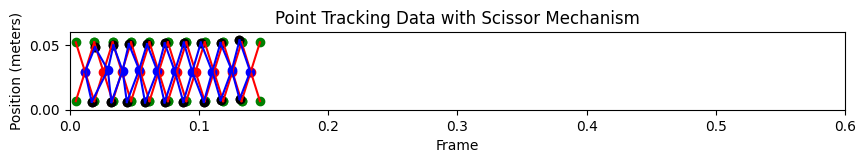

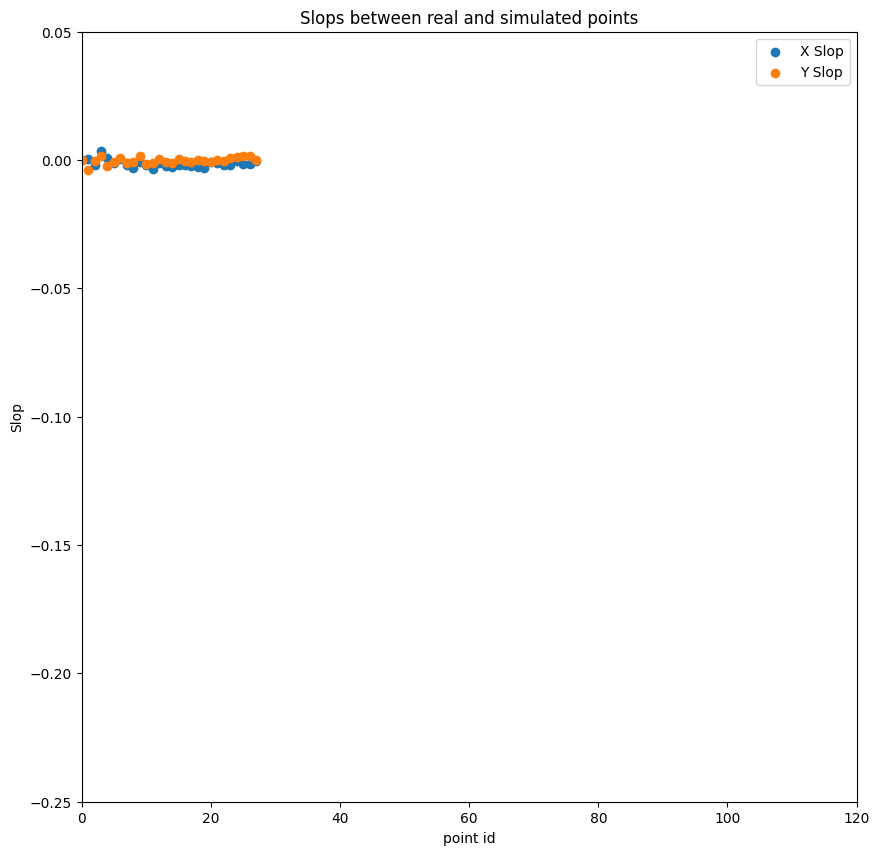

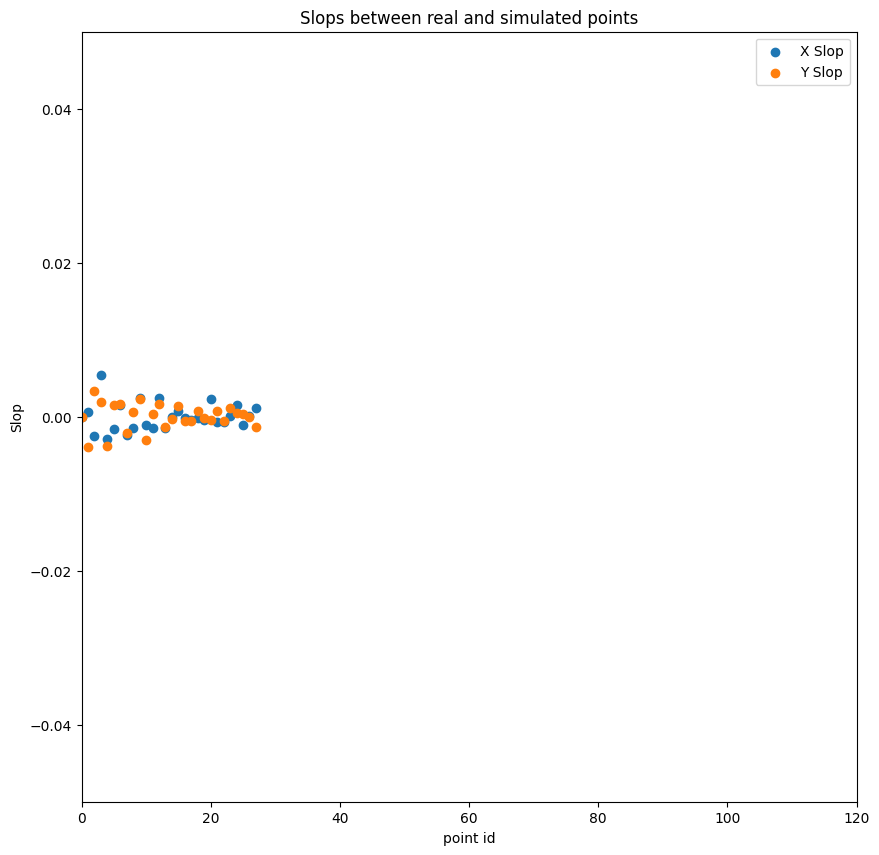

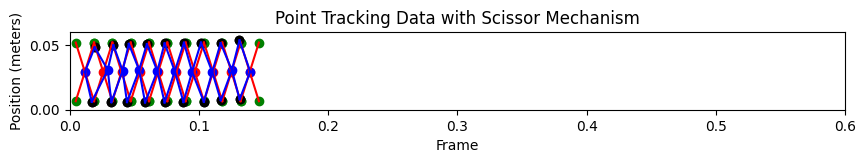

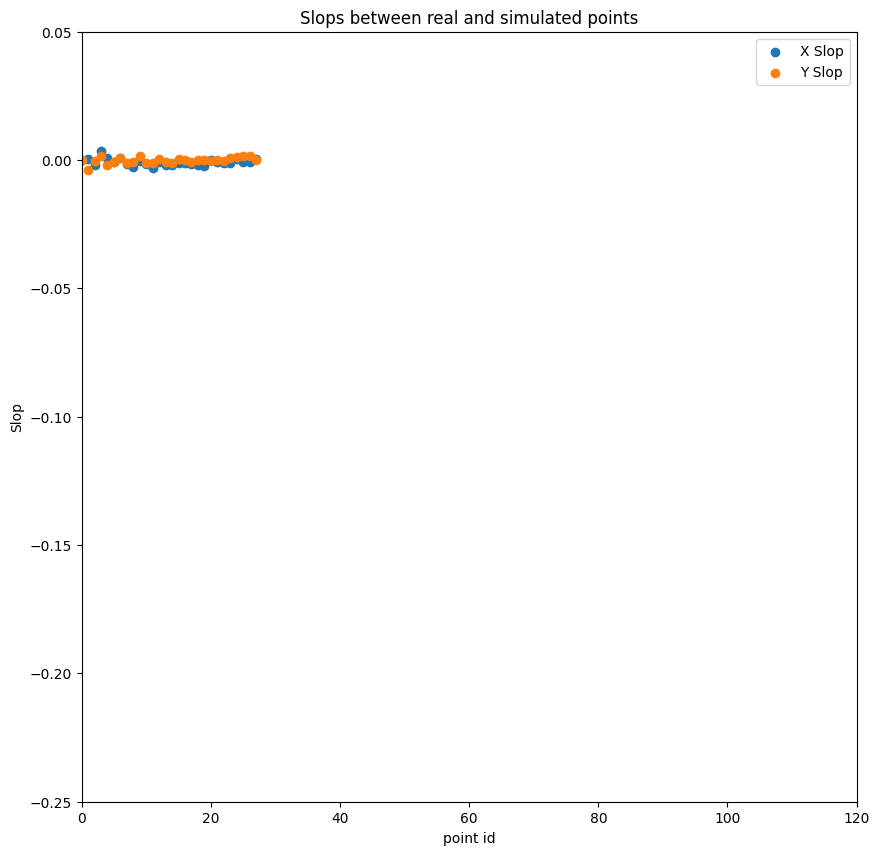

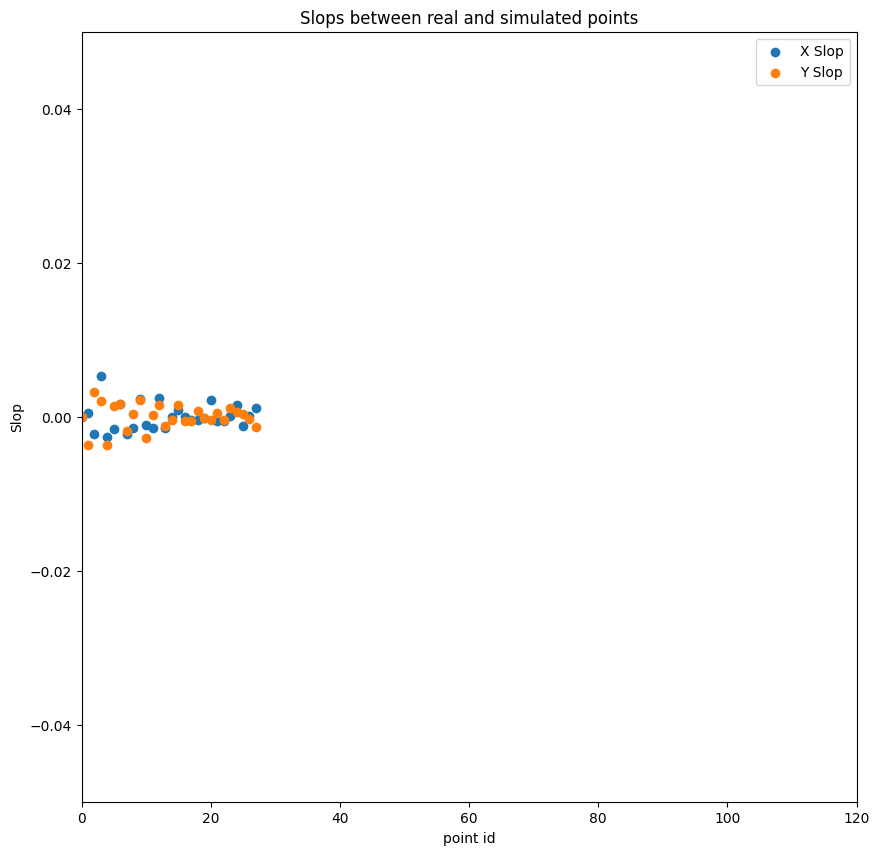

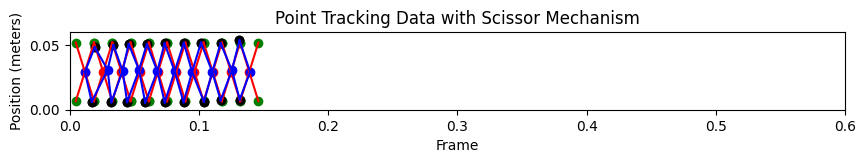

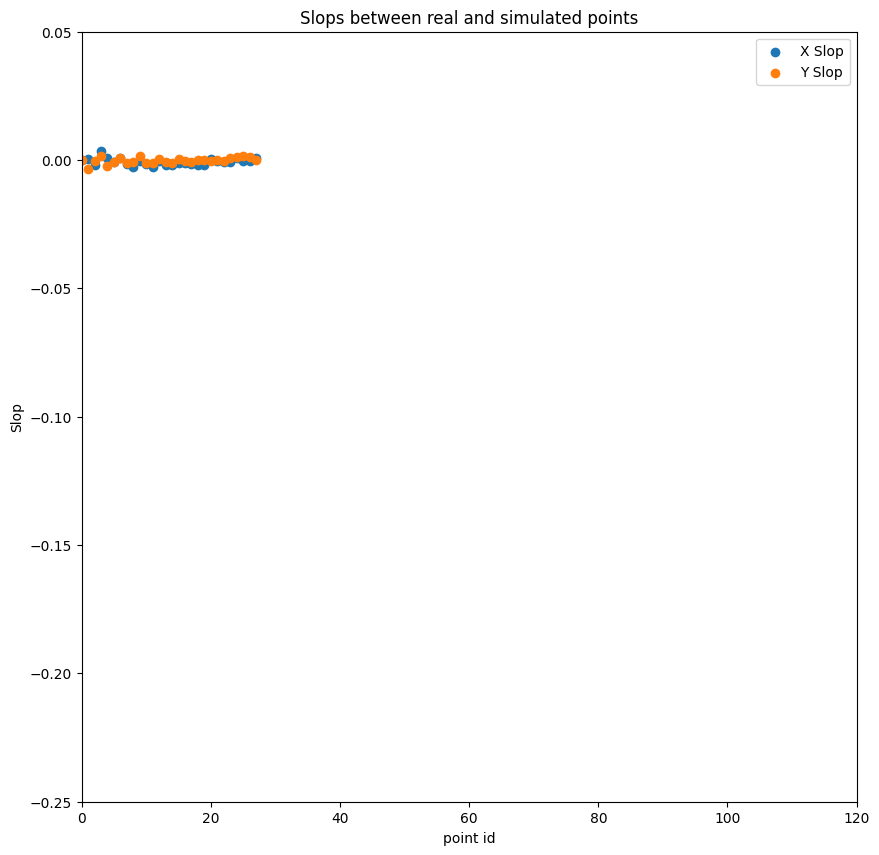

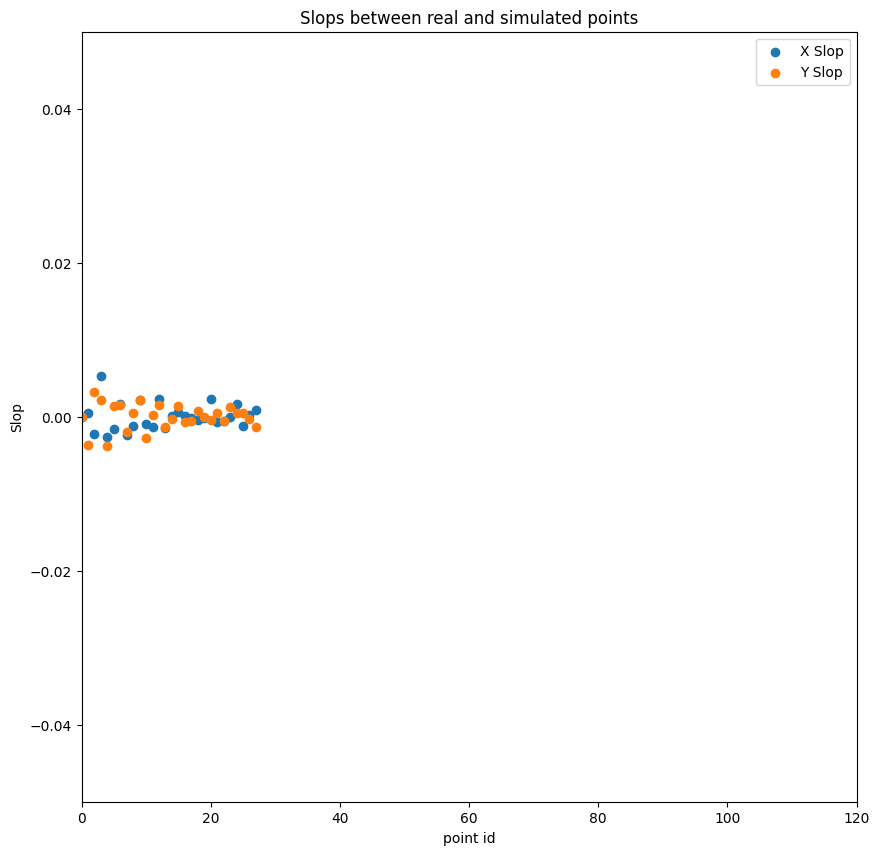

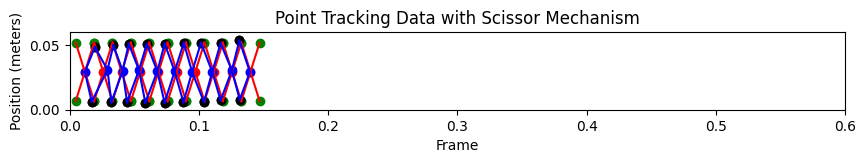

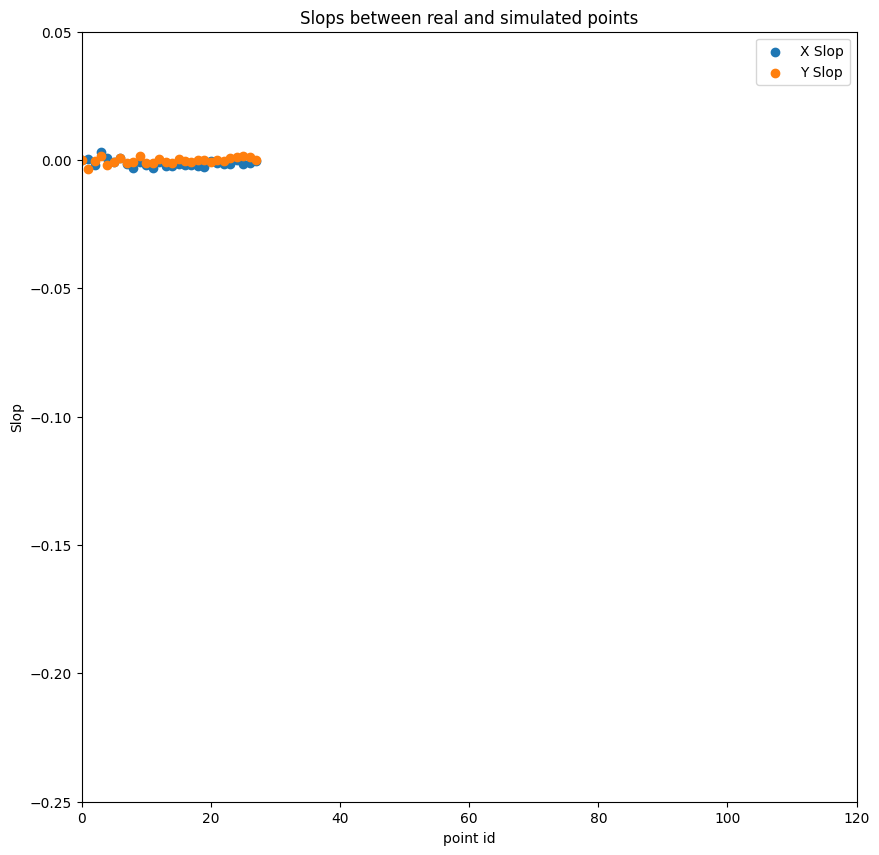

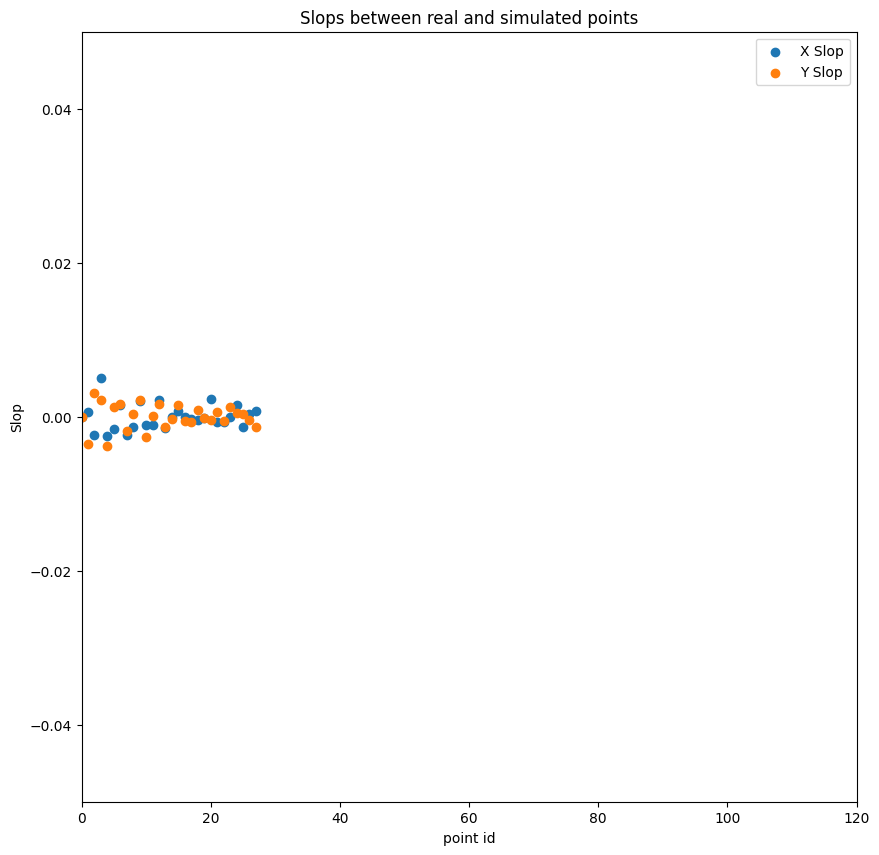

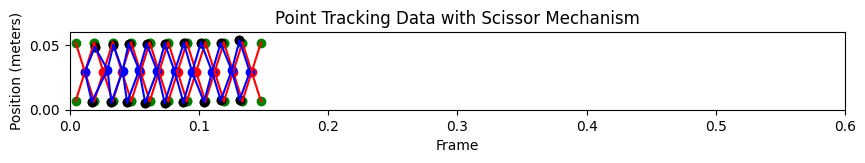

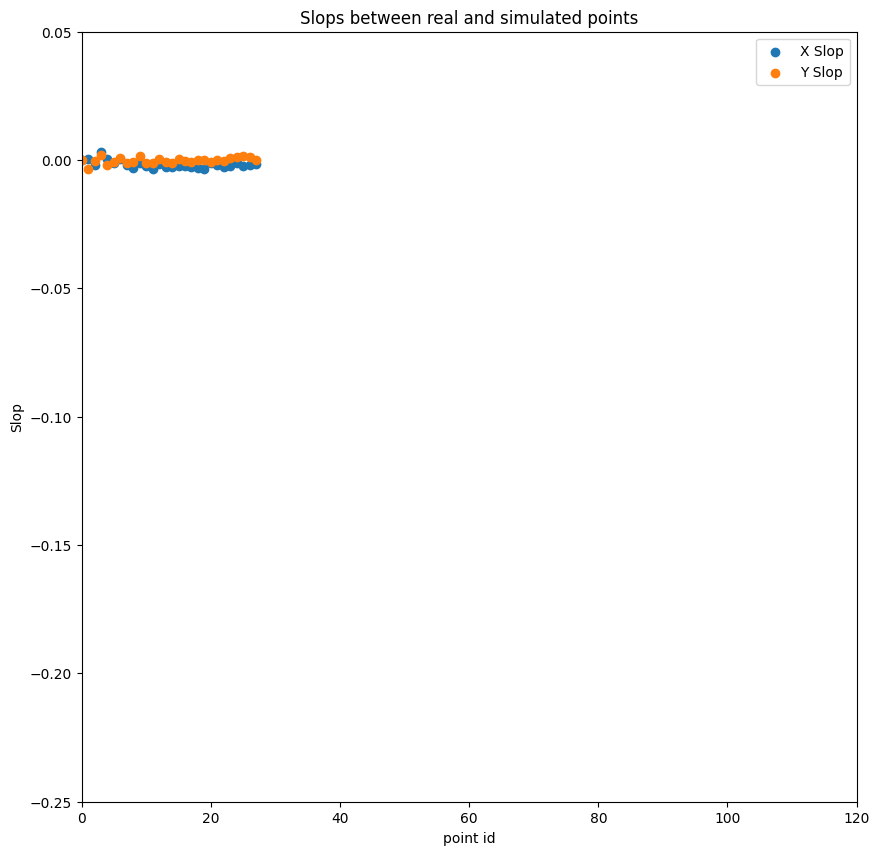

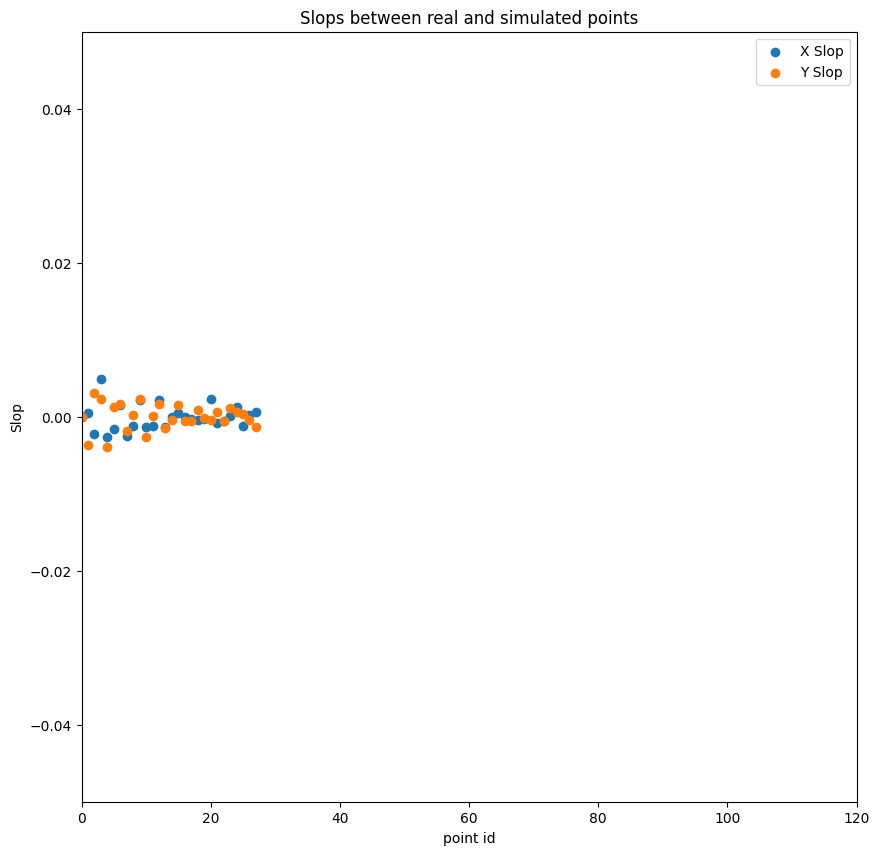

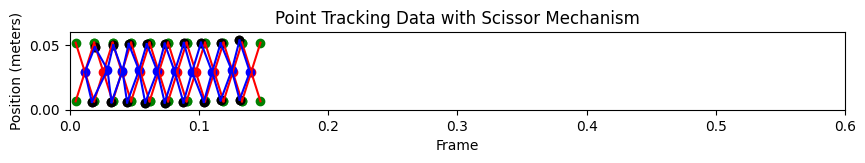

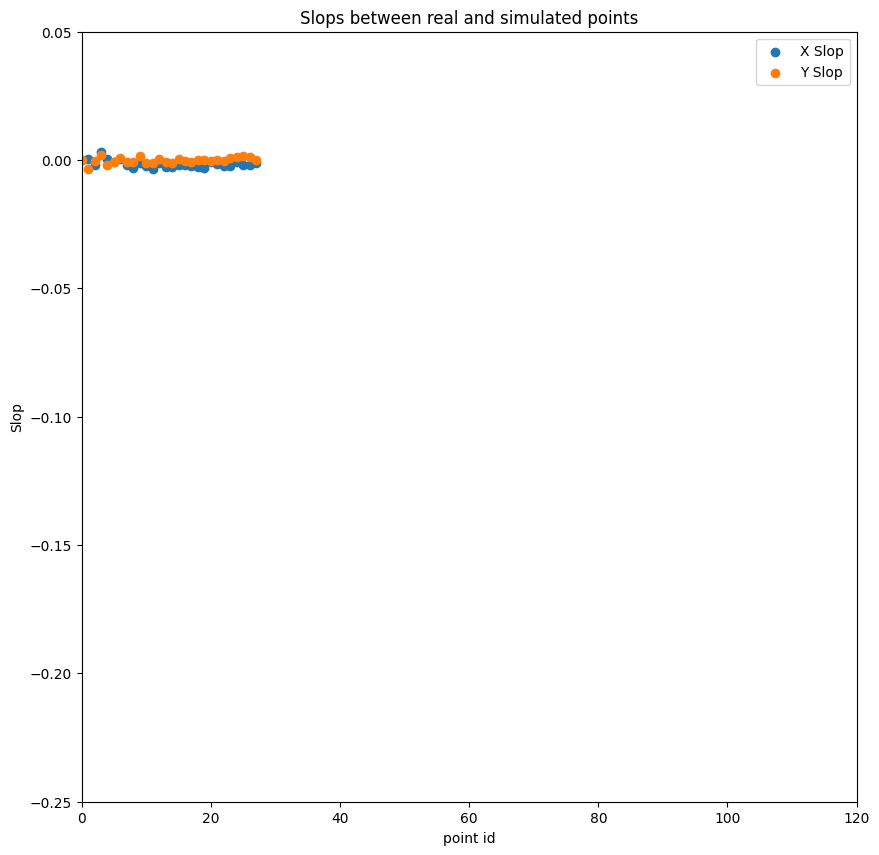

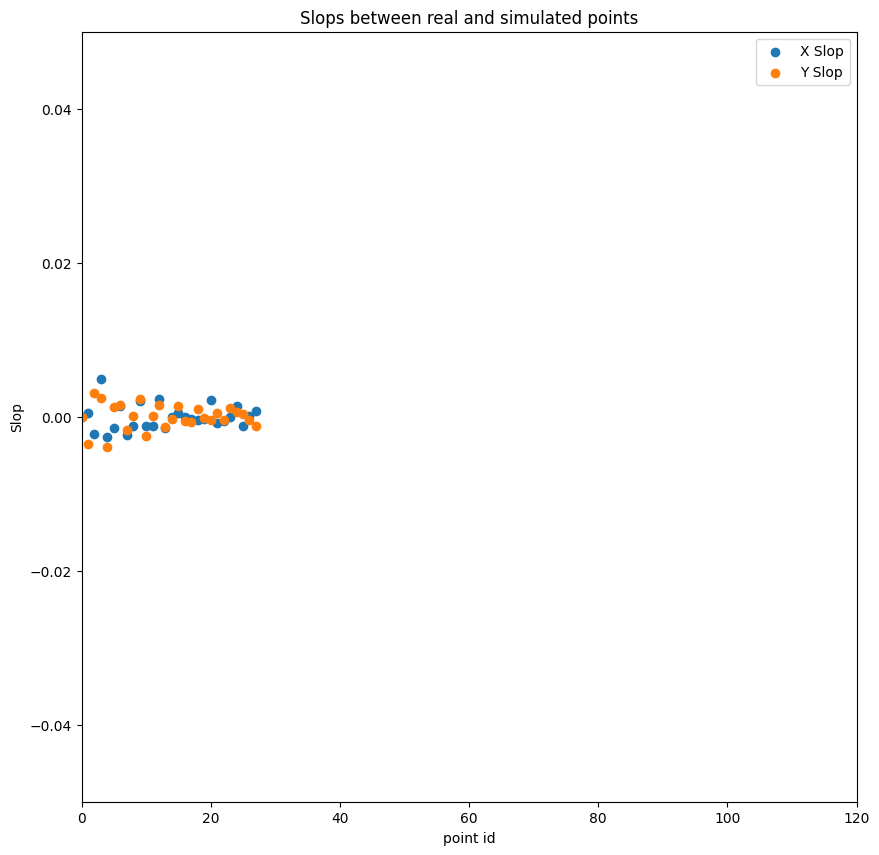

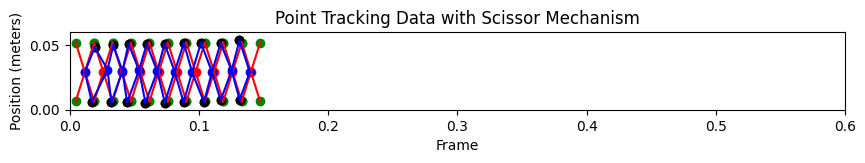

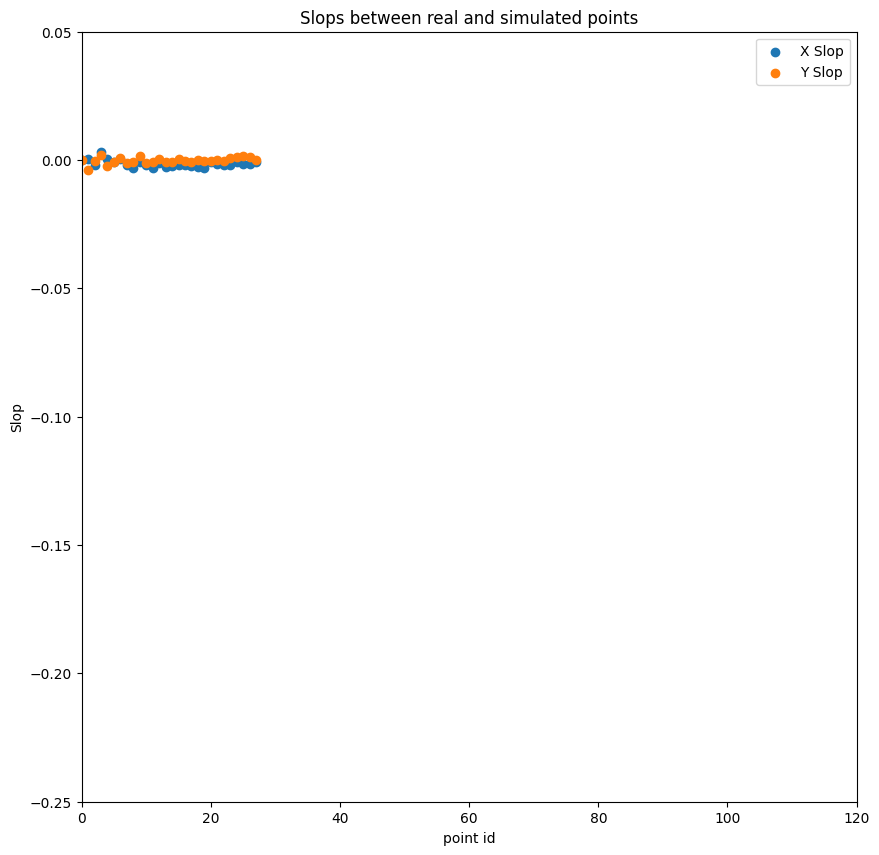

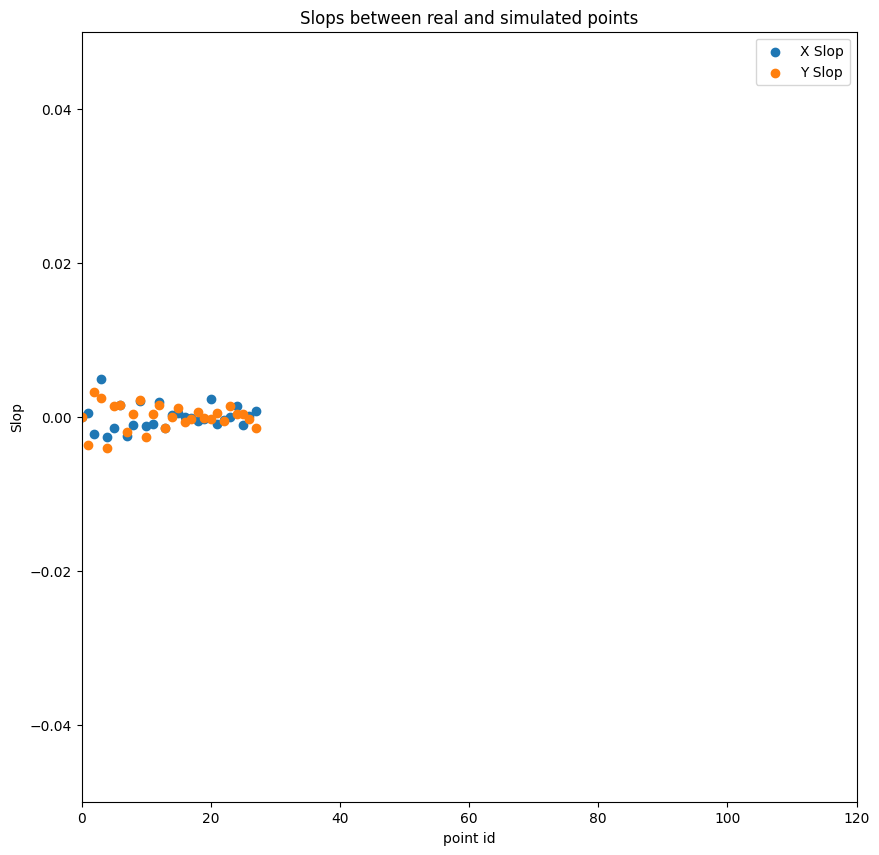

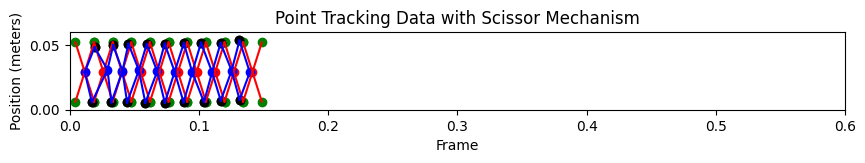

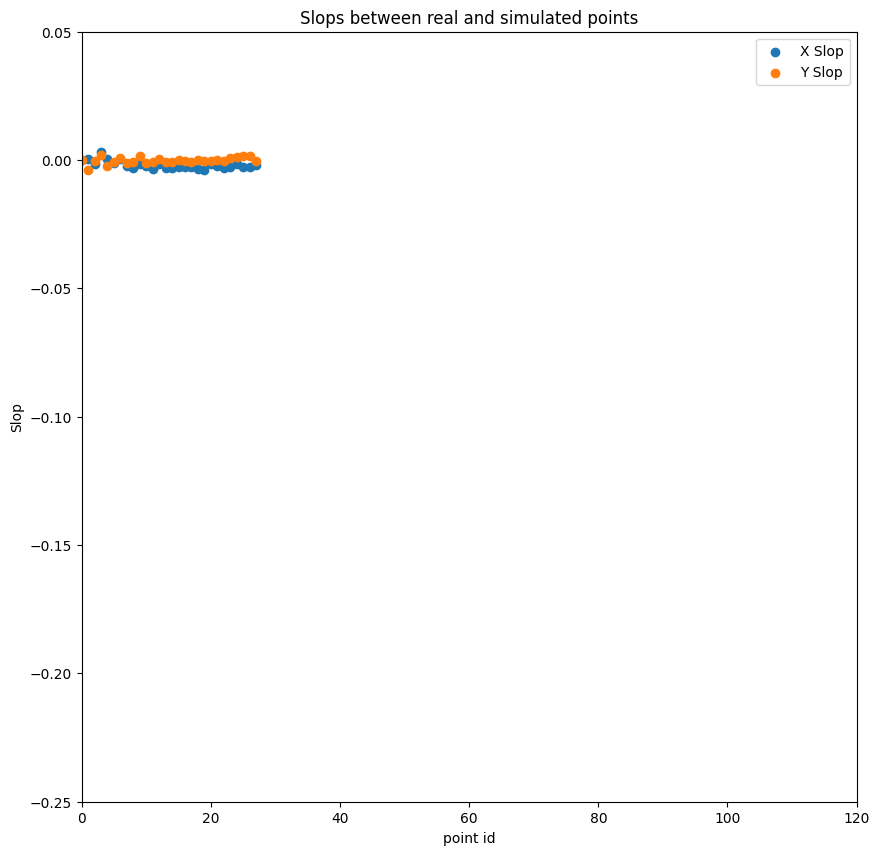

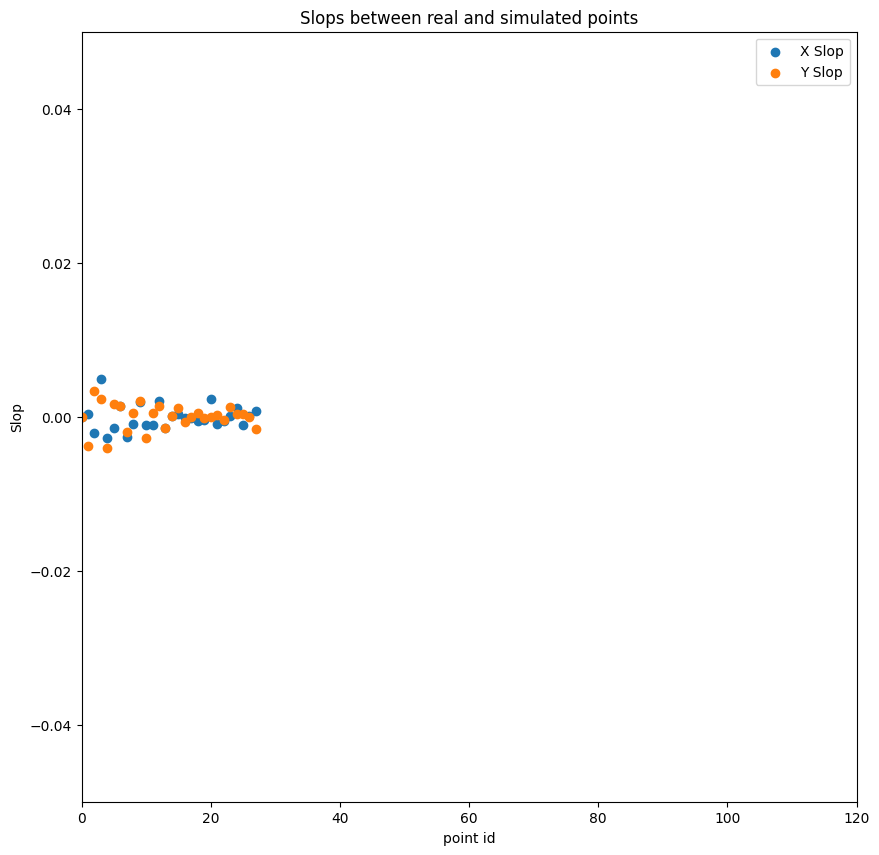

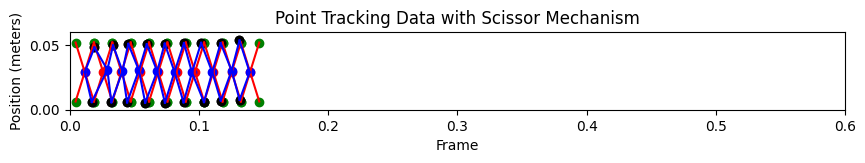

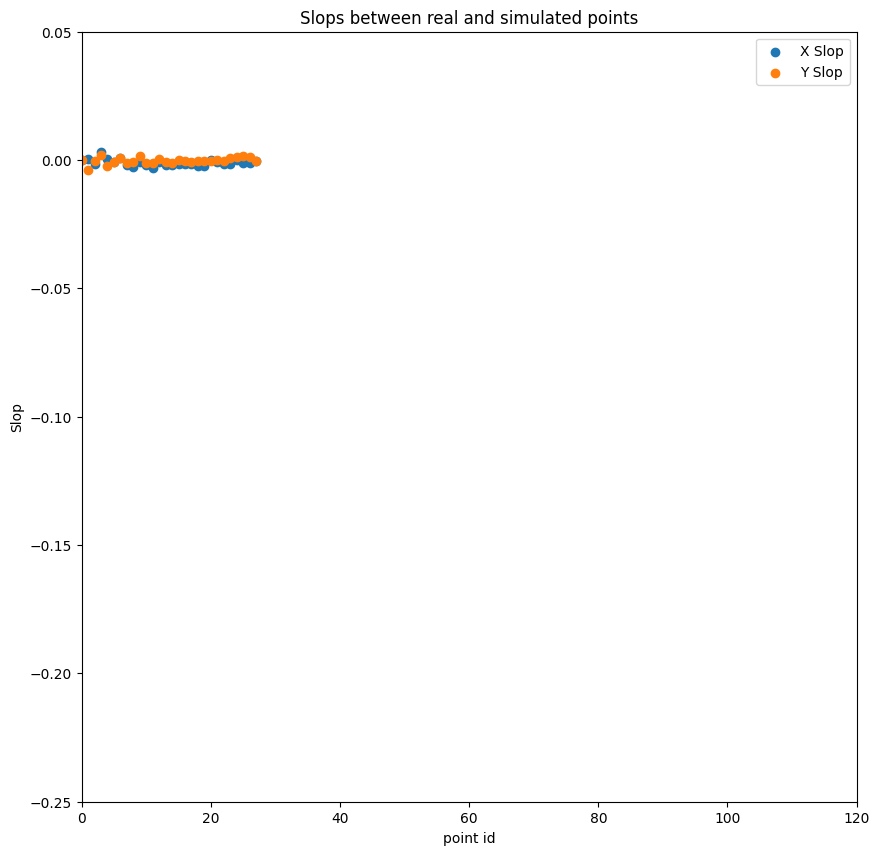

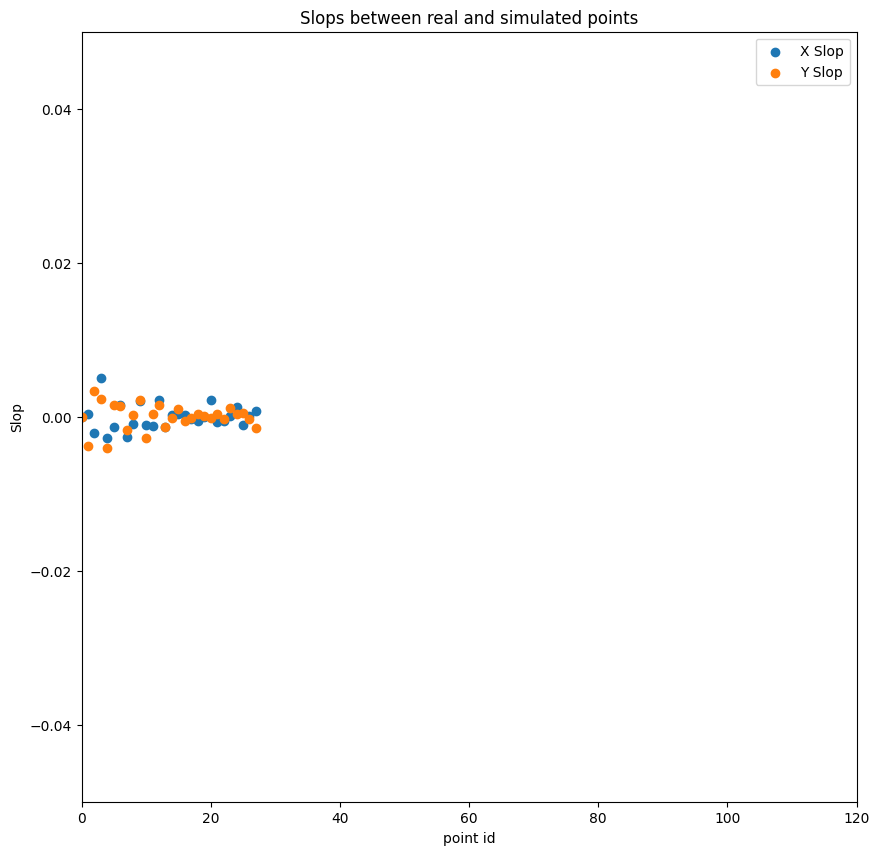

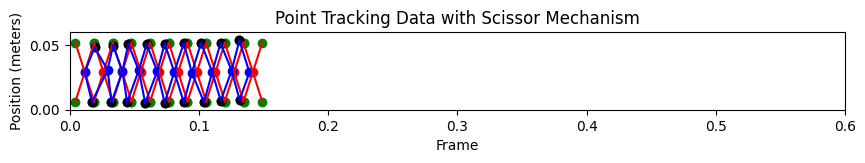

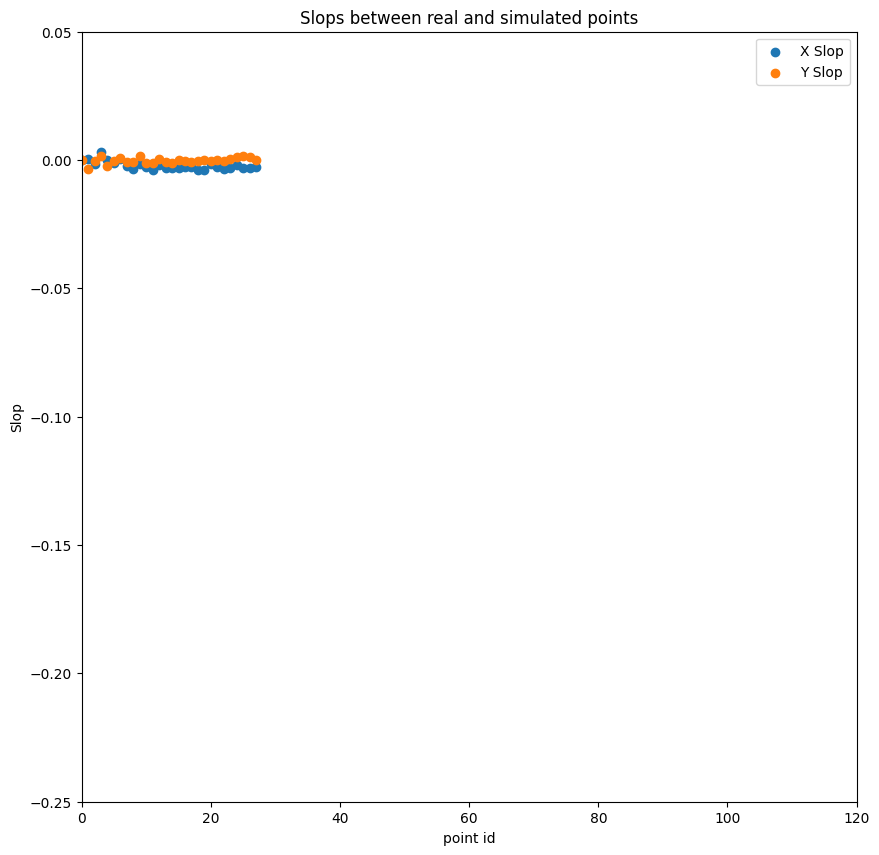

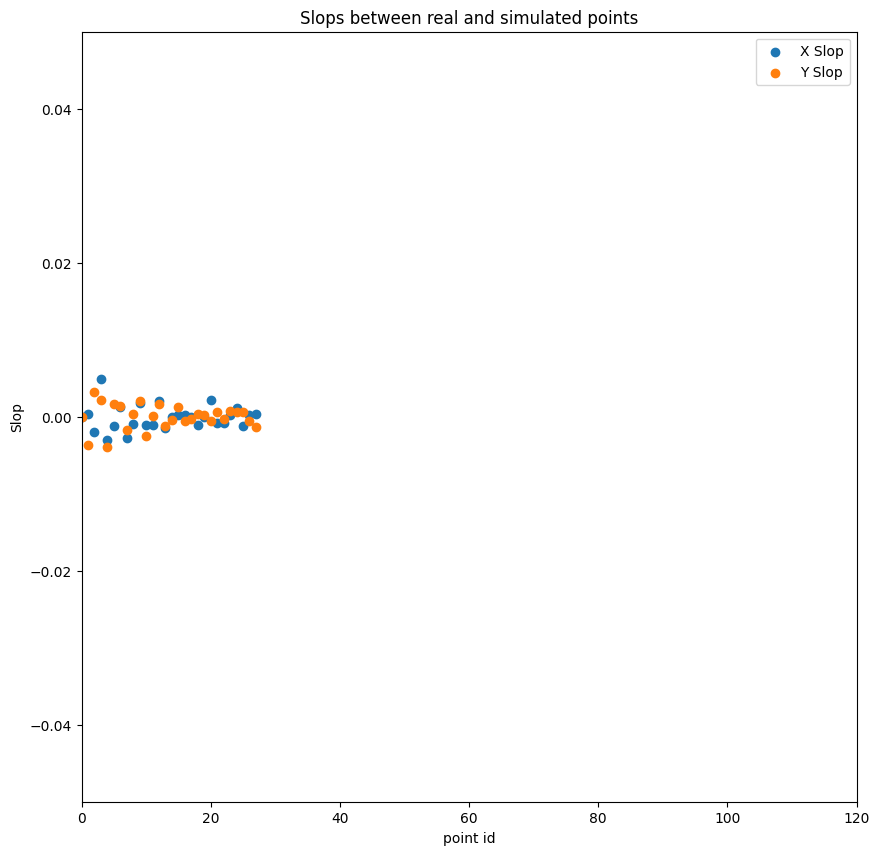

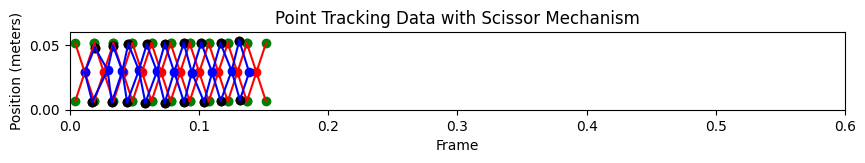

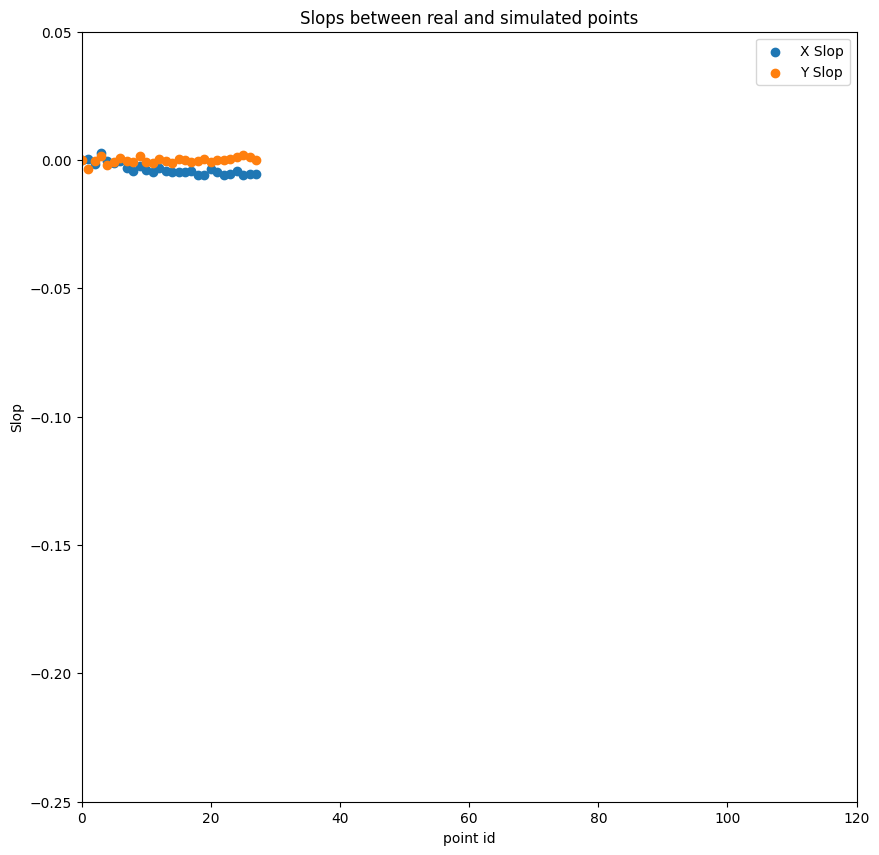

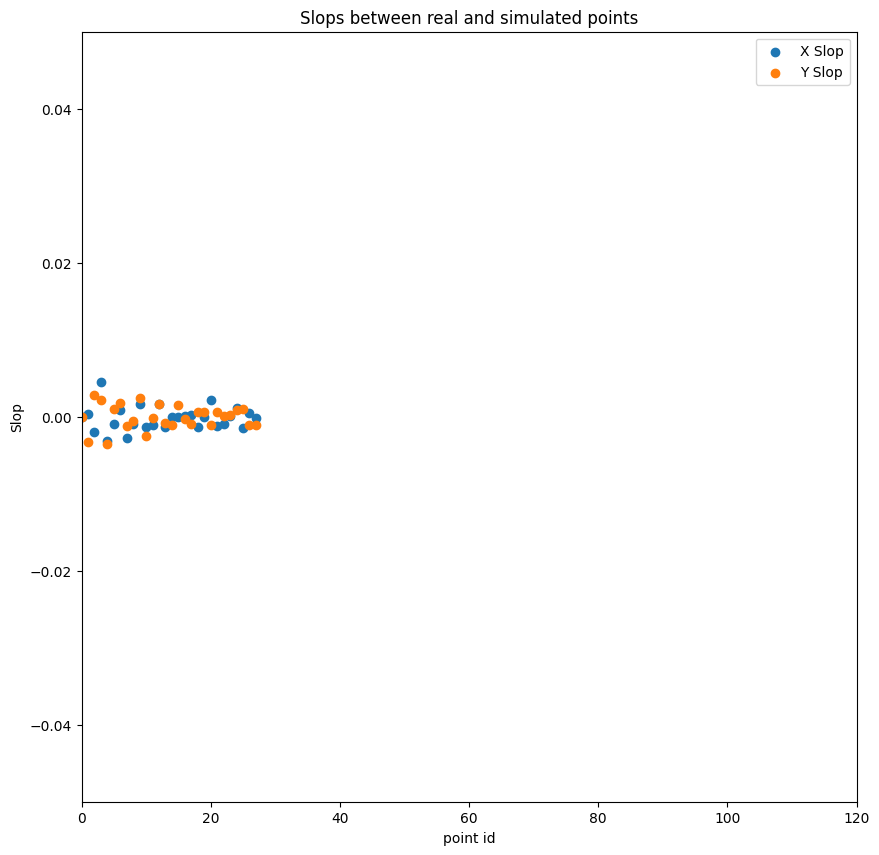

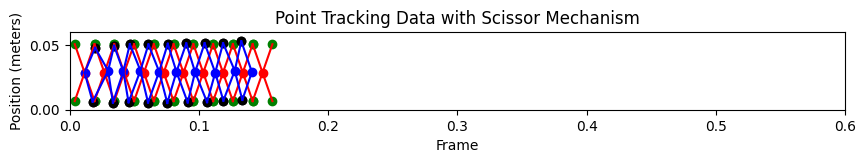

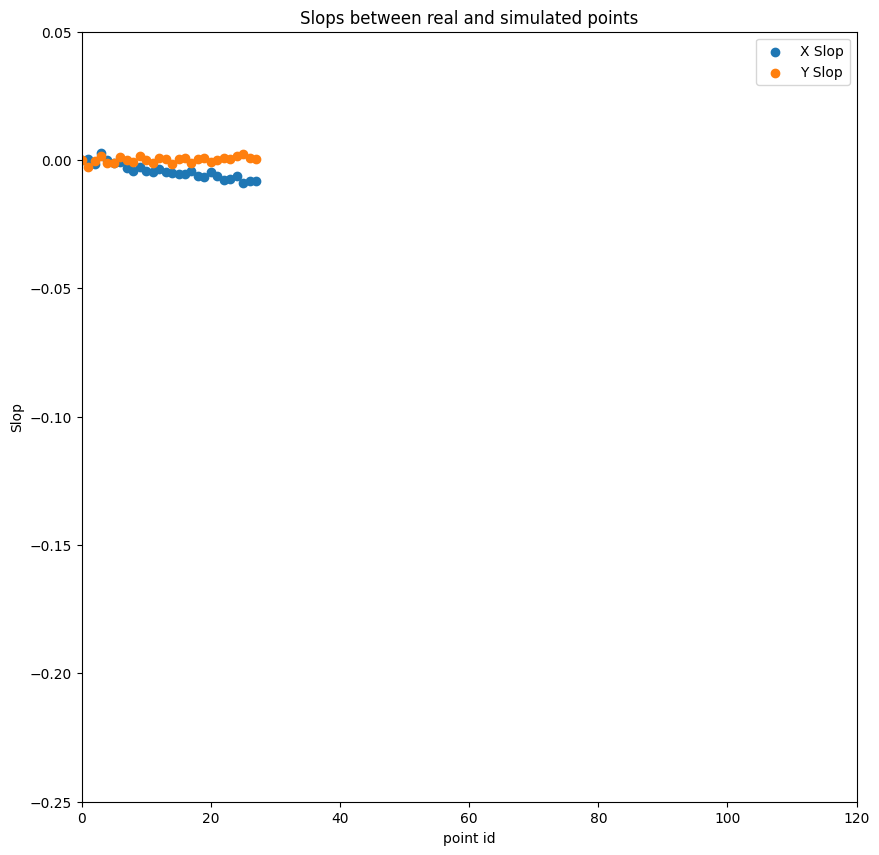

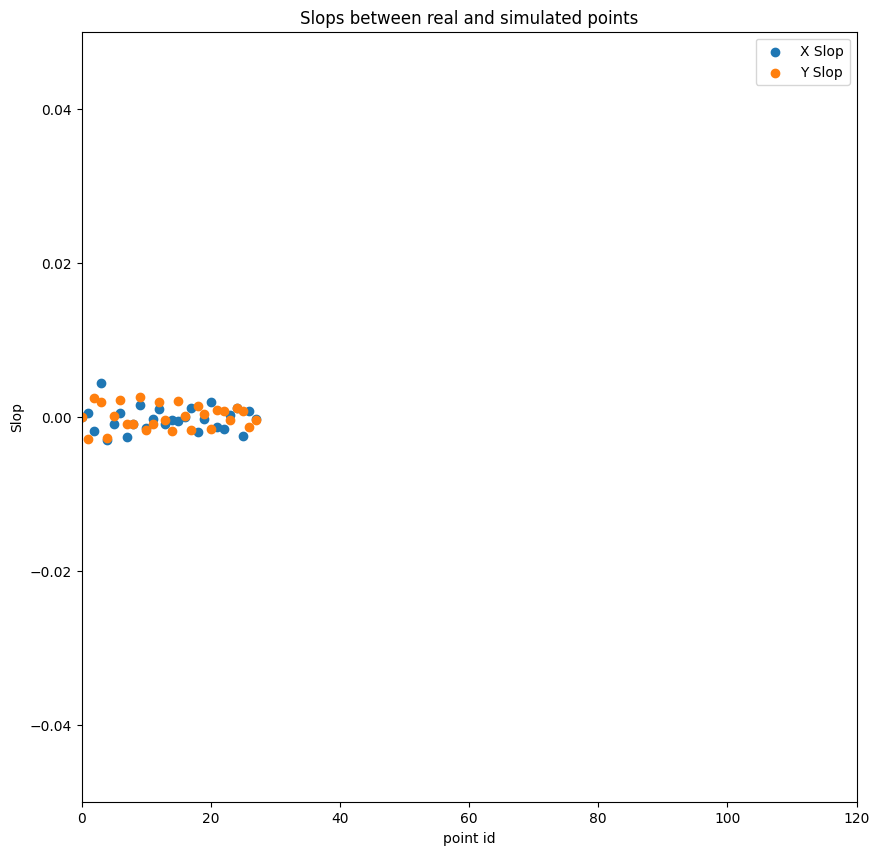

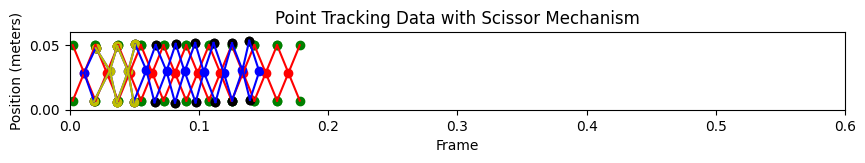

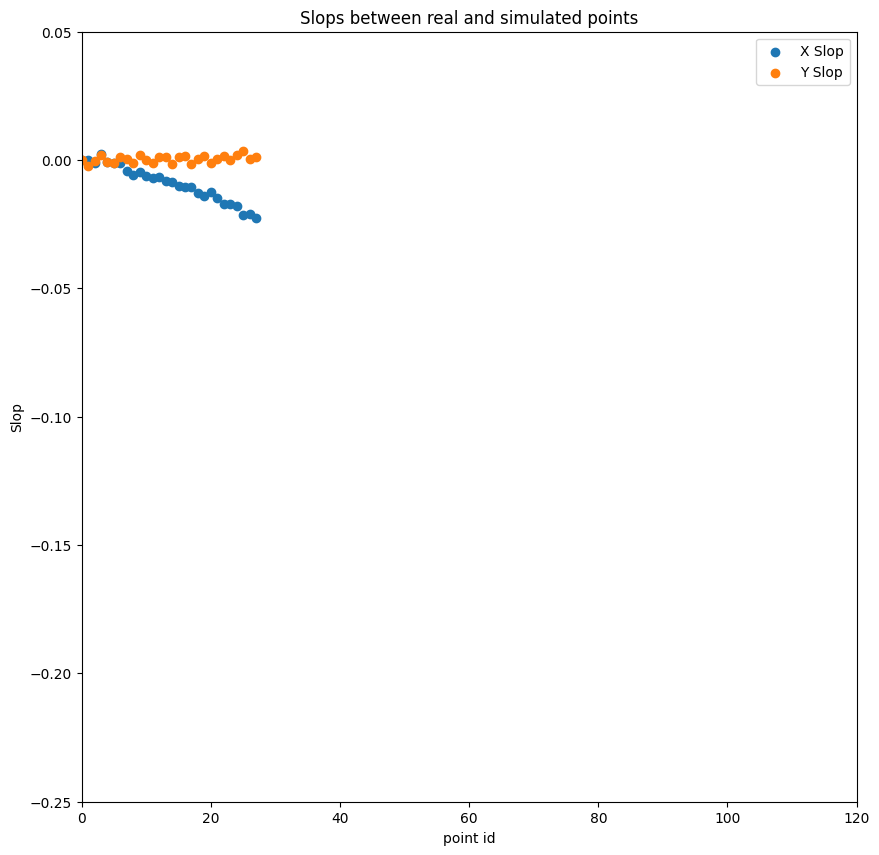

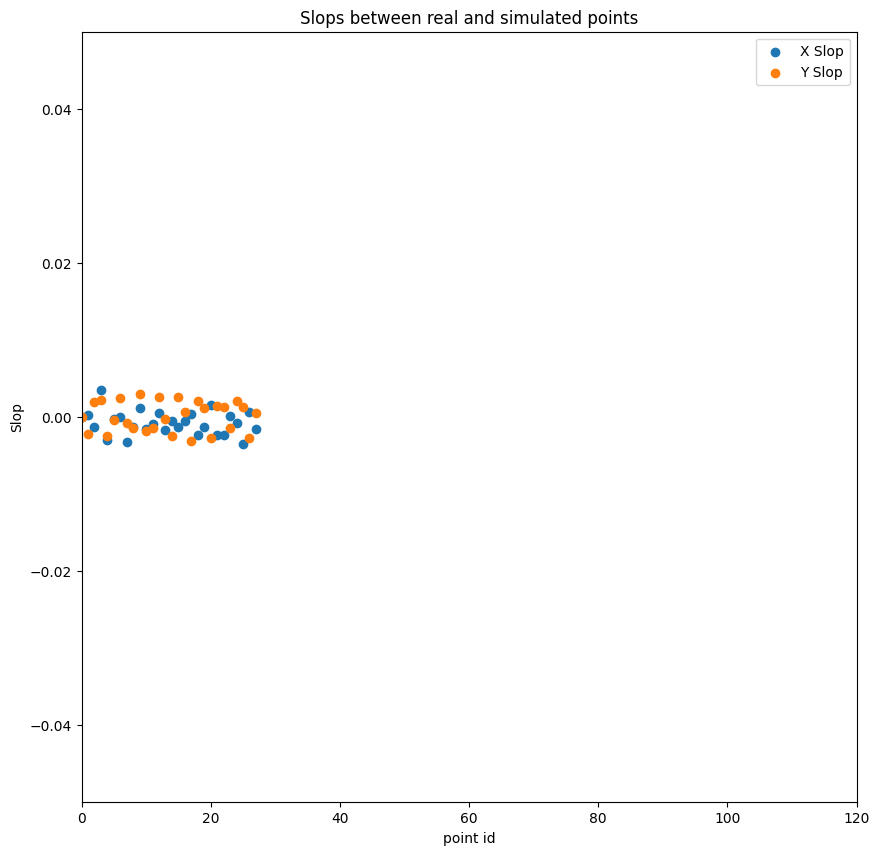

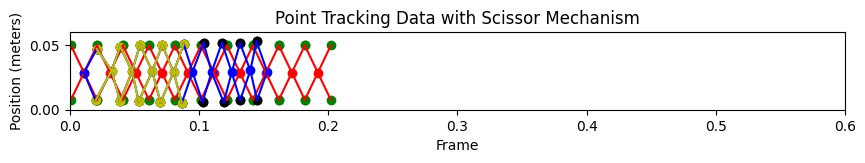

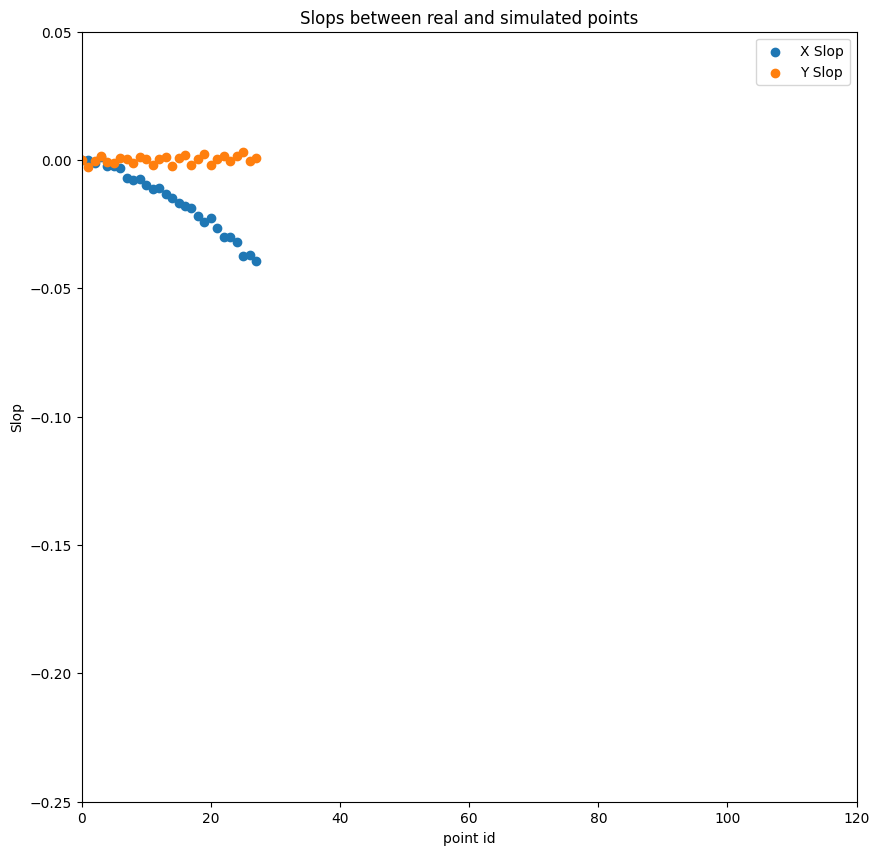

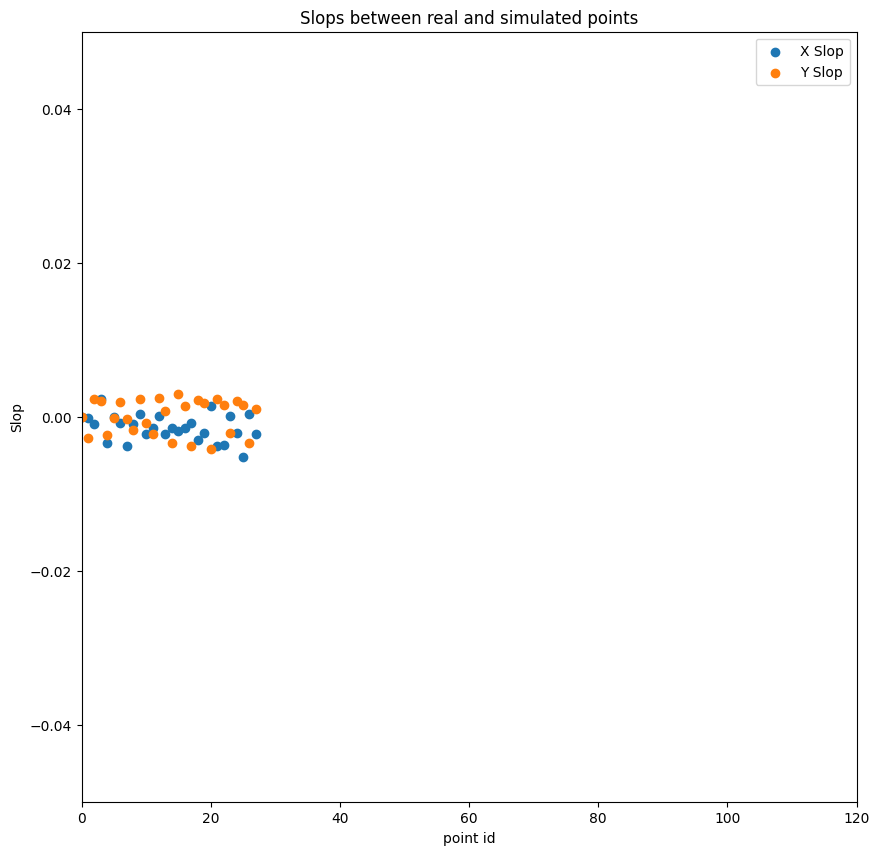

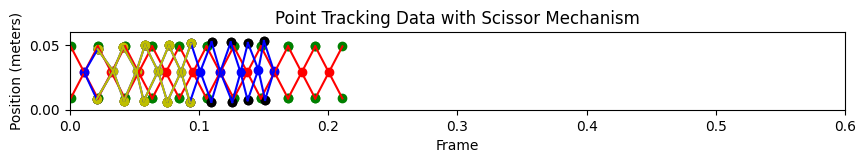

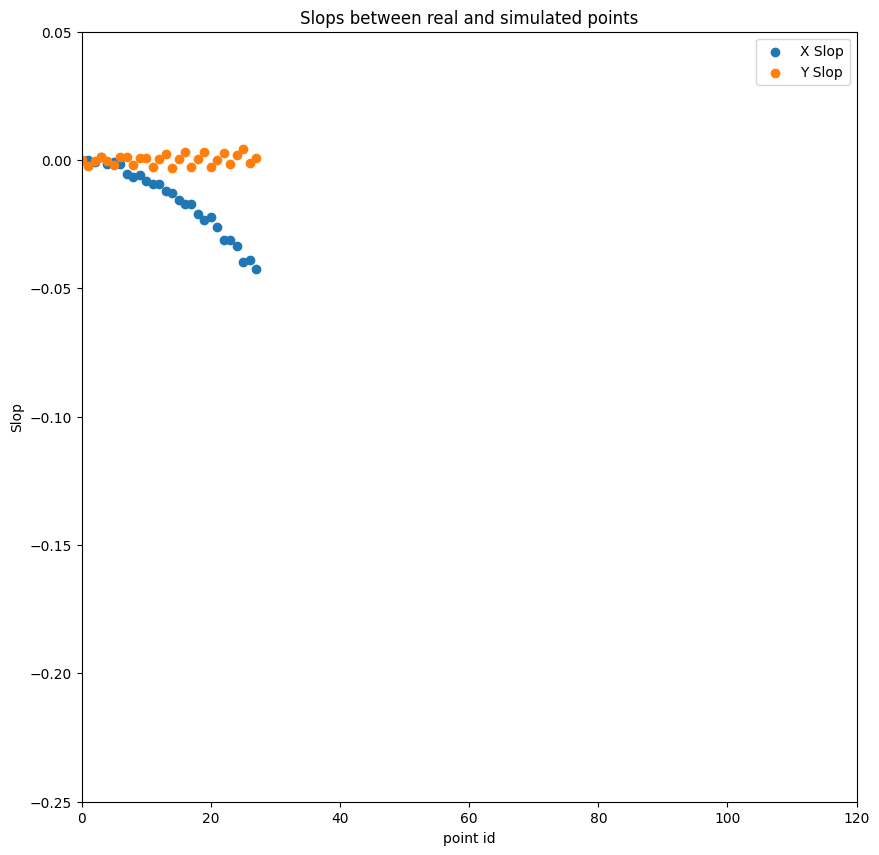

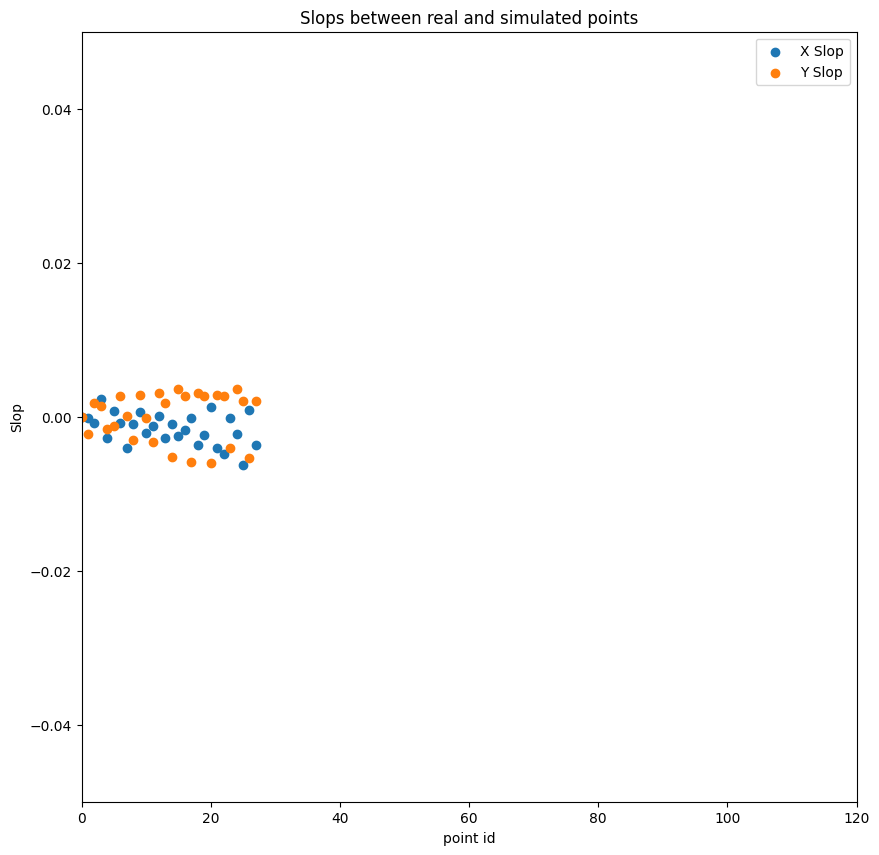

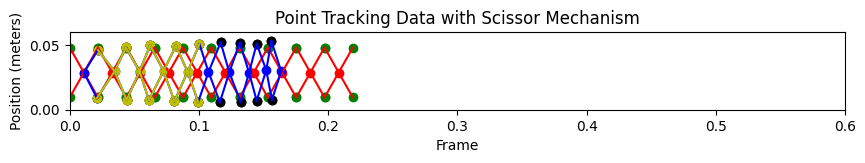

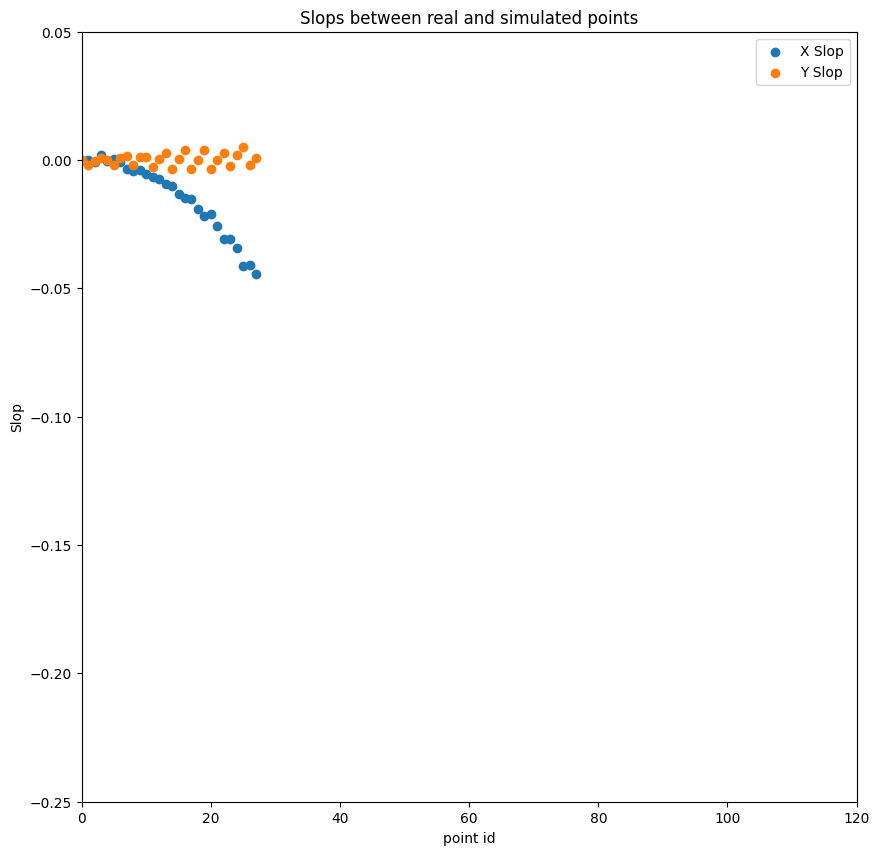

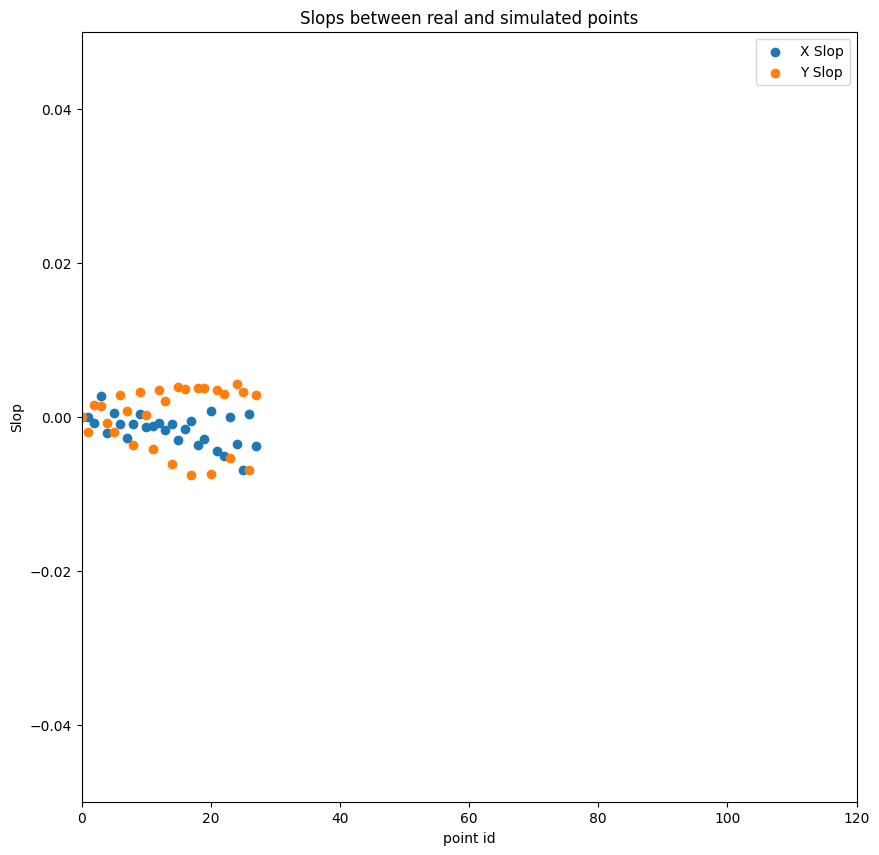

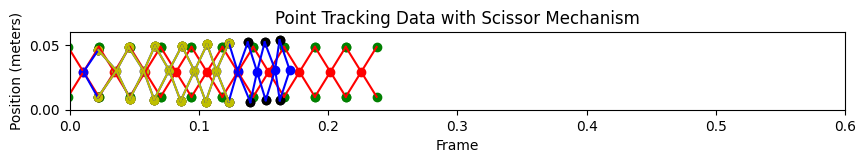

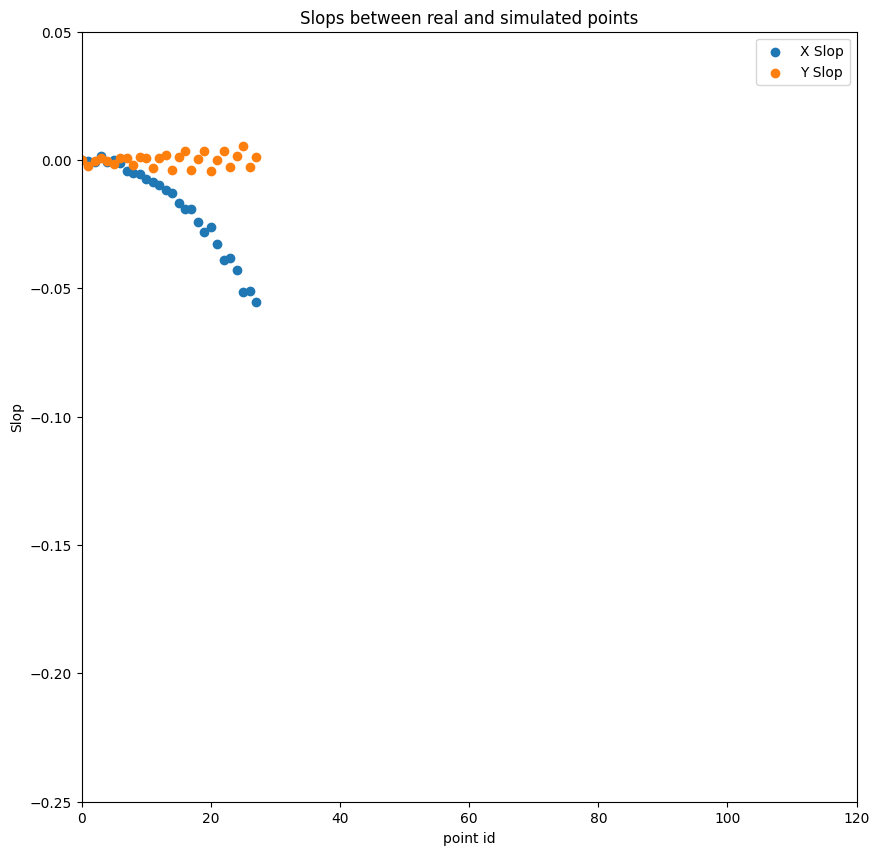

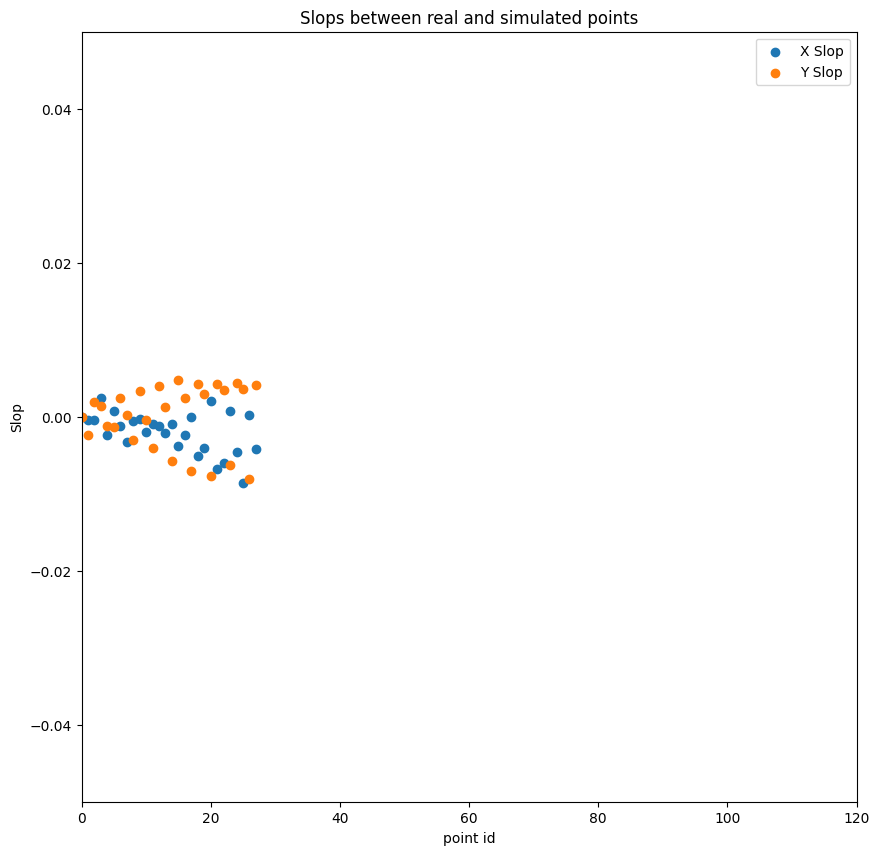

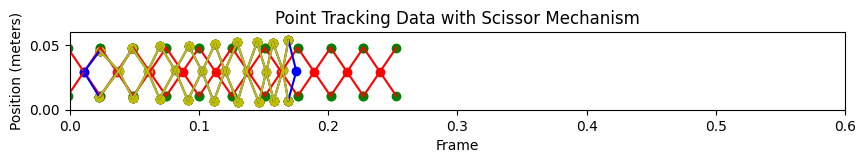

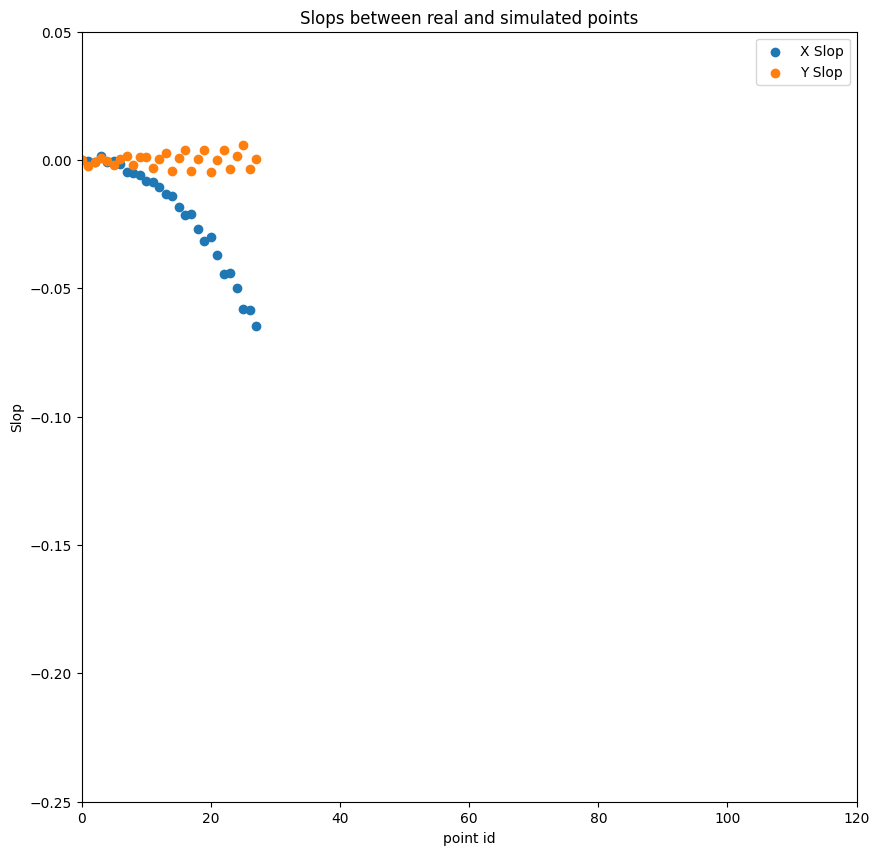

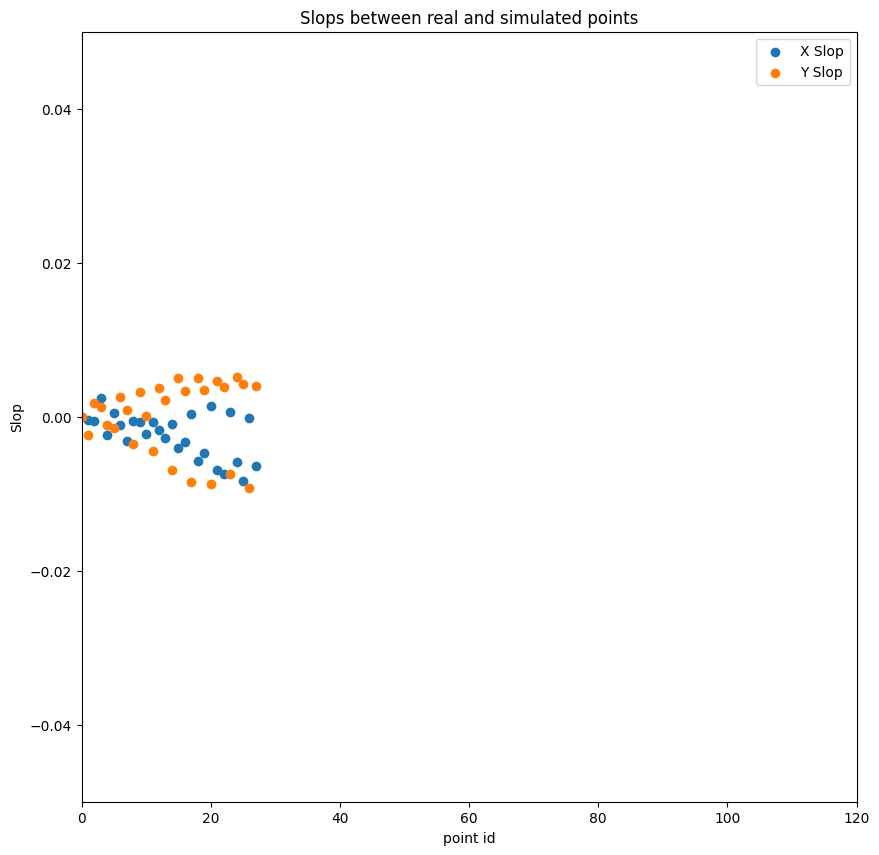

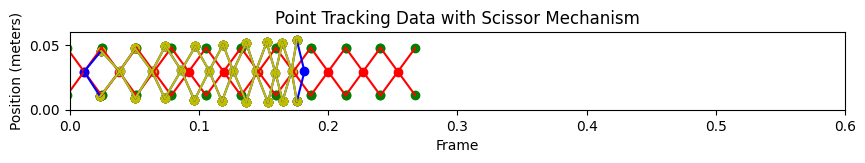

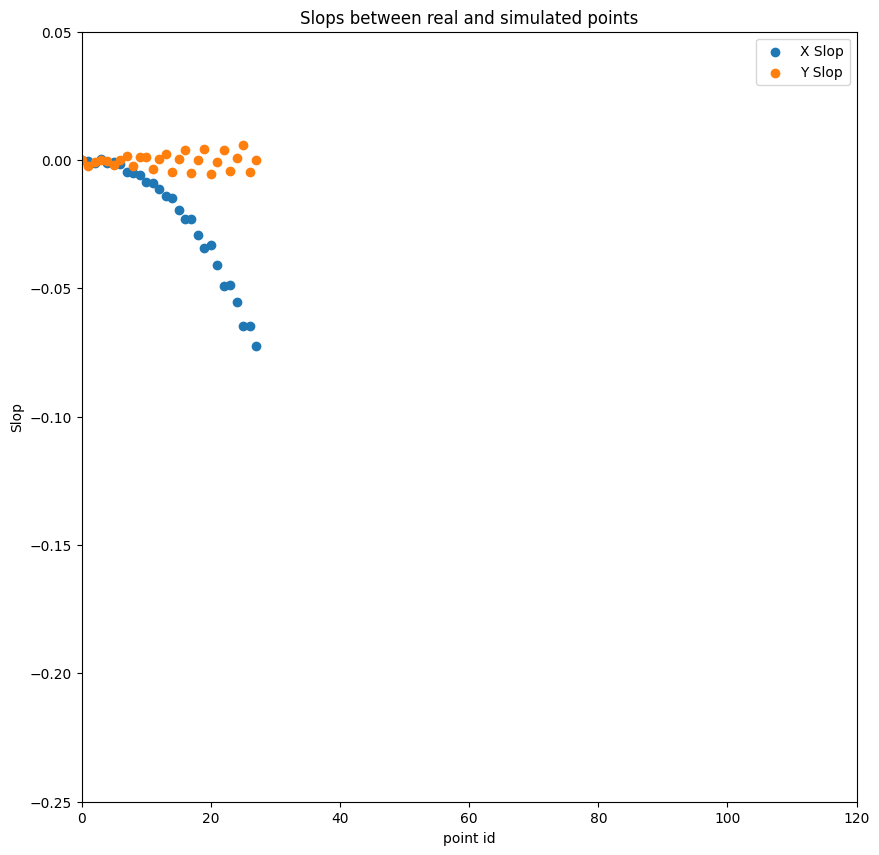

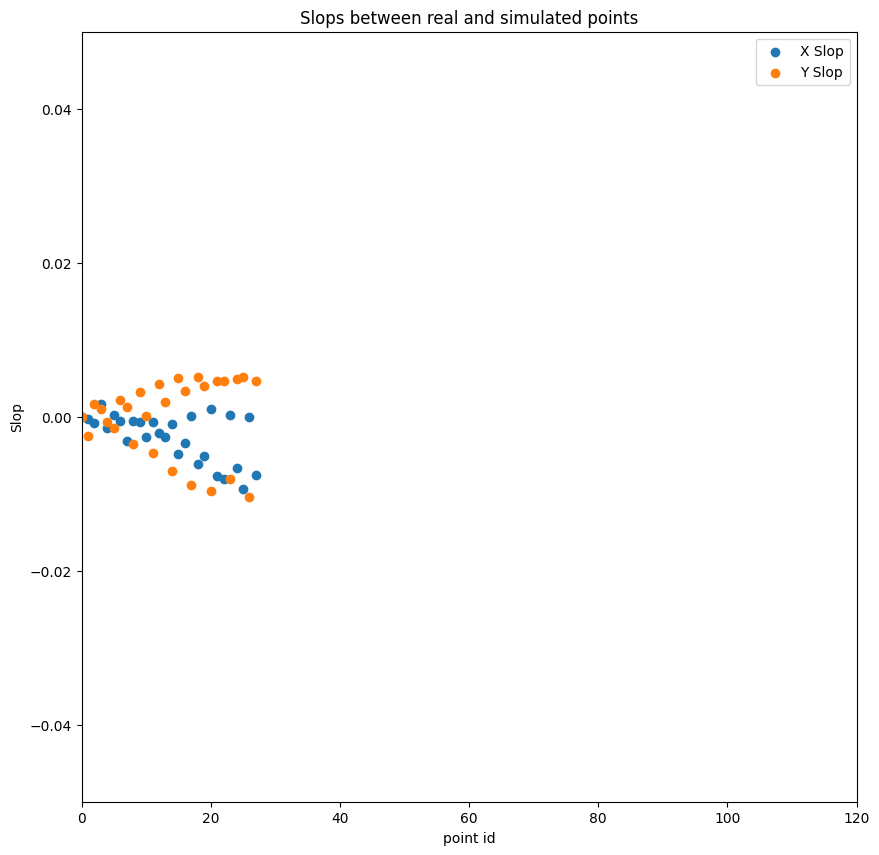

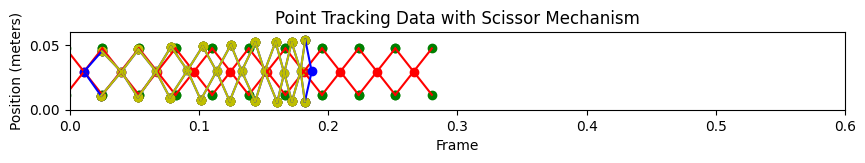

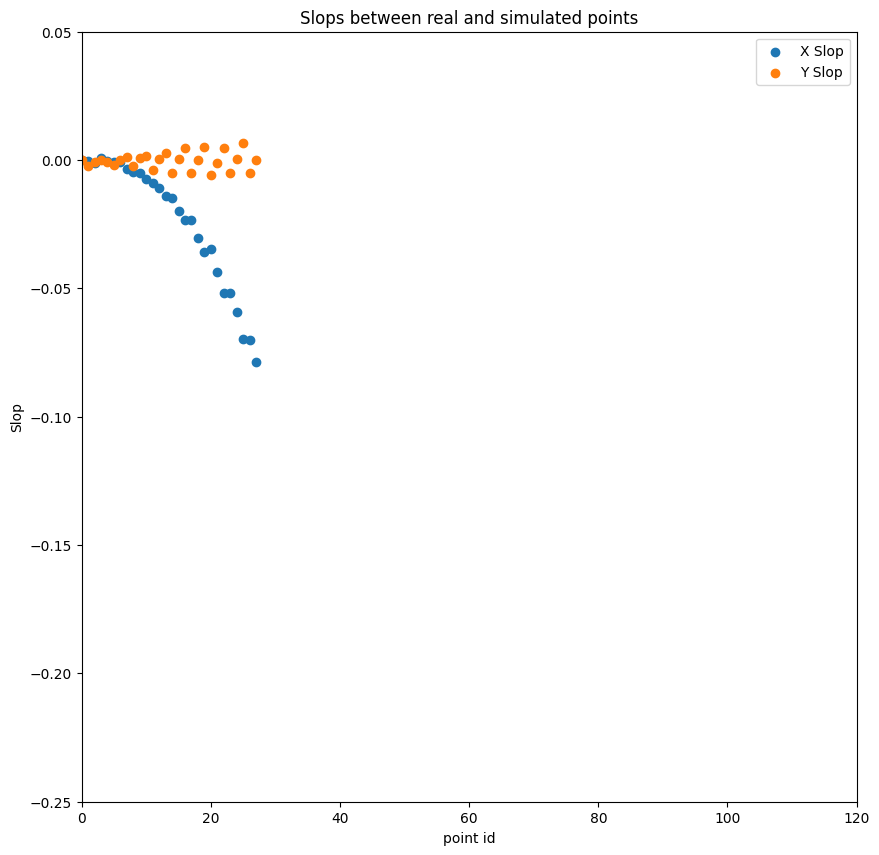

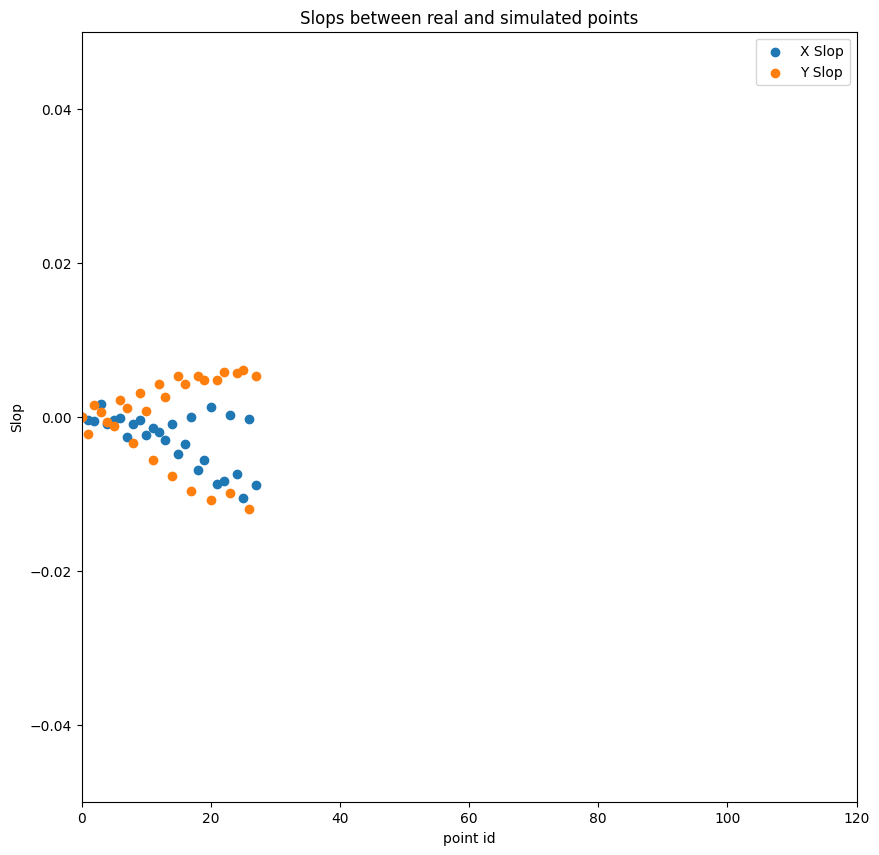

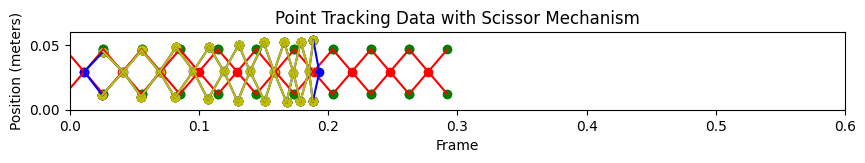

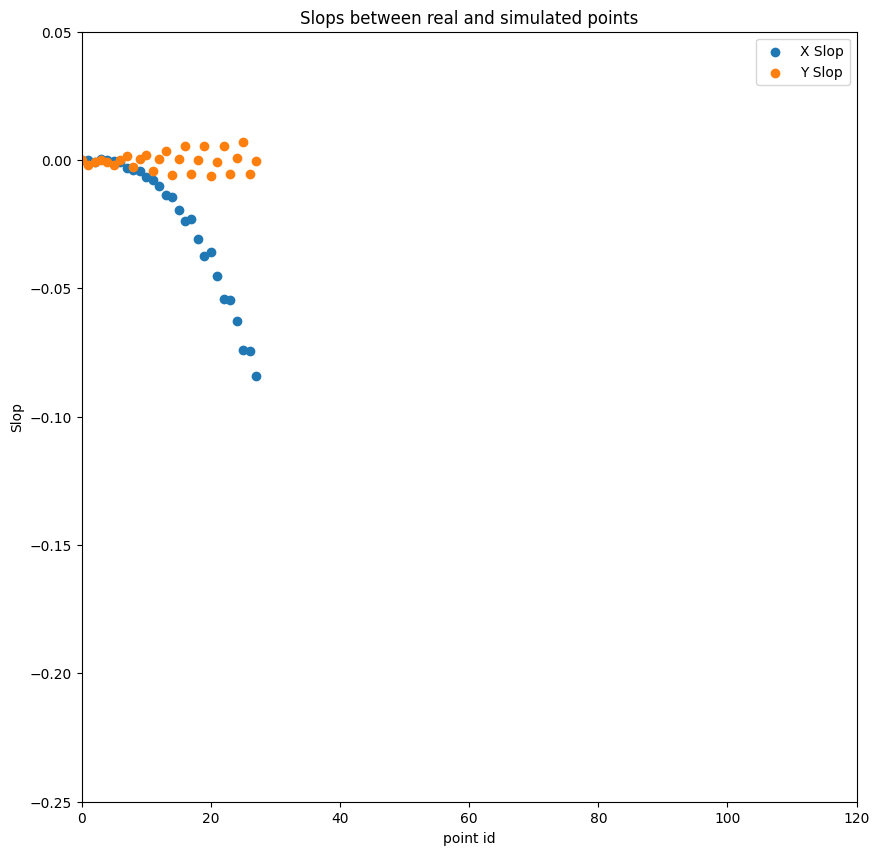

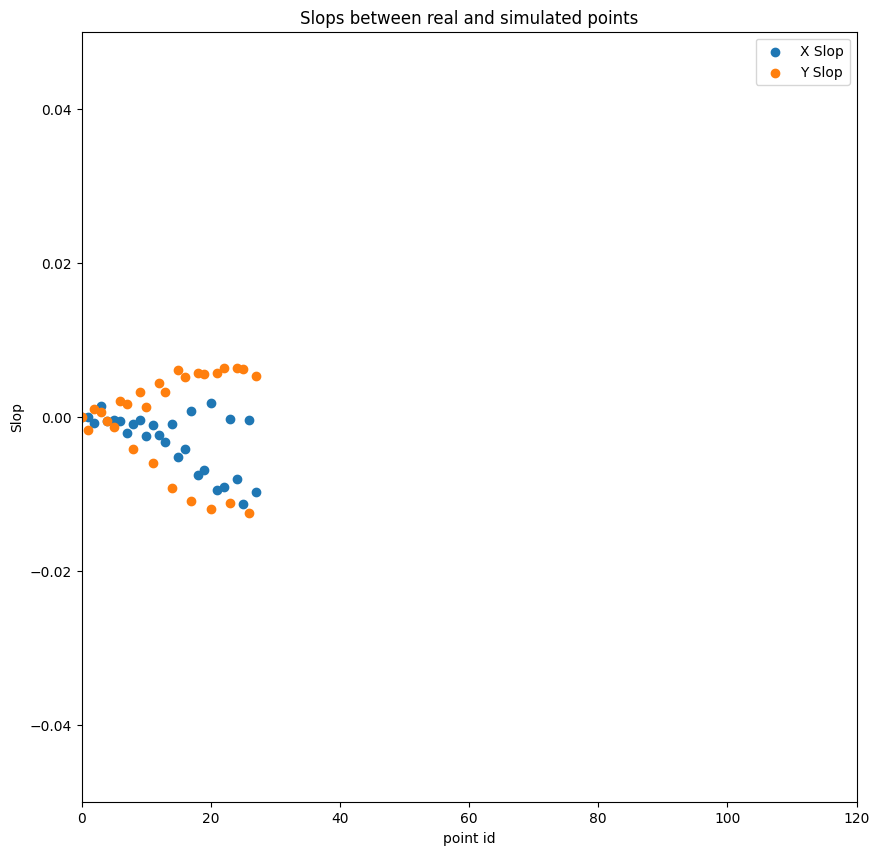

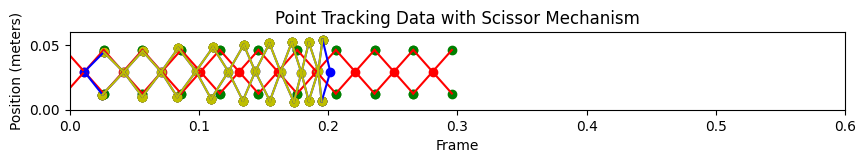

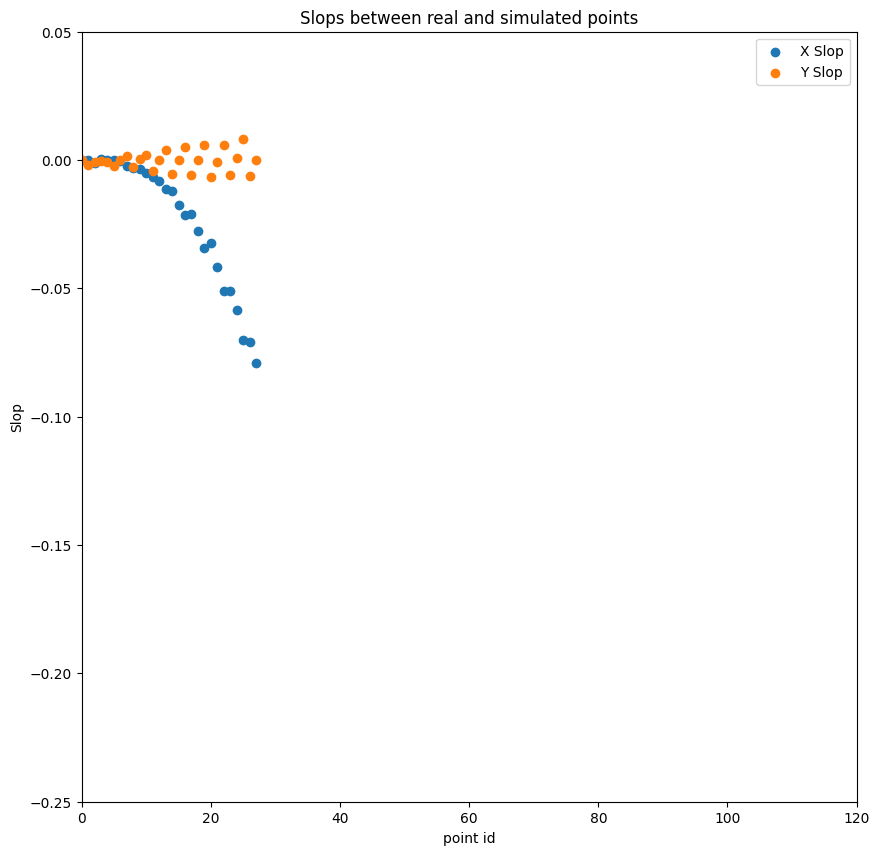

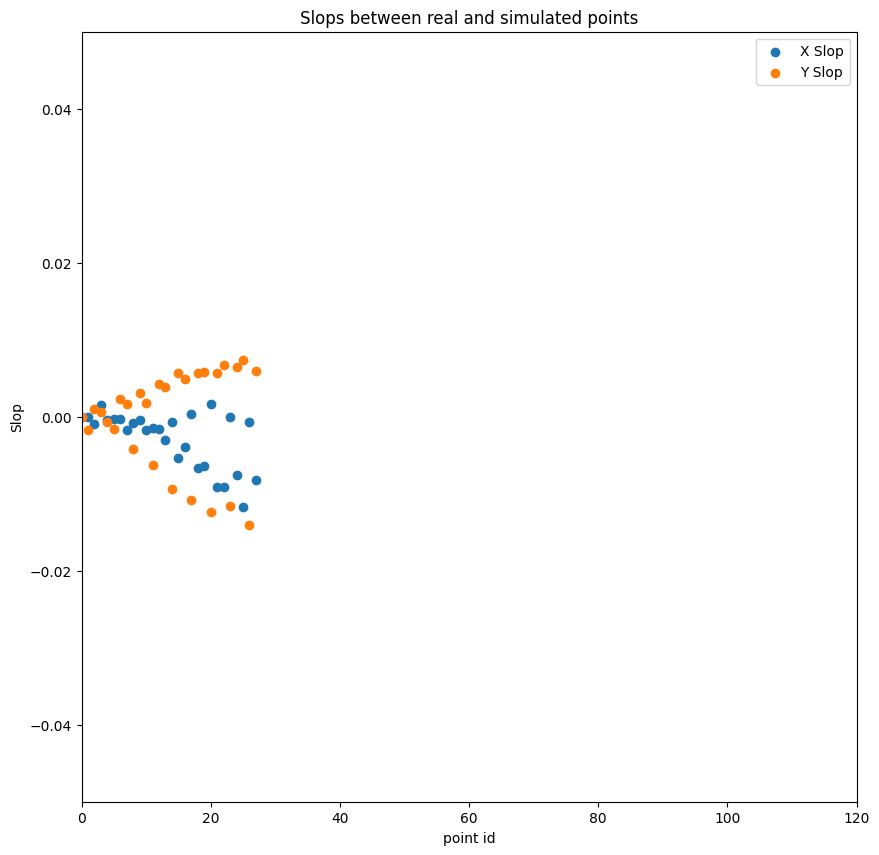

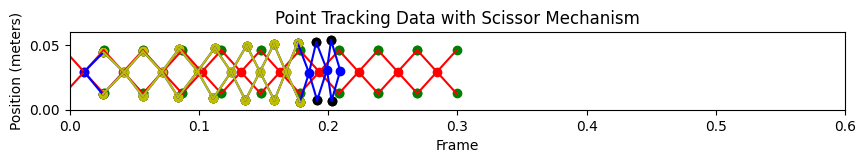

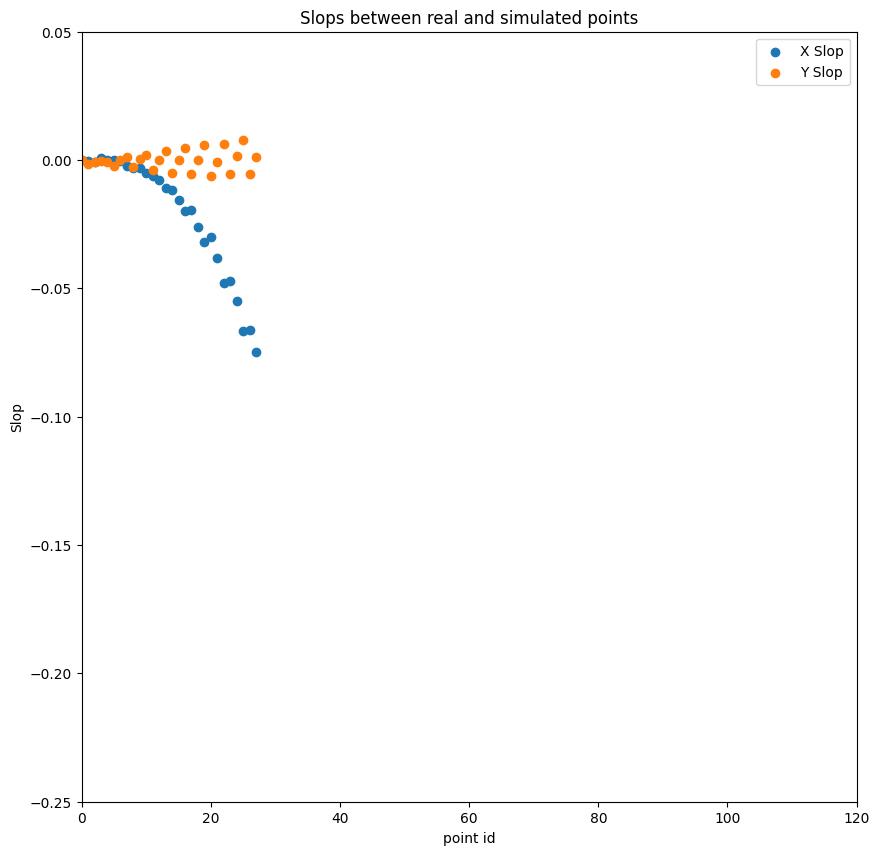

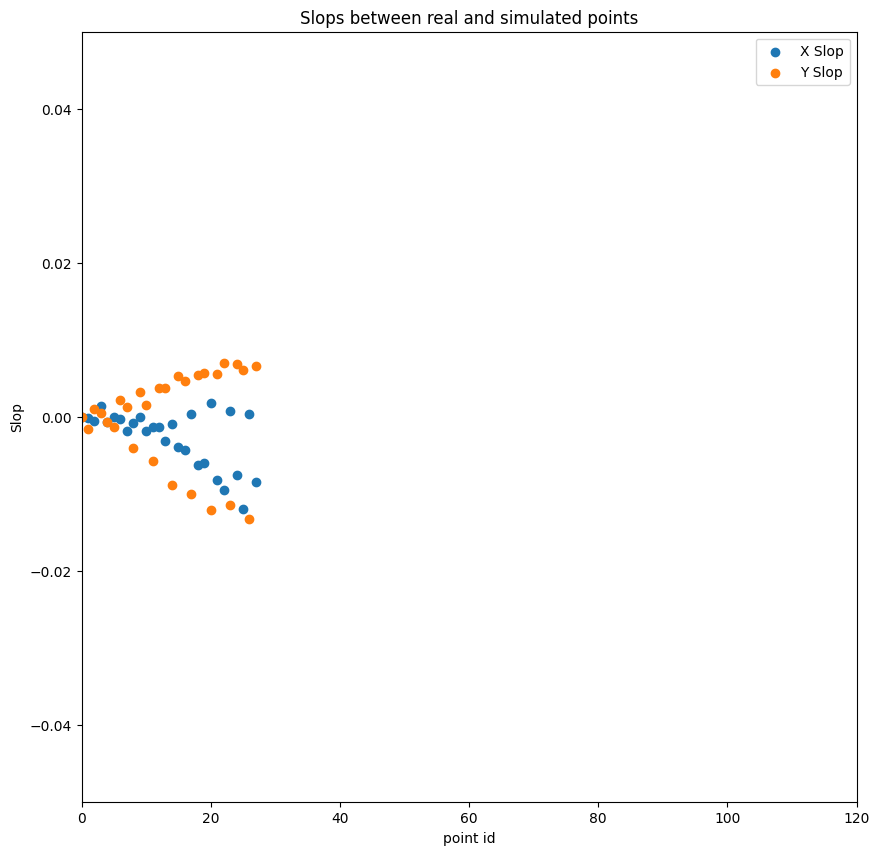

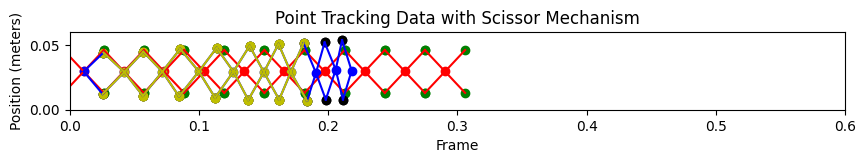

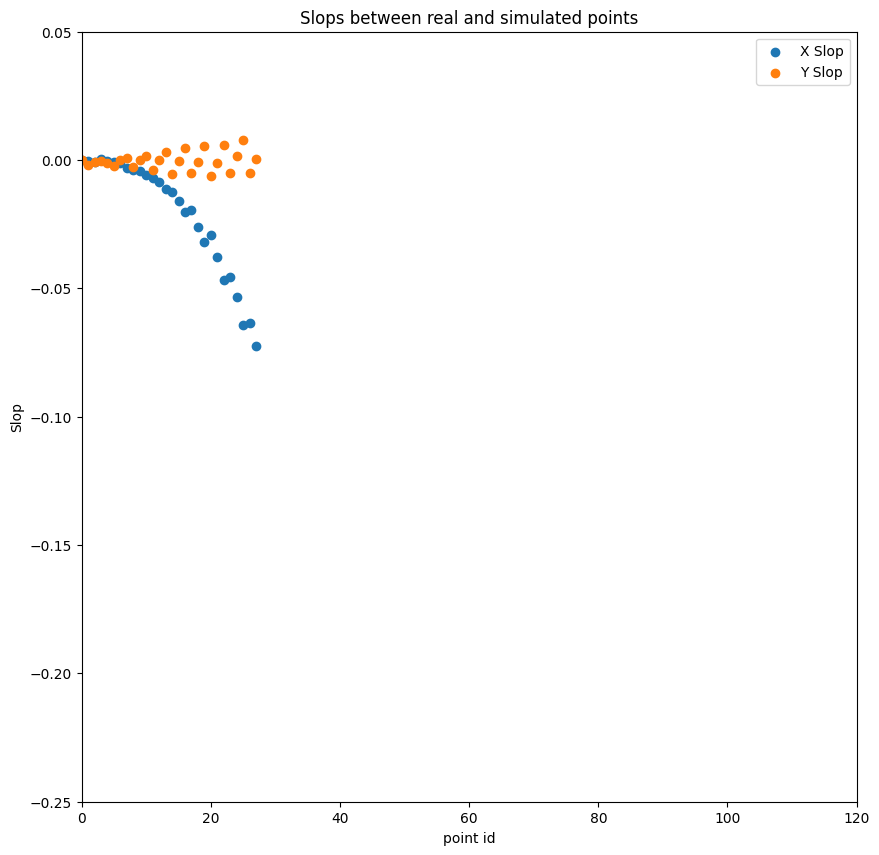

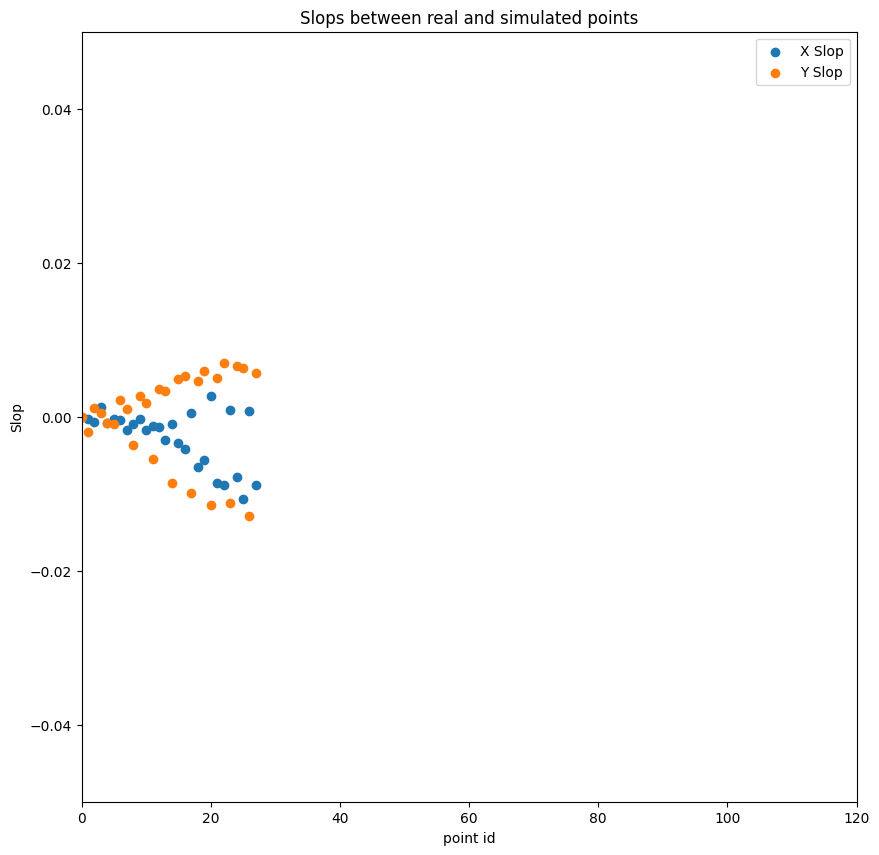

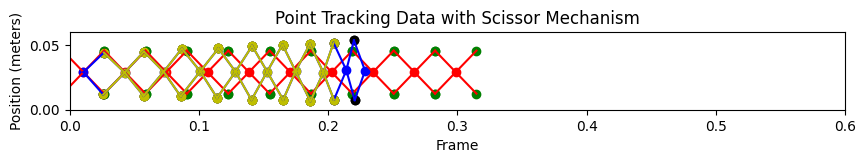

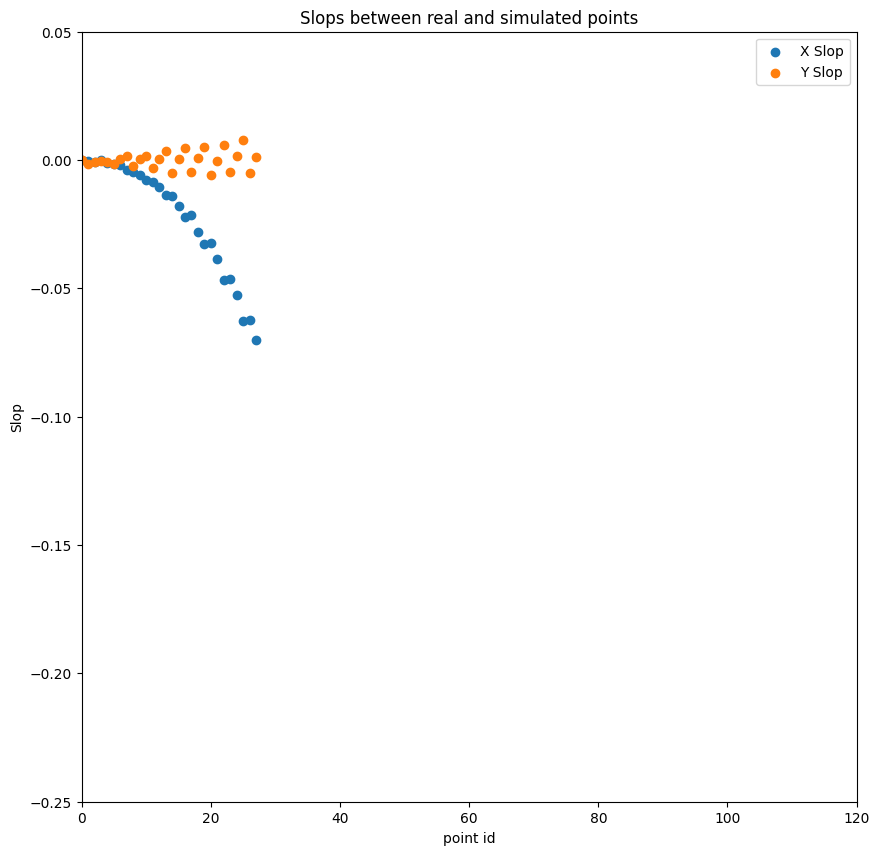

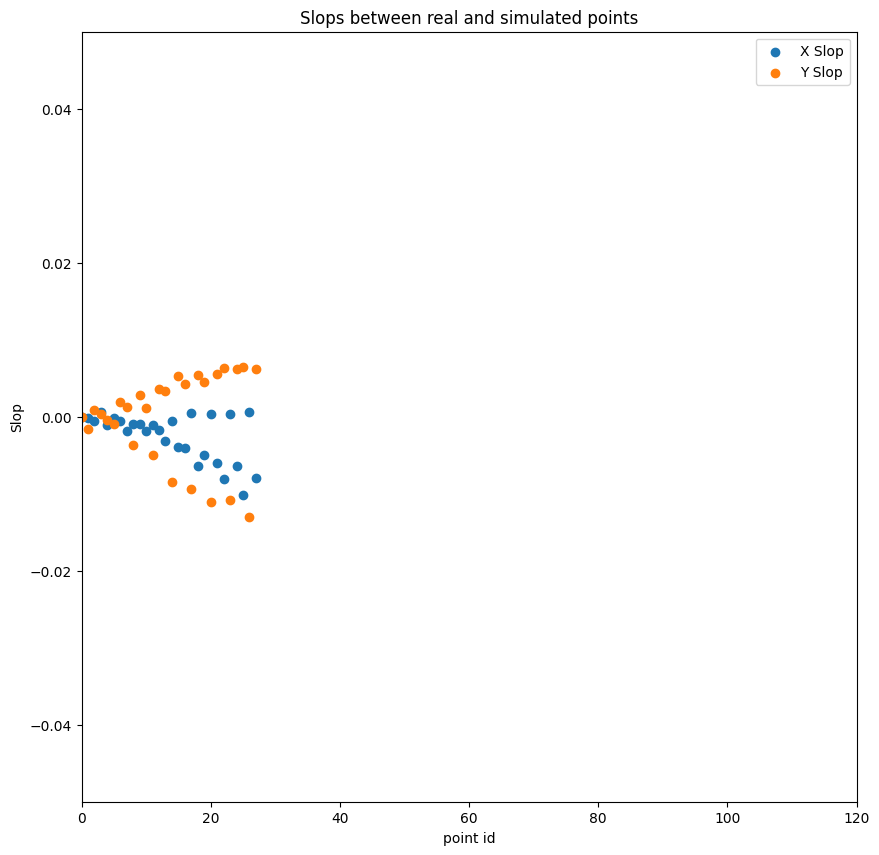

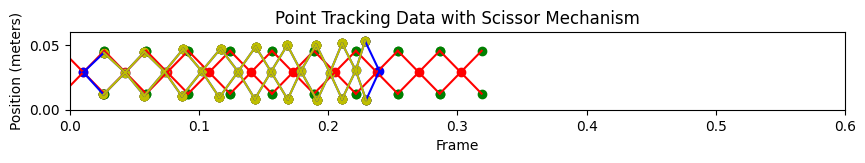

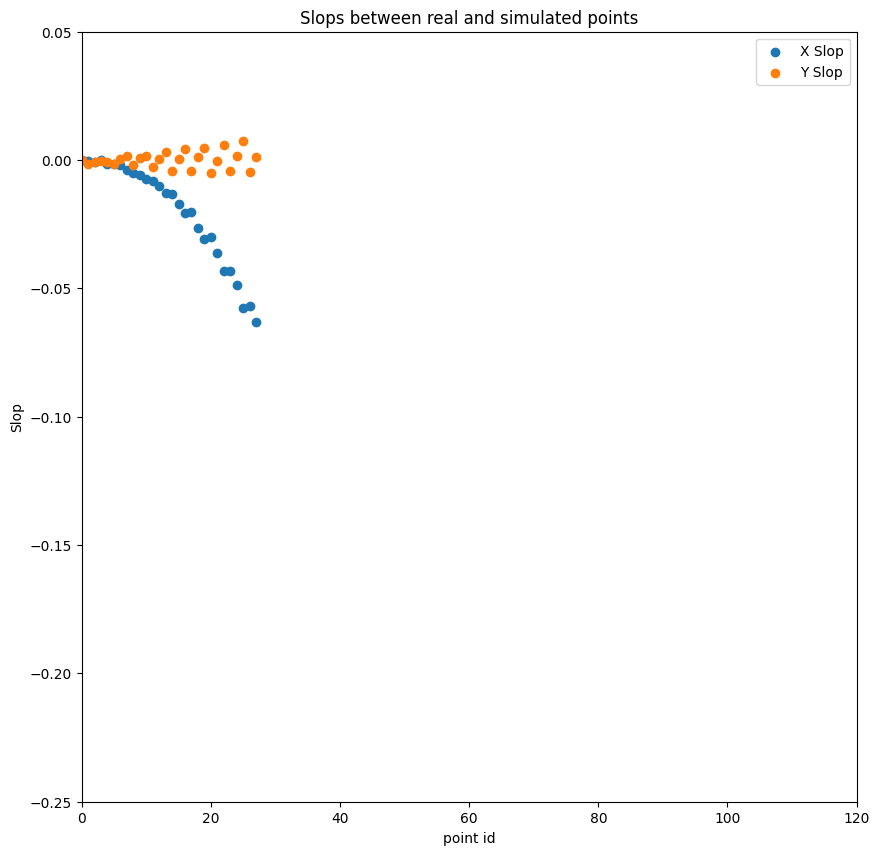

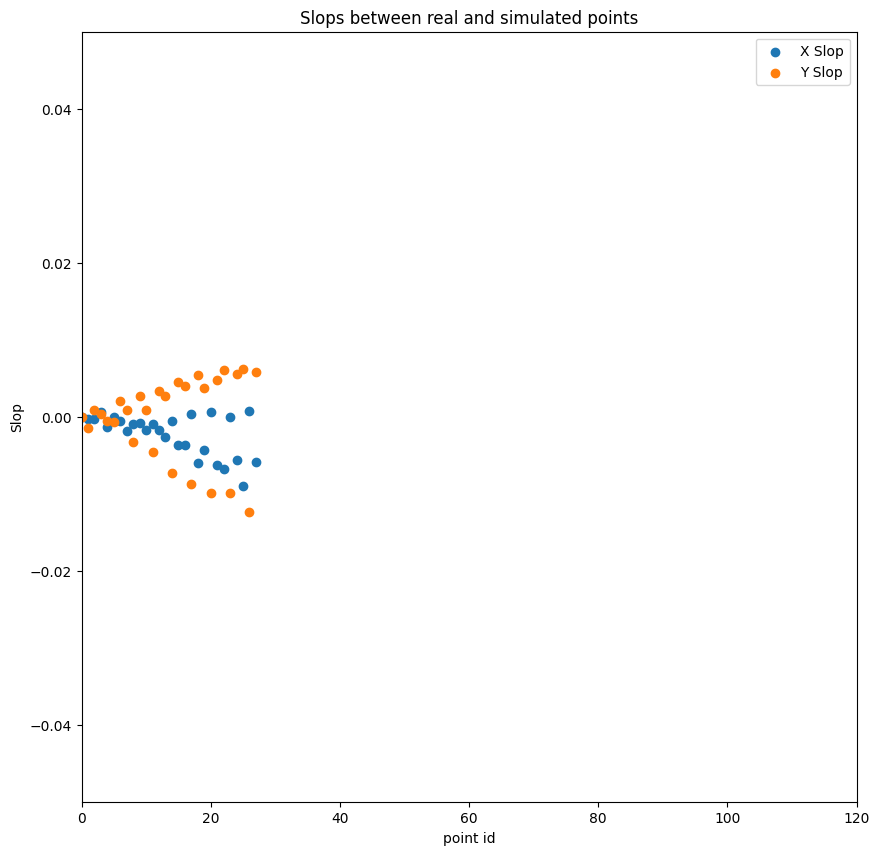

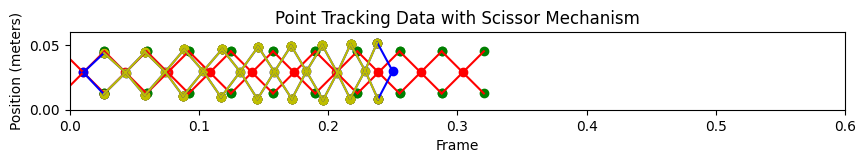

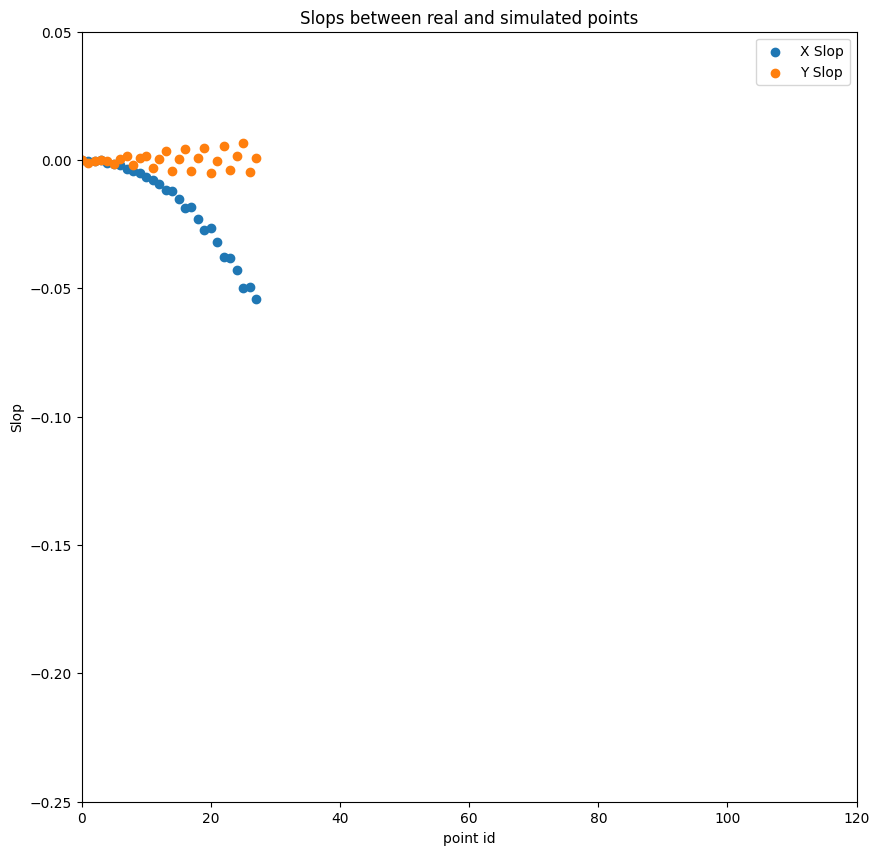

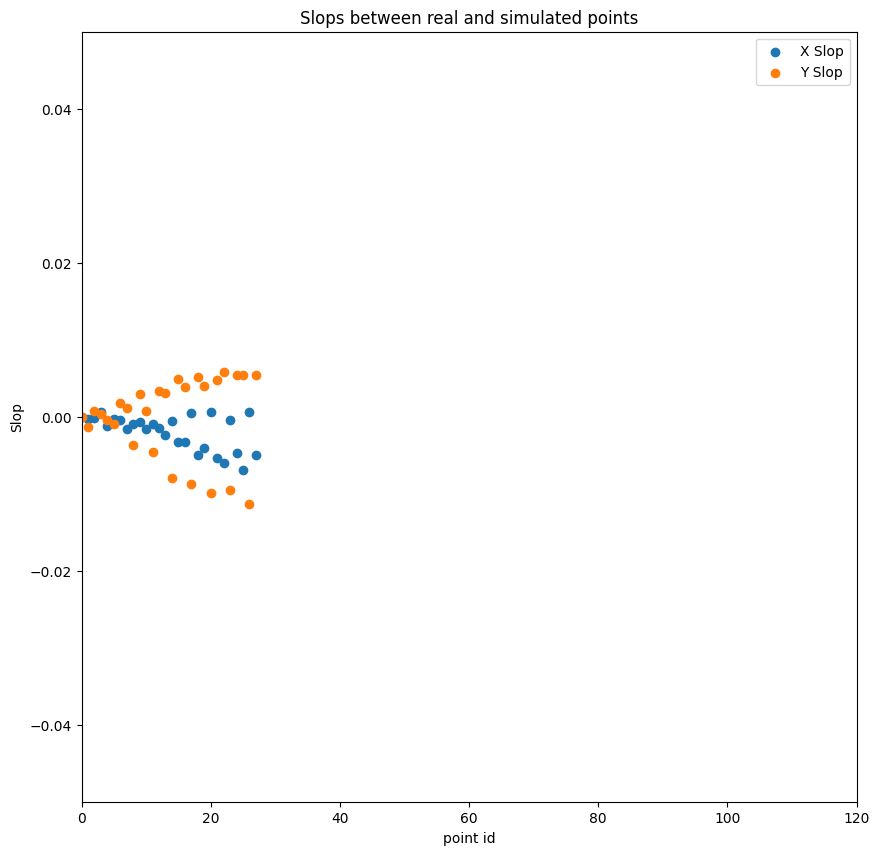

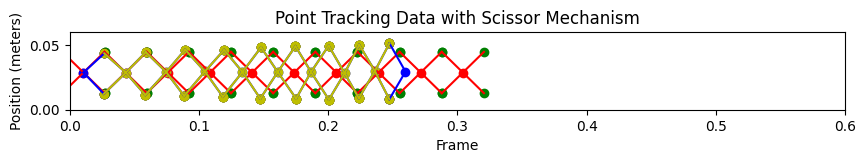

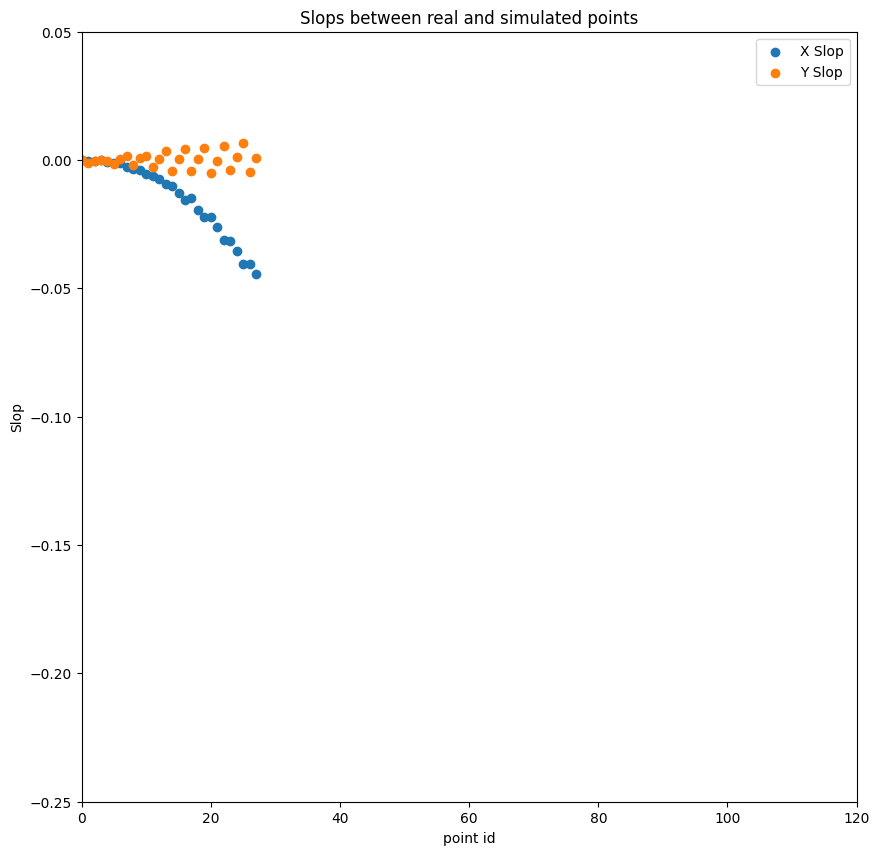

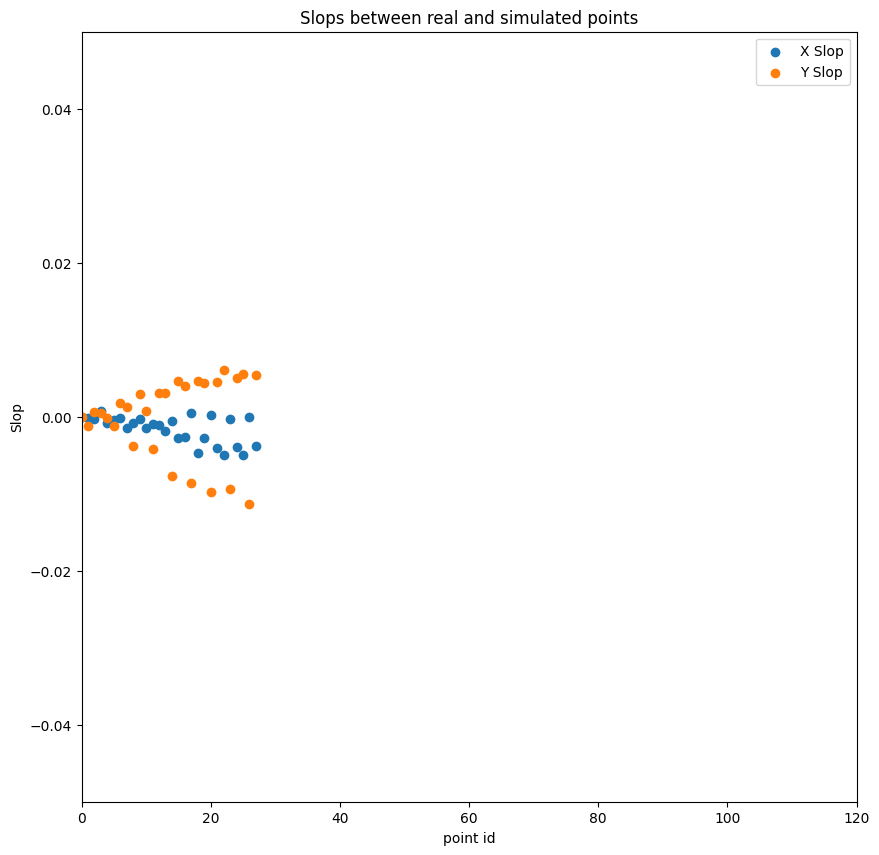

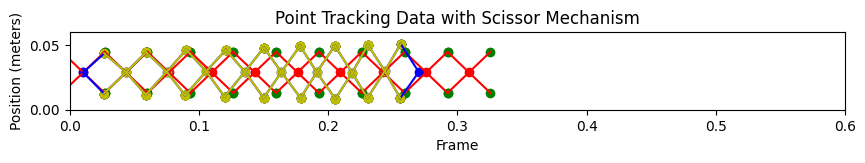

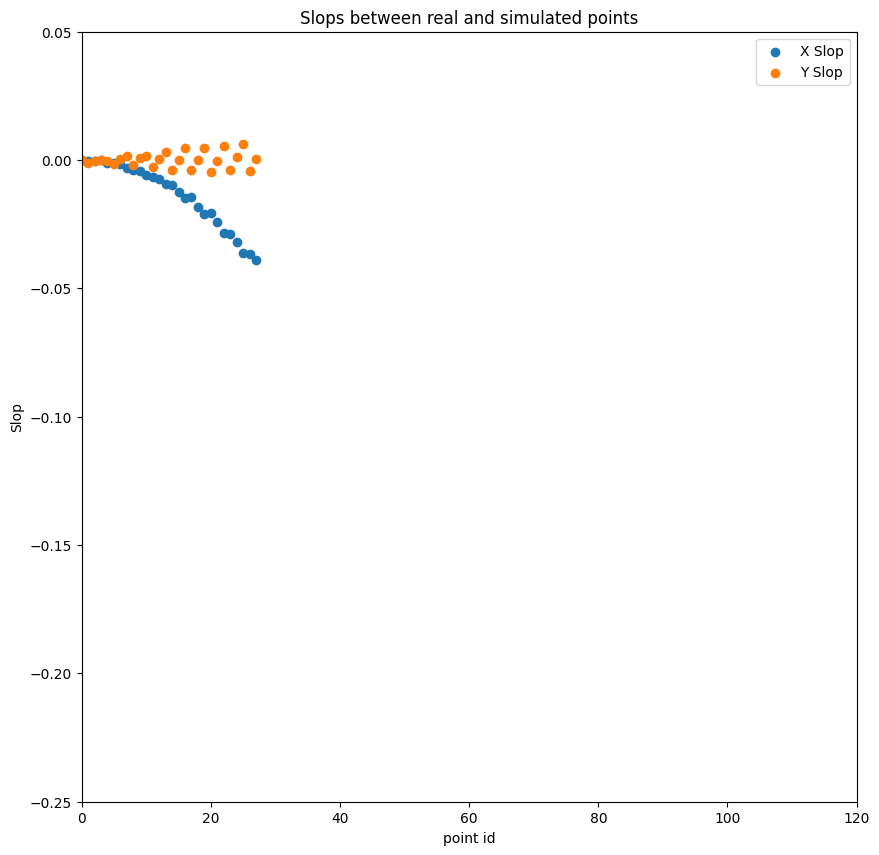

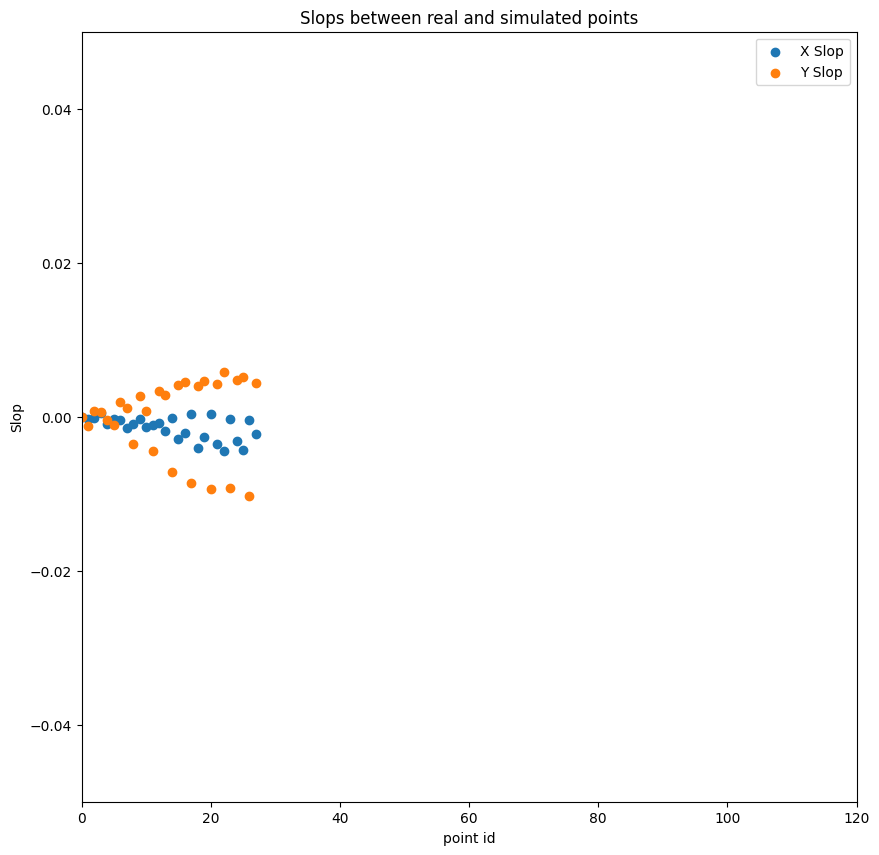

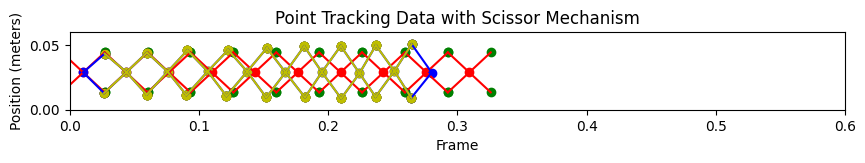

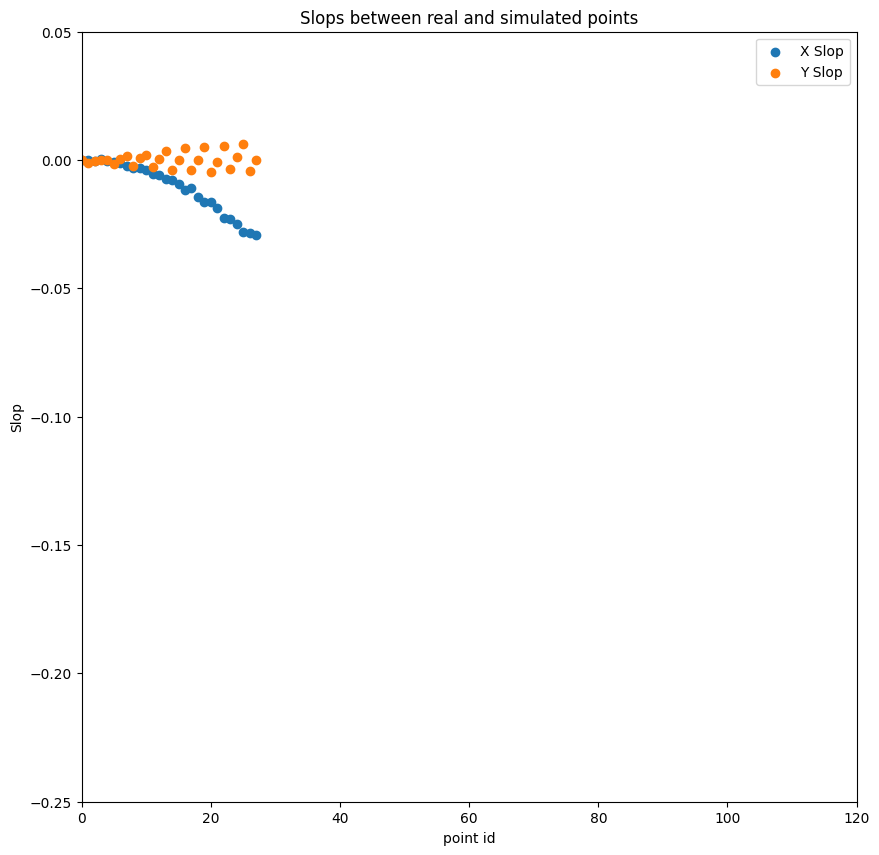

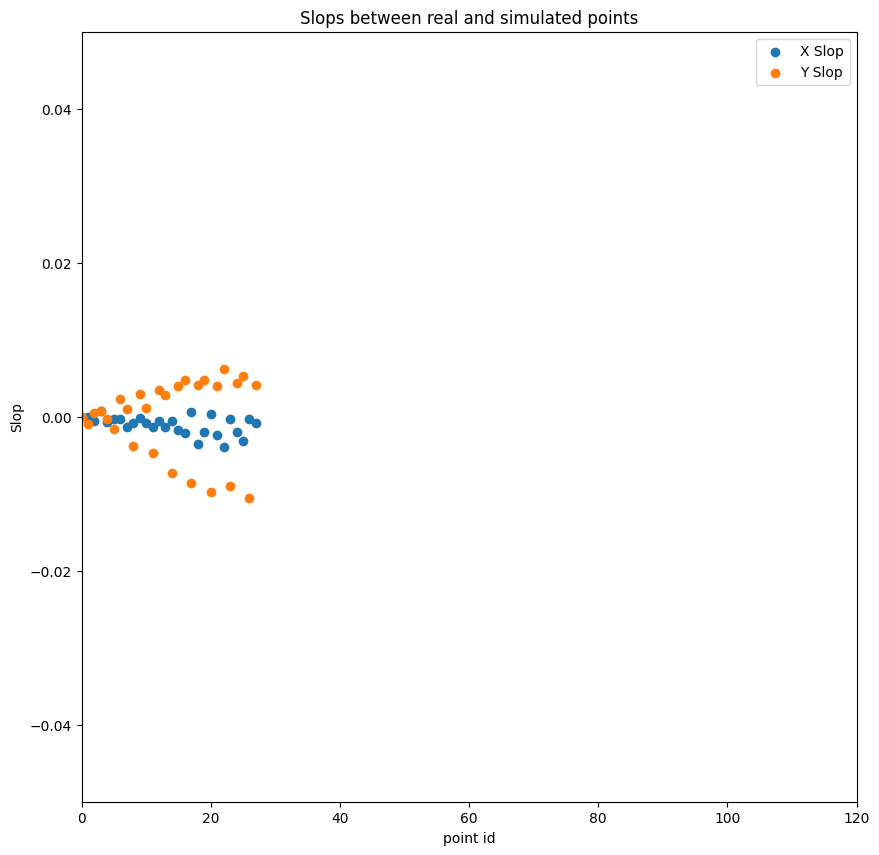

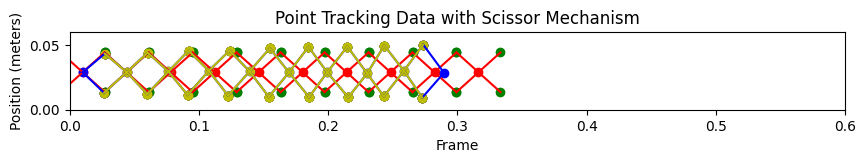

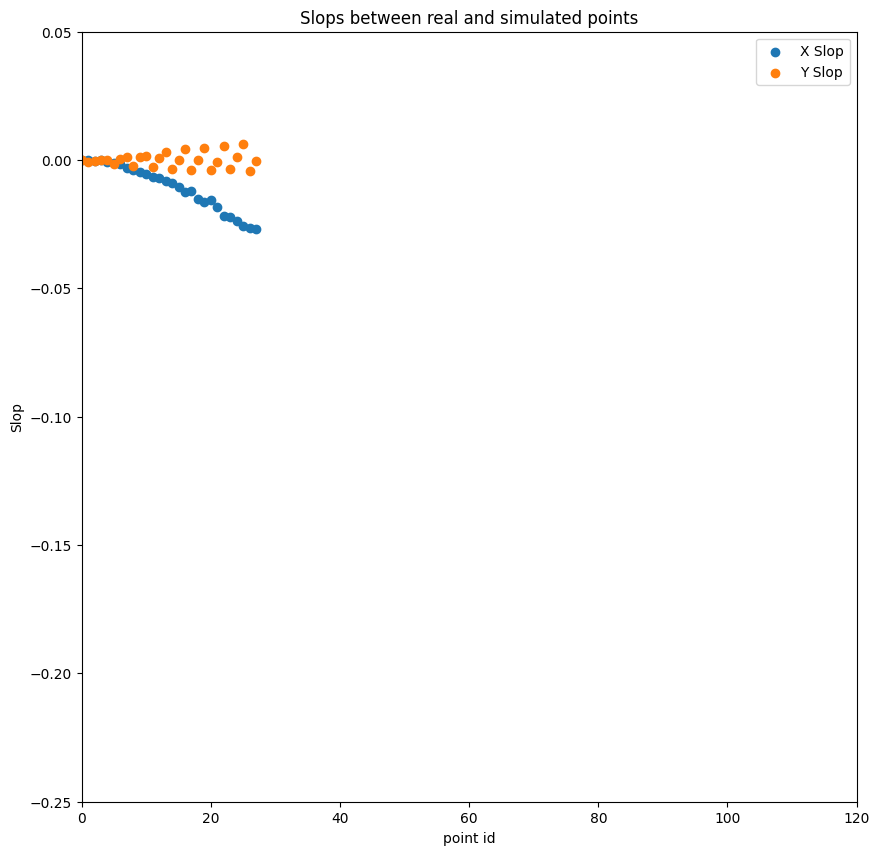

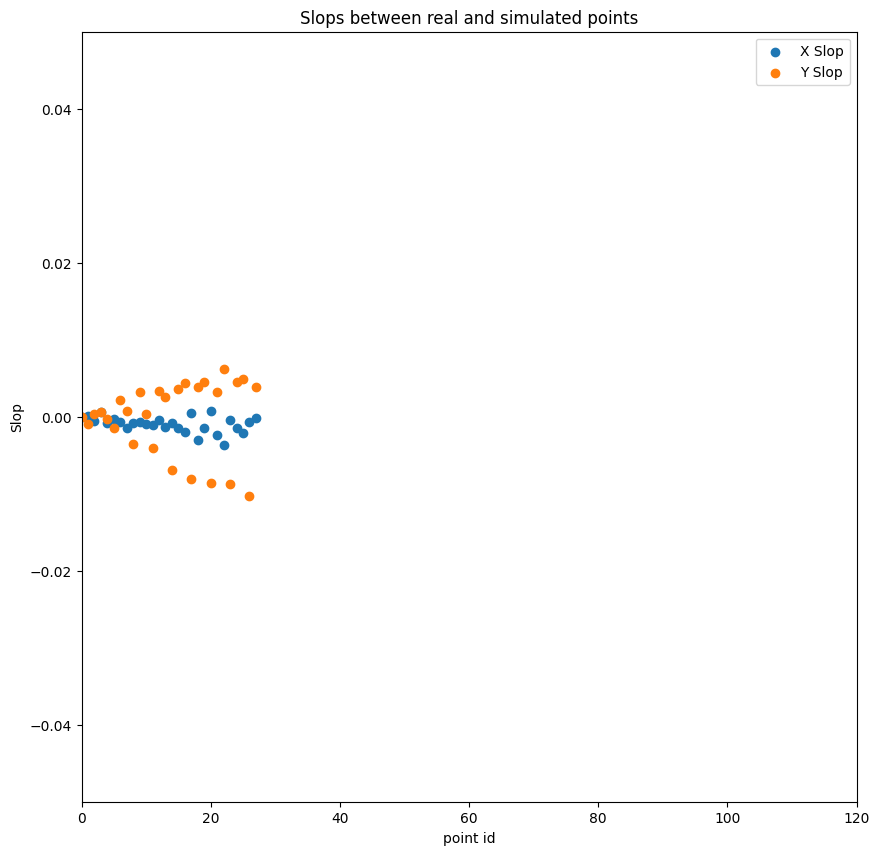

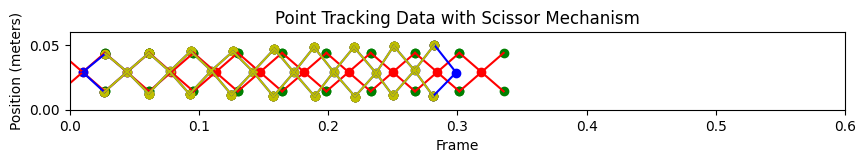

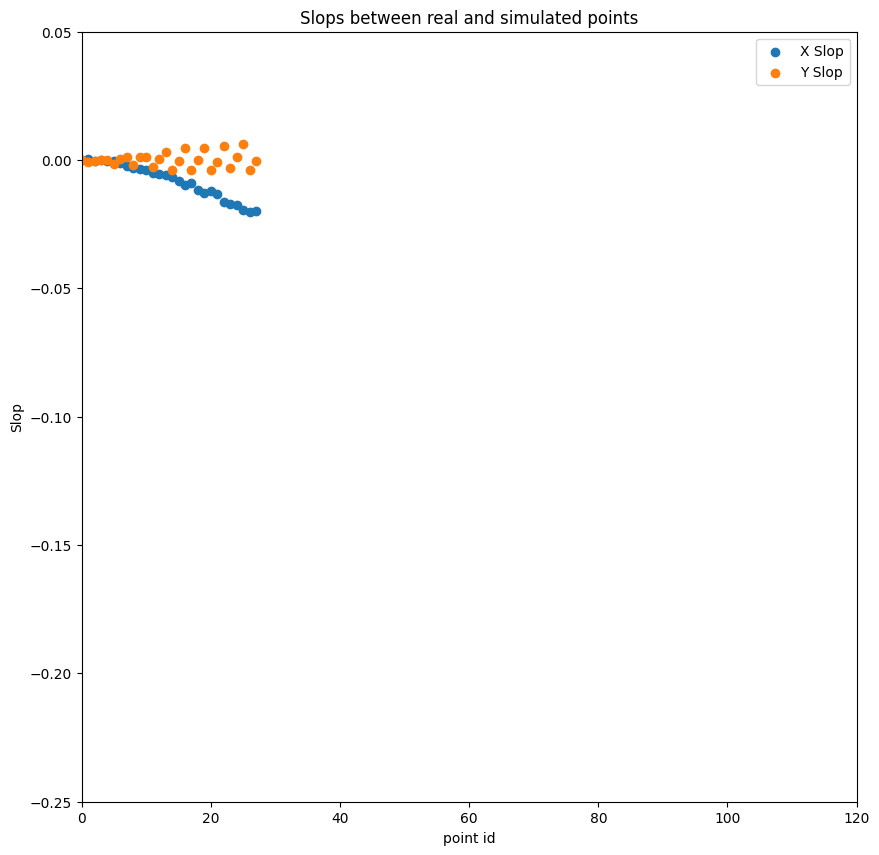

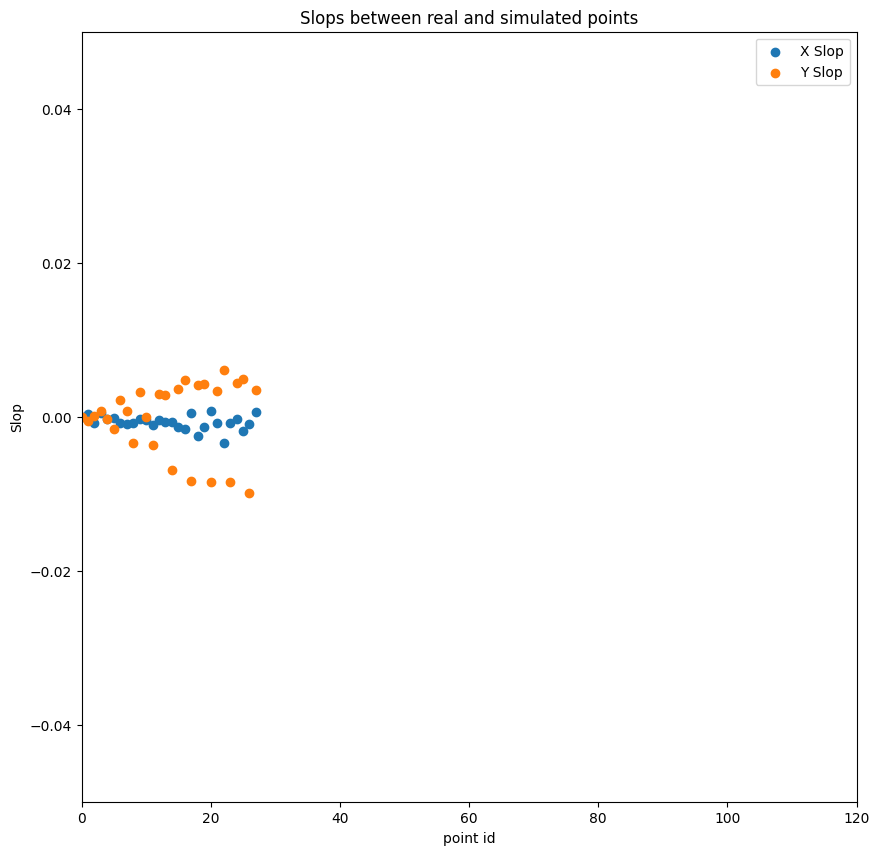

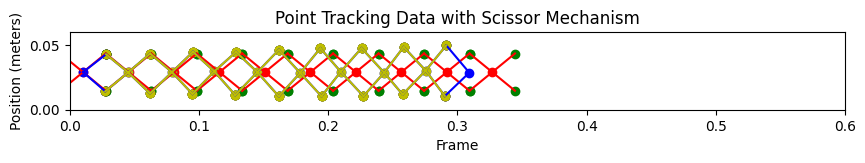

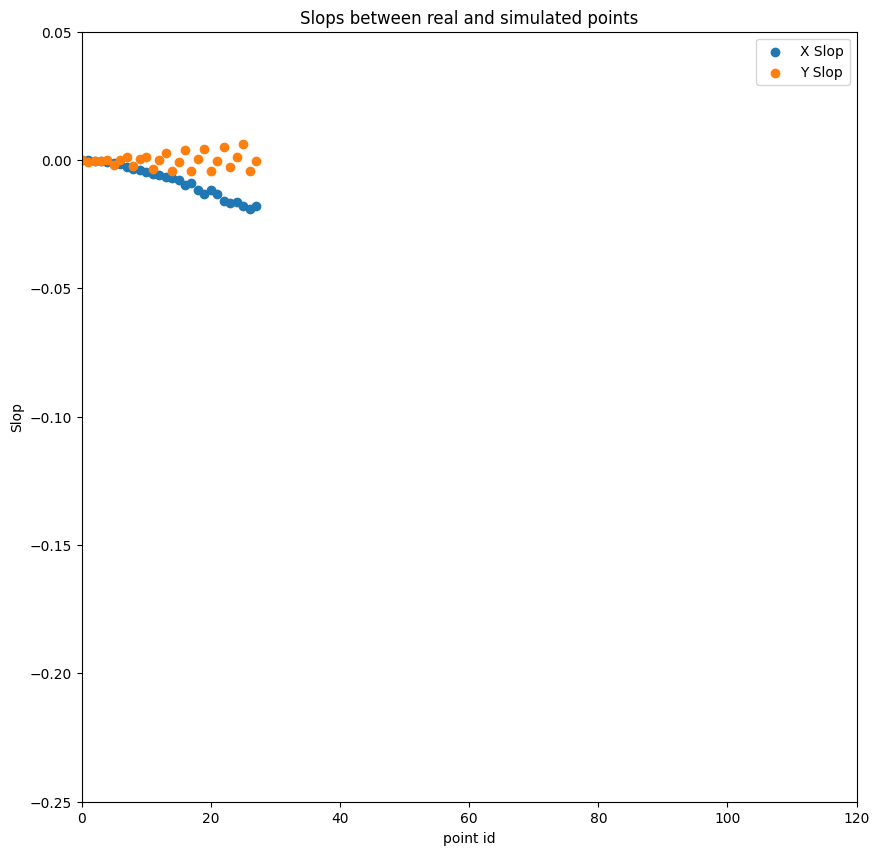

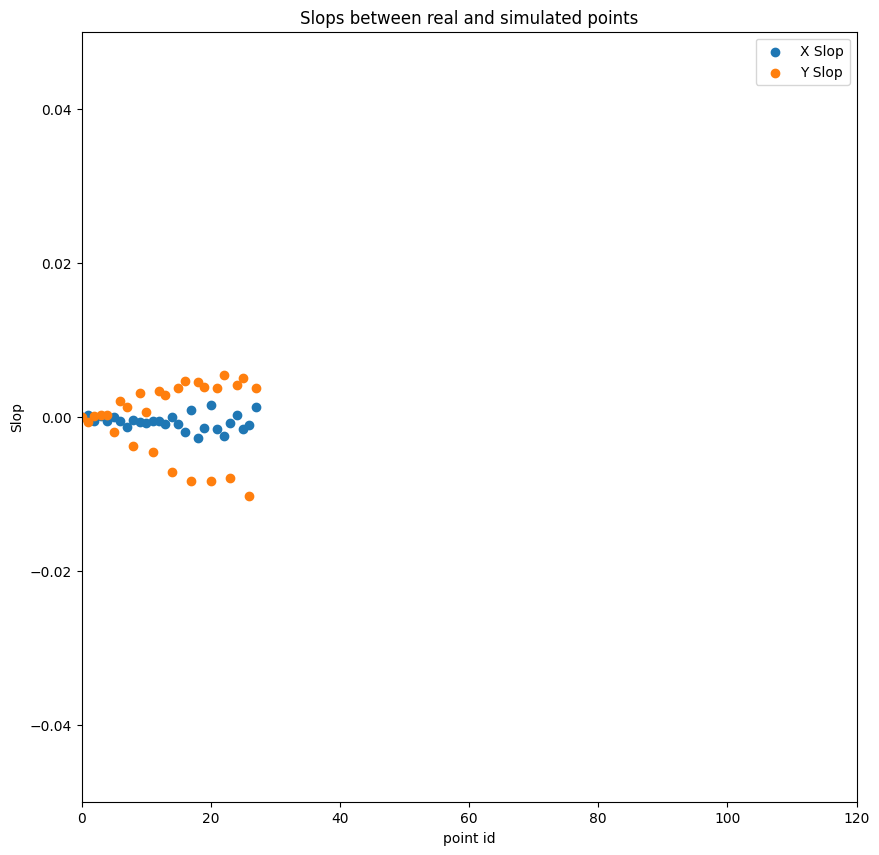

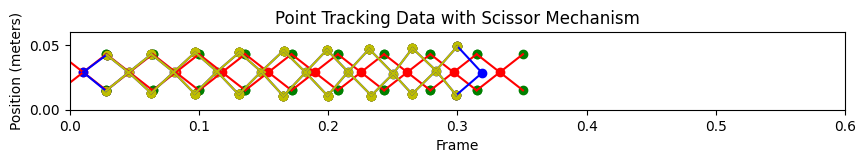

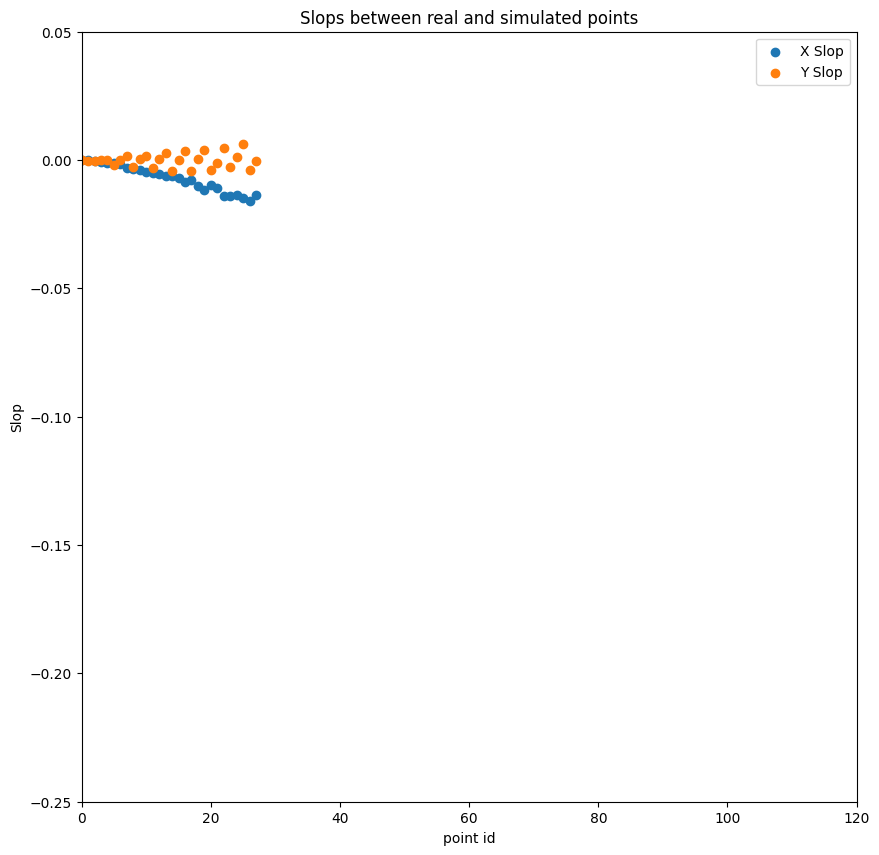

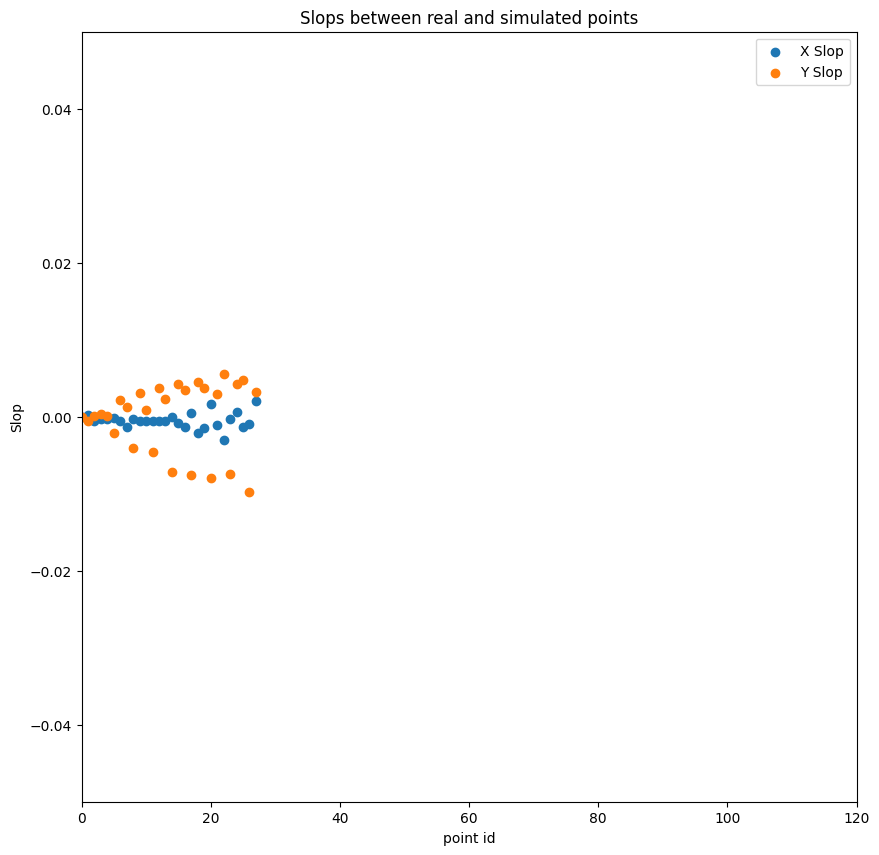

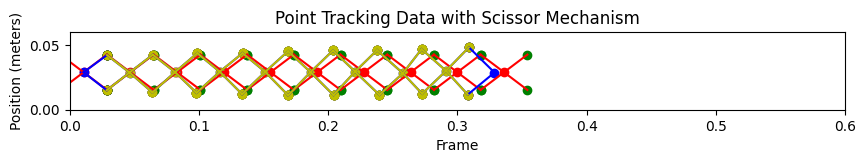

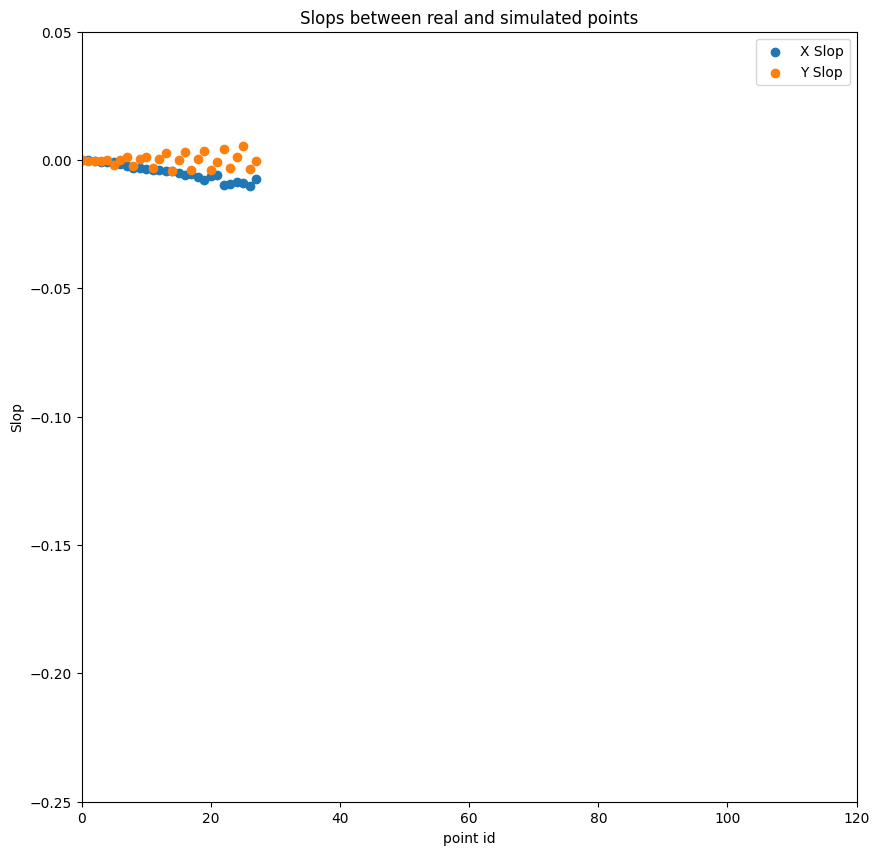

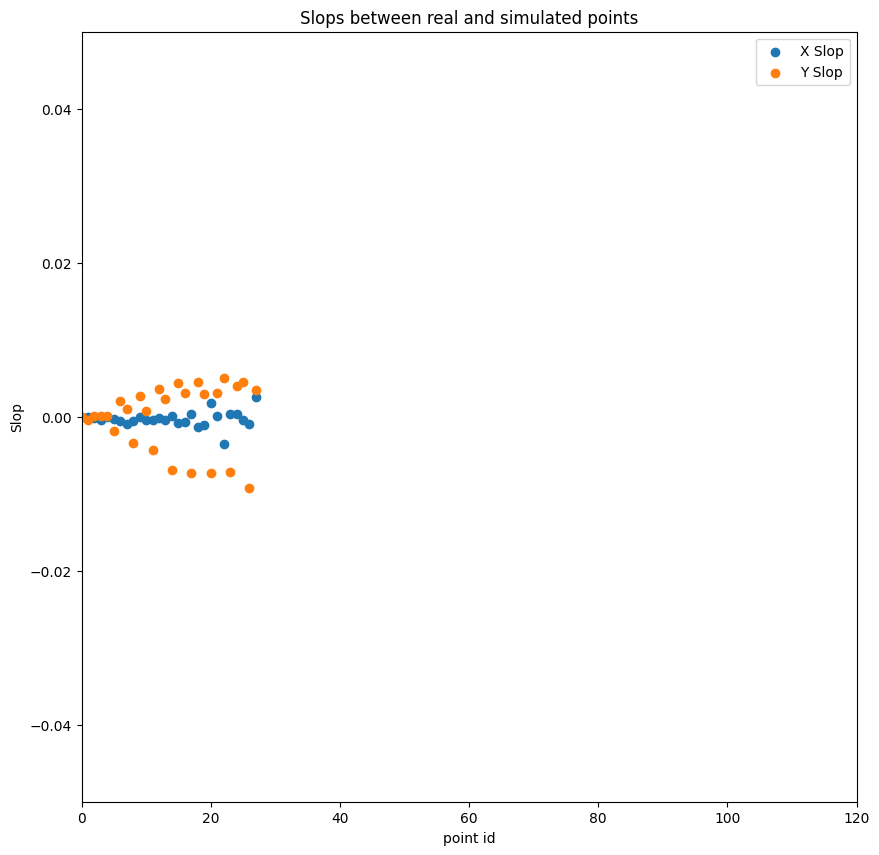

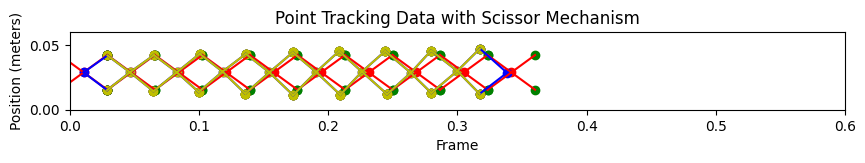

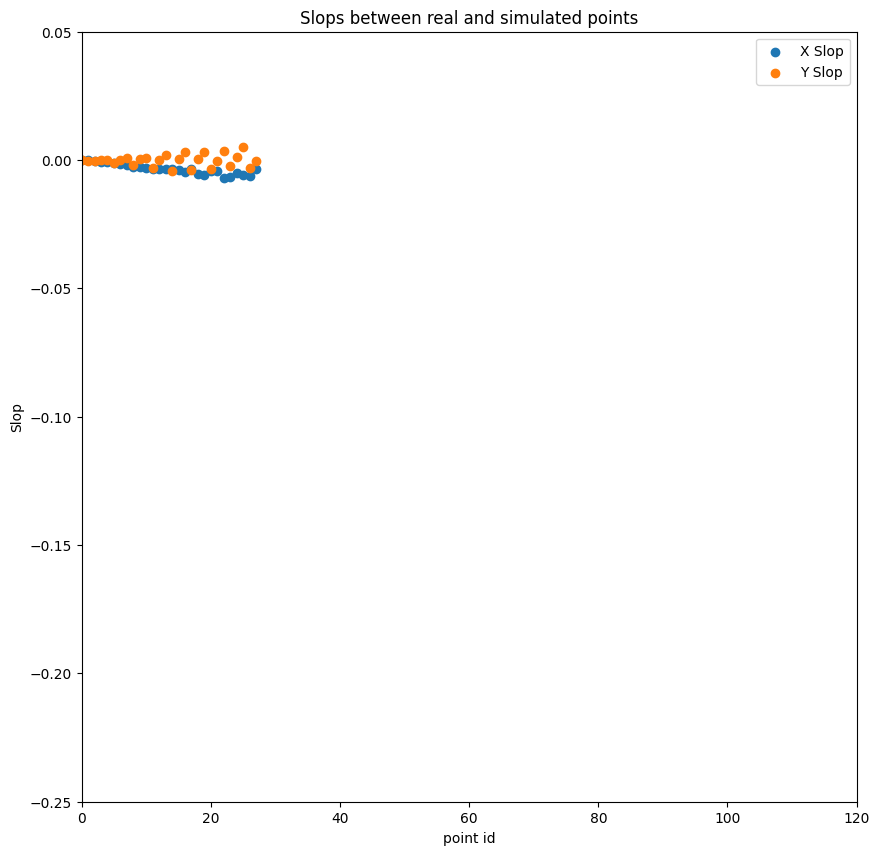

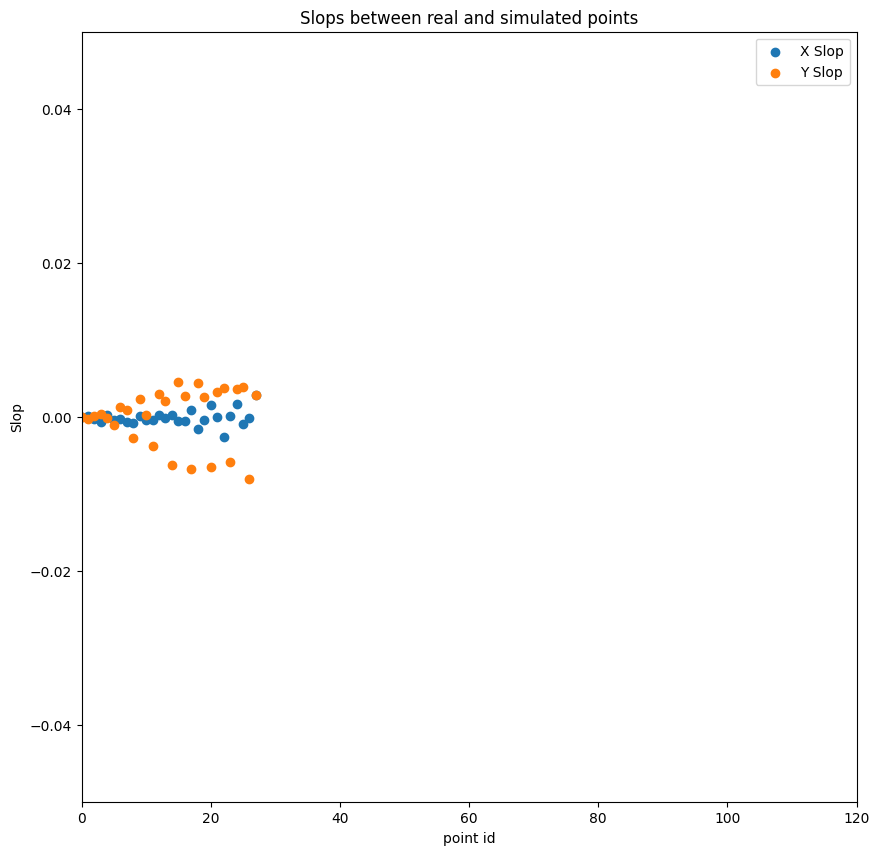

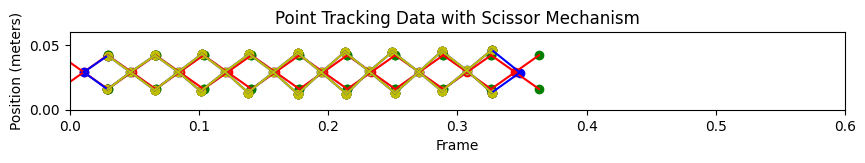

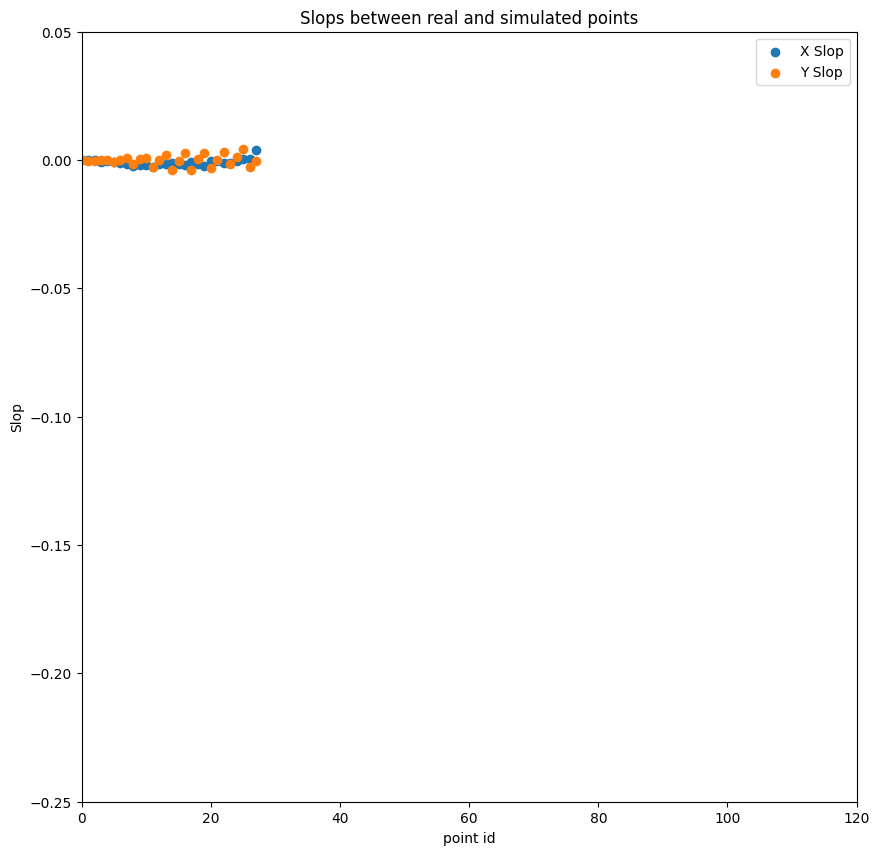

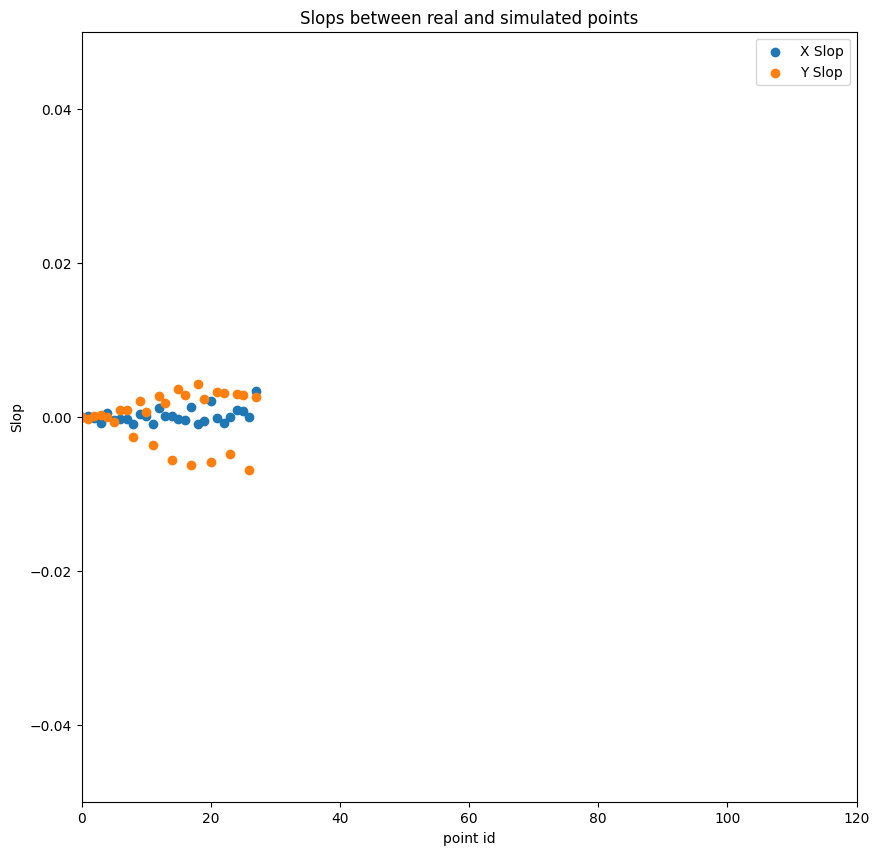

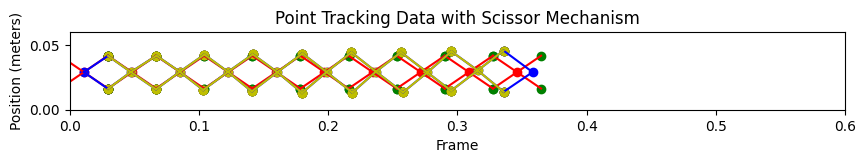

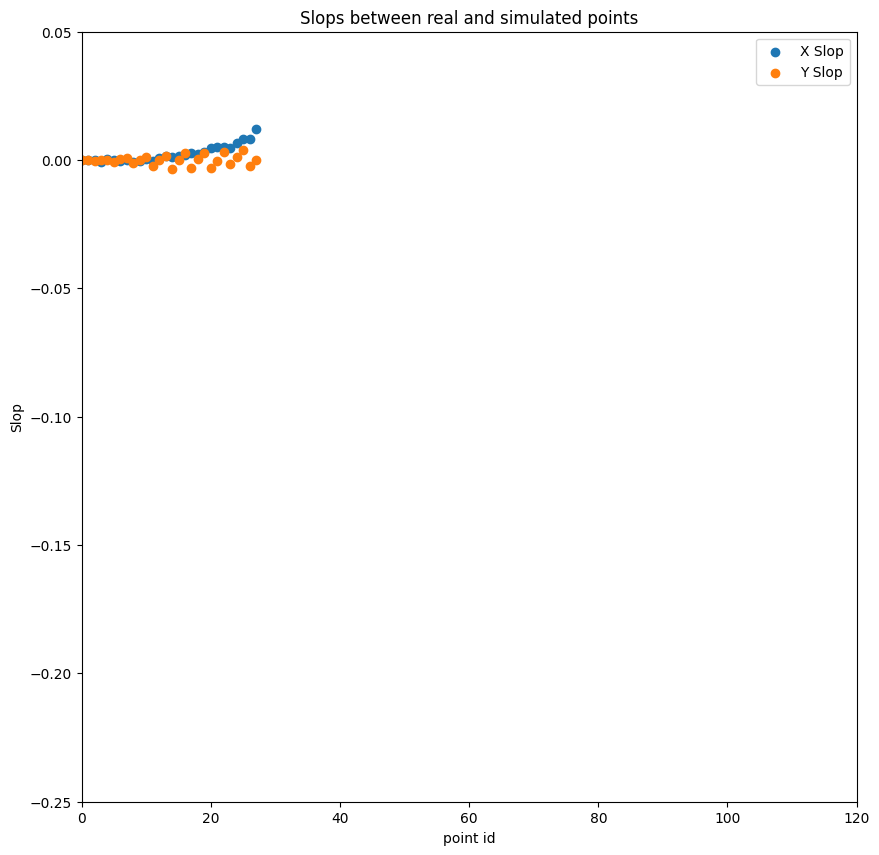

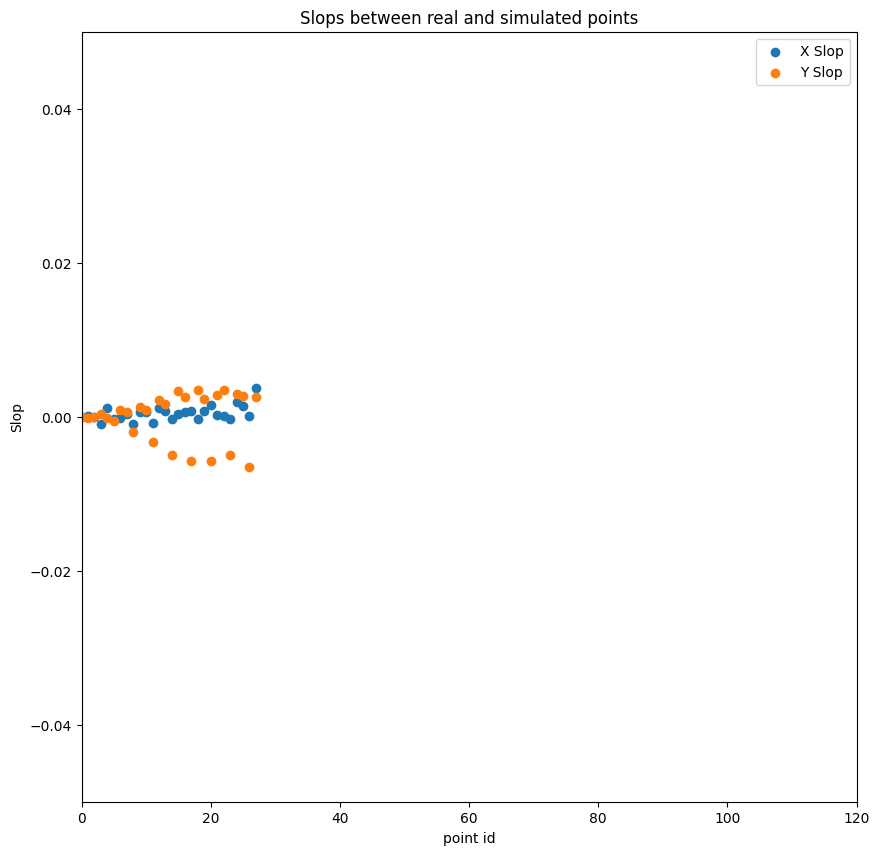

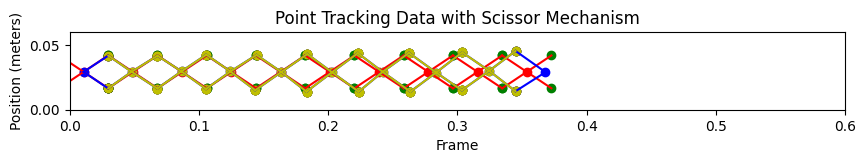

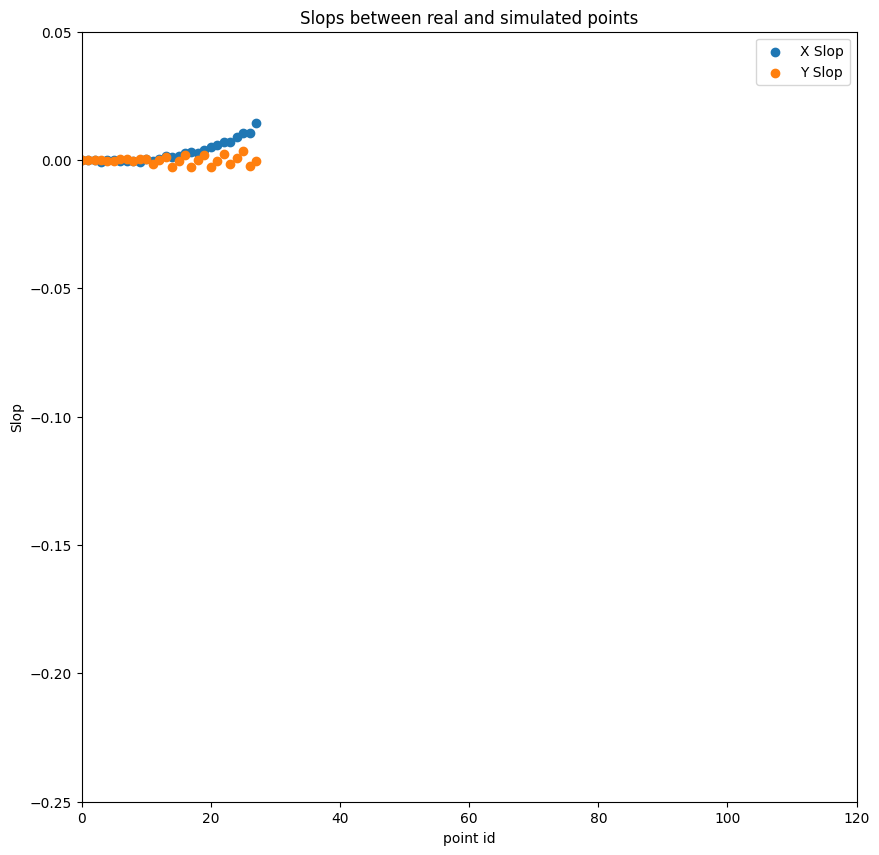

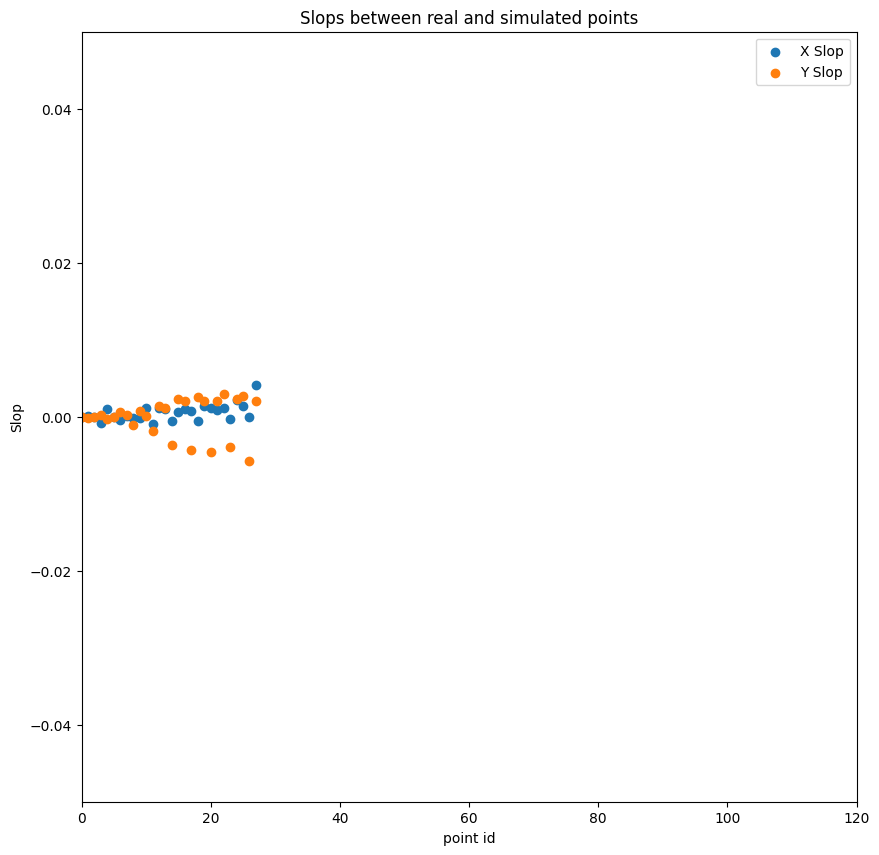

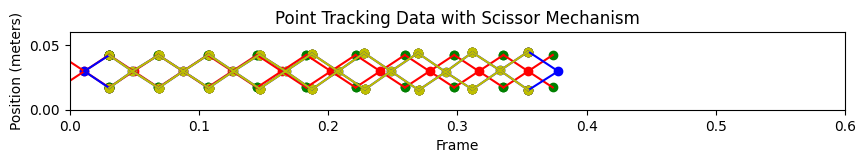

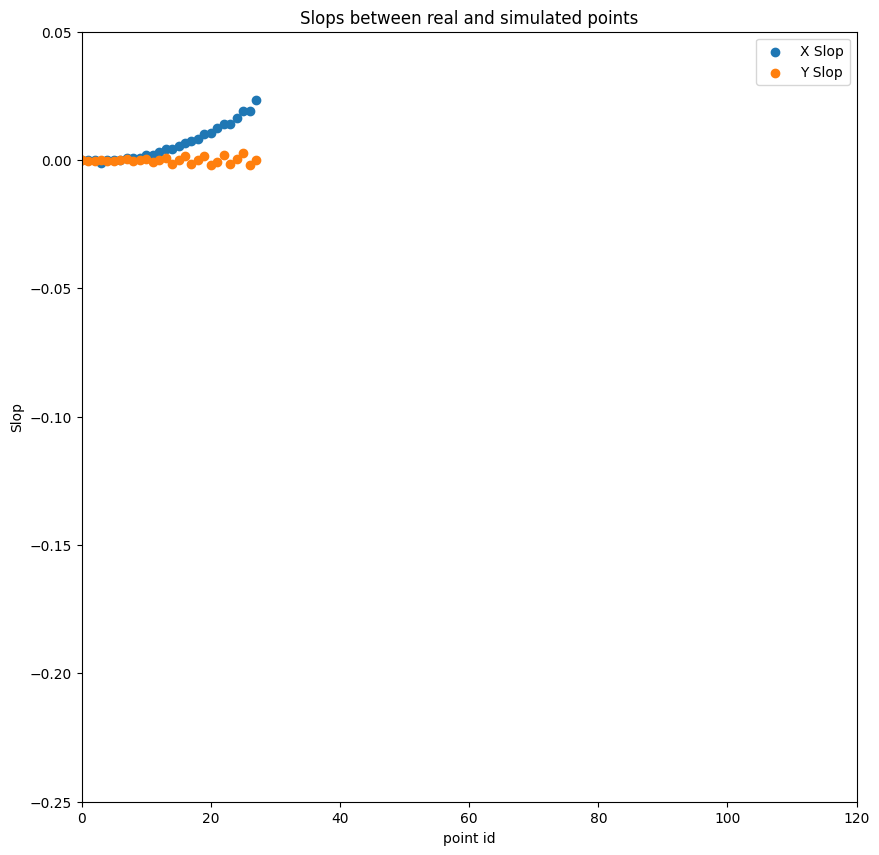

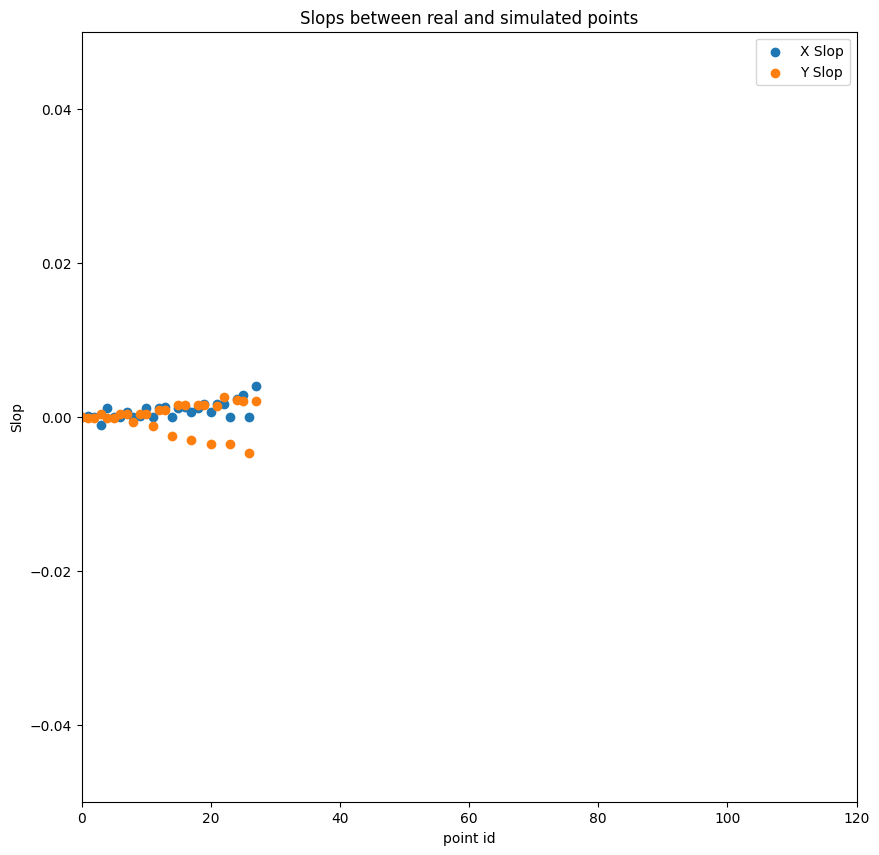

In [338]:
if not os.path.exists(os.path.join(video_dir, 'images')):
    os.makedirs(os.path.join(video_dir, 'images'))

all_slops = []
for frame in range(df.shape[0]):
    positions = np.asarray([[float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])
    
    # get the 3 points with the smallest x values
    sorted_positions = positions[positions[:,0].argsort()]
    
    center_pos = sorted_positions[0, 1]    
    center_points = [p for p in sorted_positions if np.linalg.norm(p[1]-center_pos) <= 5e-3]

    grouped_points_real, adj_mat = group_points(sorted_positions, 1.055e-2)
    angle = angle_between_points(grouped_points_real[0]['points'][0], grouped_points_real[0]['center'], grouped_points_real[0]['points'][2])
    length = np.linalg.norm(sorted_positions[0] - sorted_positions[1])*2
    # Define parameters for the scissor mechanism
    link_length = length # Length of each scissor link
    angle = angle  # Angle between scissor arms
    offset_position = sorted_positions[0,:]  # Starting position of the first scissor center
    offset_rotation = offset_angle  # No rotation applied to the entire scissor mechanism
    num_cells = 10  # Number of scissor units

    # Create the scissor mechanism and display positions
    scissor = ScissorMechanism(link_length, angle, offset_position, offset_rotation, num_cells)
    
    scissor_positions = scissor.calculate_endpoints()
    slops = []
    for i, (real_unit, sim_unit) in enumerate(zip(grouped_points_real, scissor_positions)):
        x_slop = real_unit['center'][0] - sim_unit['center'][0]
        y_slop = real_unit['center'][1] - sim_unit['center'][1]
        slops.append([x_slop, y_slop])
        
        if i == 0:
            for endpoint_real, endpoint_sim in zip(real_unit['points'], sim_unit['points']):
            
                if endpoint_real is None or endpoint_sim is None:
                    continue
                x_slop = endpoint_real[0] - endpoint_sim[0]
                y_slop = endpoint_real[1] - endpoint_sim[1]
                slops.append([x_slop, y_slop])
        else:
            for endpoint_real, endpoint_sim in zip(real_unit['points'][0:4:2], sim_unit['points'][0:4:2]):

                #only do top right and bottom right
                
                if endpoint_real is None or endpoint_sim is None:
                    continue
                x_slop = endpoint_real[0] - endpoint_sim[0]
                y_slop = endpoint_real[1] - endpoint_sim[1]
                slops.append([x_slop, y_slop])

    
    slops = np.array(slops)
    all_slops.append(slops)
            
    n = slops.shape[0]
    # Create a lower triangular matrix with 1's
    lower_triangular_matrix = np.tril(np.ones((n, n)))
    # lower_triangular_matrix = np.tril(adj_mat)
    # print(lower_triangular_matrix.shape)
    # print(slops.shape)
    try:
        x_slops = np.matmul(np.linalg.inv(lower_triangular_matrix),slops[:,0])
        y_slops = np.matmul(np.linalg.inv(lower_triangular_matrix),slops[:,1])
    except:
        print(lower_triangular_matrix.shape)
        print(slops.shape)
         
    active_units = get_active_nodes(df, frame, angle_diff_threshold=5.0)
    active_units = [active_units[i] for i in range(len(active_units)) if (active_units[i]-active_units[i-1] == 1 or i == 0) and (active_units[i]-active_units[i-2] == 2 or i <= 1)]
    
    plot_real_v_sim(scissor_positions, grouped_points_real, frame_id=frame, save=True, video_dir=video_dir, active_units=active_units);
    plot_slops_unadjusted(slops, frame_id=frame, save=True, video_dir=video_dir);
    plot_slops_adjusted(x_slops, y_slops, frame_id=frame, save=True, video_dir=video_dir);
        

In [444]:
active_units = get_active_nodes(df, -1, angle_diff_threshold=5.0)
active_units = [active_units[i] for i in range(len(active_units)) if (active_units[i]-active_units[i-1] == 1 or i == 0) and (active_units[i]-active_units[i-2] == 2 or i <= 1)]

In [455]:

active_units[2]

3

In [459]:
x = [[0, 1, 1], [2, 3, 3], [4, 5, 5], [6, 7, 7], [8, 9, 9], [10, 11, 11], [12, 13, 13],[ 14, 15, 15], [16, 17, 17],[18]]
start = active_units[0]
end = active_units[-1]
np.concatenate(x[])

TypeError: list indices must be integers or slices, not list

In [505]:
b

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.71431364e-04, 5.09345497e-04, 5.29869406e-04, ...,
        6.92755553e-05, 3.82007389e-05, 1.13376804e-04],
       [1.92856864e-03, 1.79065450e-03, 1.77013059e-03, ...,
        6.92755553e-05, 6.17992611e-05, 1.13376804e-04],
       ...,
       [1.58566681e-03, 8.41126544e-04, 4.92220105e-04, ...,
        8.17768444e-03, 1.03494126e-02, 1.92274057e-02],
       [1.48566681e-03, 7.41126544e-04, 2.92220105e-04, ...,
        8.27768444e-03, 1.03494126e-02, 1.92274057e-02],
       [4.14235449e-04, 3.68218953e-04, 6.37649301e-04, ...,
        1.20469600e-02, 1.44876133e-02, 2.32407825e-02]])

In [524]:
from scipy import stats
b = np.abs(np.concatenate(all_slops, axis=1))
all_slopes = []
for i in range(b.shape[1]//2):
    active_units = get_active_nodes(df, i, angle_diff_threshold=5.0)
    active_units = [active_units[i] for i in range(len(active_units)) if (active_units[i]-active_units[i-1] == 1 or i == 0) and (active_units[i]-active_units[i-2] == 2 or i <= 1)]
    active_units = [0] + active_units
    print(active_units)
    x = [[0, 1, 1], [2, 3, 3], [4, 5, 5], [6, 7, 7,], [8, 9, 9], [10, 11, 11], [12, 13, 13],[ 14, 15, 15], [16, 17, 17],[18]]
    start = 0
    if active_units == []:
        end = 1
        x = x[start:end]
    else:
        end = active_units[-1]+1
        x = np.concatenate(x[start:end])

    y = (b[:3*end,2*i] + b[:3*end,2*i+1])/2

    slope, intercept, r, p, std_err = stats.linregress(x, y)
    all_slopes.append(slope)

    def myfunc(x):
        return slope * x + intercept

    mymodel = list(map(myfunc, x))

    # plt.plot(x, mymodel)
    # plt.scatter(x, y)
    # plt.show()

# x = [0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 7, 8, 9, 9, 10, 11, 11, 12, 13, 13, 14, 15, 15, 16, 17, 17, 18]
# y = slops[:,0]

# slope, intercept, r, p, std_err = stats.linregress(x, y)

# def myfunc(x):
#   return slope * x + intercept

# mymodel = list(map(myfunc, x))


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


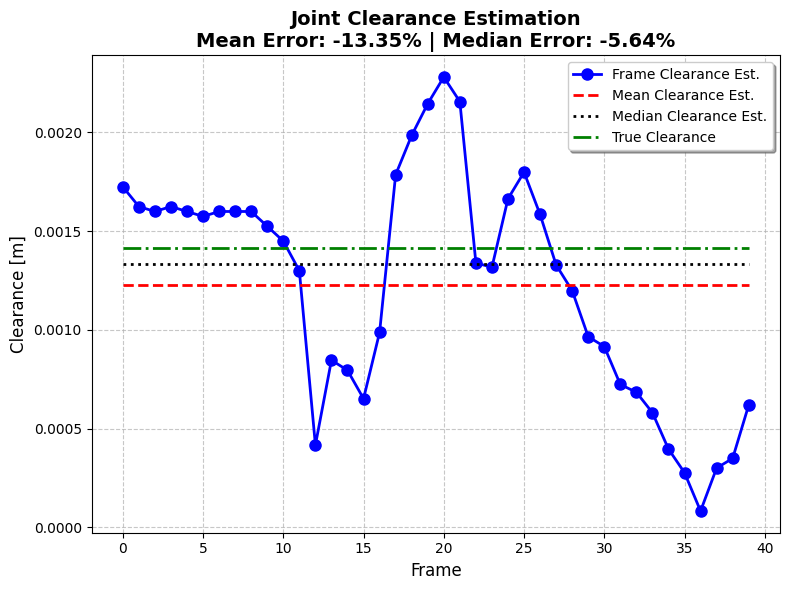

In [525]:
true_clearance = 0.00141421

# Calculate mean and median clearances
mean_clearance = np.mean(all_slopes)
median_clearance = np.median(all_slopes)

# Calculate percent errors
mean_error = (mean_clearance - true_clearance) / true_clearance * 100
median_error = (median_clearance - true_clearance) / true_clearance * 100

# Create the plot
plt.figure(figsize=(8, 6))

# Plot data
plt.plot(all_slopes, 'bo-', label='Frame Clearance Est.', markersize=8, linewidth=2)
plt.plot(mean_clearance * np.ones(len(all_slopes)), 'r--', label='Mean Clearance Est.', linewidth=2)
plt.plot(median_clearance * np.ones(len(all_slopes)), 'k:', label='Median Clearance Est.', linewidth=2)
plt.plot(true_clearance * np.ones(len(all_slopes)), 'g-.', label='True Clearance', linewidth=2)

# Labels, title, and grid
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Clearance [m]', fontsize=12)

# Add the percent error to the title
plt.title(f'Joint Clearance Estimation\nMean Error: {mean_error:.2f}% | Median Error: {median_error:.2f}%', 
          fontsize=14, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.7)

# Legend
plt.legend(loc='best', fontsize=10, frameon=True, shadow=True, fancybox=True)

# Show plot
plt.tight_layout()
plt.show()

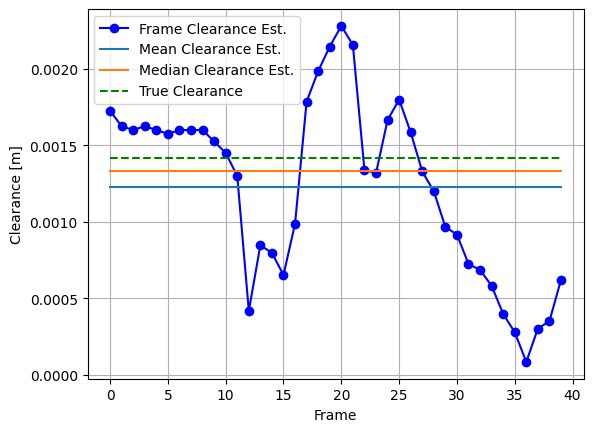

In [515]:
plt.plot(all_slopes , 'bo-', label='Frame Clearance Est.')
plt.plot(np.mean(all_slopes)*np.ones(len(all_slopes)), label='Mean Clearance Est.')
plt.plot(np.median(all_slopes)*np.ones(len(all_slopes)), label='Median Clearance Est.')
plt.plot(0.00141421*np.ones(len(all_slopes)), 'g--', label='True Clearance')
plt.xlabel('Frame')
plt.ylabel('Clearance [m]')
plt.legend()
plt.grid()
# plot error bars on the slopes
# plt.errorbar(range(len(all_slopes)), all_slopes, yerr=errors, color='r')

In [510]:
np.median(all_slopes)

np.float64(0.001334422498103215)

In [432]:
all_slops.shape

AttributeError: 'list' object has no attribute 'shape'

In [428]:
len([0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 7, 8, 9, 9, 10, 11, 11, 12, 13, 13, 14, 15, 15, 16, 17, 17, 18])

28

In [425]:
len(np.sum(np.tril(adj_mat), axis=1))

28

In [430]:
slope 

np.float64(0.001218315075494676)

In [418]:
slops[:,0]

array([ 0.        ,  0.00011338,  0.00011338, -0.00097325,  0.00014013,
        0.00014013,  0.00015351,  0.00076688,  0.00076688,  0.00088026,
        0.00199364,  0.00199364,  0.00310701,  0.00432039,  0.00432039,
        0.00543377,  0.00664714,  0.00724714,  0.00836052,  0.0100739 ,
        0.0106739 ,  0.01238728,  0.01410065,  0.01410065,  0.01641403,
        0.01922741,  0.01922741,  0.02324078])

In [413]:
adj_mat

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

In [416]:
np.mean((np.matmul(np.linalg.pinv(np.tril(adj_mat)), slops[:,0].reshape(-1,1))))

np.float64(0.07928567489325626)

In [401]:
b[:,0]

array([0.        , 0.00057143, 0.00192857, 0.00344286, 0.00061429,
       0.00098571, 0.00058573, 0.00174284, 0.00324284, 0.00087141,
       0.00189998, 0.00339998, 0.00102855, 0.00245712, 0.00255712,
       0.00178569, 0.00191425, 0.00231425, 0.00254282, 0.00297139,
       0.00067139, 0.00129996, 0.00202853, 0.00192853, 0.0004571 ,
       0.00158567, 0.00148567, 0.00041424])

In [387]:
b = np.abs(np.concatenate(all_slops, axis=1))
# take ever other column
# b = np.abs()

In [388]:
x = np.ones(b.shape)*0.001

In [389]:
A = np.matmul(b, np.matmul(x.T, (np.linalg.pinv(np.matmul(x, x.T)))))

In [390]:
np.tril()

TypeError: tril() missing 1 required positional argument: 'm'

In [391]:
np.mean(np.matmul(np.linalg.pinv(np.tril(A)), b))

np.float64(0.0009999999999999922)

In [392]:
A_tmp = np.matmul(b, np.linalg.pinv(x))

In [394]:
np.tril(A_tmp)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.04094696, 0.04094696, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.02570624, 0.02570624, 0.02570624, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [386]:
np.sum(np.tril(A_tmp), axis=1)

array([0.00000000e+00, 1.95161986e-02, 1.01448469e-01, 2.09895517e-01,
       1.13499970e-01, 1.76689150e-01, 2.62906386e-01, 7.91217681e-01,
       1.16741025e+00, 1.13315414e+00, 1.75266807e+00, 2.32552294e+00,
       2.50718897e+00, 3.55193086e+00, 4.00251521e+00, 5.21435665e+00,
       6.50789541e+00, 6.80231993e+00, 9.15911894e+00, 1.12117224e+01,
       1.07612449e+01, 1.37599580e+01, 1.74236797e+01, 1.81426596e+01,
       2.06933666e+01, 2.54815987e+01, 2.64303209e+01, 2.99131458e+01])

In [378]:
np.matmul(np.tril(A), x)-b


array([[ 1.00000000e-03,  1.00000000e-03,  1.00000000e-03, ...,
         1.00000000e-03,  1.00000000e-03,  1.00000000e-03],
       [-5.51915165e-04, -4.89829299e-04, -5.10353207e-04, ...,
        -4.97593566e-05, -1.86845403e-05, -9.38606052e-05],
       [-1.82712017e-03, -1.68920603e-03, -1.66868213e-03, ...,
         3.21729137e-05,  3.96492079e-05, -1.19283349e-05],
       ...,
       [ 2.38959319e-02,  2.46404722e-02,  2.49893786e-02, ...,
         1.73039143e-02,  1.51321862e-02,  6.25419308e-03],
       [ 2.49446541e-02,  2.56891944e-02,  2.61381008e-02, ...,
         1.81526365e-02,  1.60809084e-02,  7.20291528e-03],
       [ 2.94989104e-02,  2.95449269e-02,  2.92754965e-02, ...,
         1.78661858e-02,  1.54255325e-02,  6.67236336e-03]])

In [371]:
np.matmul(np.linalg.pinv(np.tril(A)), b)

array([[ 2.92798497e-02,  2.60986018e-02,  2.71502363e-02, ...,
         3.54964389e-03,  1.95738625e-03,  5.80936923e-03],
       [ 2.92798497e-02,  2.60986018e-02,  2.71502363e-02, ...,
         3.54964389e-03,  1.95738625e-03,  5.80936923e-03],
       [-1.52871648e-03,  7.55429011e-04, -1.95476614e-03, ...,
        -5.05069436e-03, -2.08726555e-03, -8.26599775e-03],
       ...,
       [ 1.06569794e-03,  4.35968008e-04, -3.16761027e-04, ...,
         1.18700502e-04, -3.26632265e-04, -2.11490289e-04],
       [-1.00236973e-04, -1.01137758e-04, -2.03715284e-04, ...,
         1.12049212e-04,  1.25212888e-05,  2.32623733e-05],
       [-1.12994655e-03, -4.12431897e-04,  2.98348745e-04, ...,
         2.82037467e-03,  2.98854973e-03,  2.11254582e-03]])

In [314]:
lower_triangular_matrix = np.tril(np.ones((n, n)))
lower_triangular_matrix = np.tril(adj_mat)
# divide by the norm of the columns
for col in range(lower_triangular_matrix.shape[1]):
    lower_triangular_matrix[col,:] = lower_triangular_matrix[col,:] / np.linalg.norm(lower_triangular_matrix[col,:])
    
# lower_triangular_matrix = lower_triangular_matrix / np.linalg.norm(lower_triangular_matrix, axis=1)

In [326]:
true_slop = np.ones((n,1))*0.001

In [331]:
true_slop

array([[0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001],
       [0.001]])

In [334]:
np.linalg.pinv(np.matmul(true_slop, true_slop.T))

array([[1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408],
       [1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408,
        1275.51020408, 1275.51020408, 1275.51020408, 1275.51020408],
       [1275.51020408, 1275.51020408, 1275.510

In [337]:
np.matmul(slops[:,0], np.matmul(true_slop.T, (np.linalg.pinv(np.matmul(true_slop, true_slop.T)))))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 28)

In [ ]:
A = slops[:,0]*true_slop.T*(np.linalg.inv(true_slop*true_slop.T))

In [313]:
np.tril(adj_mat)[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [315]:
lower_triangular_matrix[:,col]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.57735027])

In [316]:
np.linalg.norm(lower_triangular_matrix[:,0])

np.float64(1.4142135623730951)

In [317]:
 np.linalg.norm(lower_triangular_matrix, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [318]:
lower_triangular_matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.70710678, 0.70710678, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.70710678, 0.        , 0.70710678, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [319]:
np.linalg.pinv(lower_triangular_matrix)

array([[ 1.00000000e+00, -2.33409821e-14, -2.31458218e-14,
         2.80577585e-14, -1.16722907e-14, -1.16861684e-14,
         1.37788698e-14, -5.83415183e-15, -5.69031875e-15,
         6.93123300e-15, -2.99742415e-15, -3.05231060e-15,
         3.35210301e-15, -1.37884288e-15, -1.35024477e-15,
         1.74621089e-15, -7.61621750e-16, -9.73956378e-16,
         8.16088405e-16, -3.30746375e-16, -3.46545892e-16,
         4.96801761e-16, -2.24592278e-16, -2.17653384e-16,
         1.40317200e-16,  7.35382017e-18,  1.17386779e-18,
        -5.80282555e-17],
       [-1.00000000e+00,  1.41421356e+00,  6.13953446e-14,
        -7.47271358e-14,  3.04467470e-14,  3.05577693e-14,
        -3.69742774e-14,  1.50921393e-14,  1.50959067e-14,
        -1.85552429e-14,  7.82580406e-15,  7.85231021e-15,
        -9.23393152e-15,  3.50686921e-15,  3.61620645e-15,
        -4.68171992e-15,  2.30554509e-15,  2.30173756e-15,
        -2.47281273e-15,  9.90130275e-16,  1.00958623e-15,
        -1.21571689e-15,  4.86

In [320]:
np.linalg.inv(lower_triangular_matrix)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.00000000e+00,  1.41421356e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00

In [325]:
slops[:,0]

array([ 0.        ,  0.00011338,  0.00011338, -0.00097325,  0.00014013,
        0.00014013,  0.00015351,  0.00076688,  0.00076688,  0.00088026,
        0.00199364,  0.00199364,  0.00310701,  0.00432039,  0.00432039,
        0.00543377,  0.00664714,  0.00724714,  0.00836052,  0.0100739 ,
        0.0106739 ,  0.01238728,  0.01410065,  0.01410065,  0.01641403,
        0.01922741,  0.01922741,  0.02324078])

In [321]:
np.matmul(np.linalg.pinv(lower_triangular_matrix),slops[:,0])

array([-5.17129269e-17,  1.60339014e-04,  1.60339014e-04, -2.00639023e-03,
        2.20456456e-03,  2.20456456e-03, -4.14324681e-03,  5.22778460e-03,
        5.22778460e-03, -8.93091272e-03,  1.17503421e-02,  1.17503421e-02,
       -1.81191773e-02,  2.42291332e-02,  2.42291332e-02, -3.90467041e-02,
        4.84471865e-02,  4.92957146e-02, -8.32620528e-02,  9.75086967e-02,
        9.83572248e-02, -1.74410531e-01,  1.94351865e-01,  1.94351865e-01,
       -3.60273798e-01,  3.87465455e-01,  3.87465455e-01, -7.34676695e-01])

In [280]:
slops

array([[ 0.        ,  0.        ],
       [ 0.00011338, -0.00017381],
       [ 0.00011338, -0.00032619],
       [-0.00097325,  0.        ],
       [ 0.00014013, -0.00017381],
       [ 0.00014013, -0.00032619],
       [ 0.00015351,  0.        ],
       [ 0.00076688,  0.00032619],
       [ 0.00076688, -0.00032619],
       [ 0.00088026,  0.        ],
       [ 0.00199364,  0.00032619],
       [ 0.00199364, -0.00092619],
       [ 0.00310701,  0.        ],
       [ 0.00432039,  0.00092619],
       [ 0.00432039, -0.00152619],
       [ 0.00543377,  0.        ],
       [ 0.00664714,  0.00152619],
       [ 0.00724714, -0.00152619],
       [ 0.00836052,  0.        ],
       [ 0.0100739 ,  0.00152619],
       [ 0.0106739 , -0.00202619],
       [ 0.01238728, -0.0006    ],
       [ 0.01410065,  0.00202619],
       [ 0.01410065, -0.00152619],
       [ 0.01641403,  0.0006    ],
       [ 0.01922741,  0.00262619],
       [ 0.01922741, -0.00202619],
       [ 0.02324078,  0.        ]])

In [ ]:
active_units = get_active_nodes(df, -1, angle_diff_threshold=5.0)
active_units = [active_units[i] for i in range(len(active_units)) if (active_units[i]-active_units[i-1] == 1 or i == 0) and (active_units[i]-active_units[i-2] == 2 or i <= 1)]

print(f"Active units: {active_units}")

In [ ]:
np.mean(np.abs(y_slops))

In [260]:
# frame = 0
# first_positions = np.asarray([[float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])
# first_positions = first_positions[first_positions[:,0].argsort()]

# frame = -1 
# last_positions = np.asarray([[float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[frame,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])
# last_positions = last_positions[last_positions[:,0].argsort()]

# grouped_points_real_first, adj_mat = group_points(first_positions, 1.055e-2)
# grouped_points_real_last, adj_mat = group_points(last_positions, 1.055e-2)
# plot_real_v_sim(grouped_points_real_first[0:2], grouped_points_real_last[0:2], frame_id=frame, save=False, video_dir=video_dir)
# for i, (unit_first, unit_last) in enumerate(zip(grouped_points_real_first, grouped_points_real_last)):
#     if any(p is None for p in unit_first['points'][0:4:3]) or any(p is None for p in unit_last['points'][0:4:3]):
#         continue
#     angle_first = angle_between_points(unit_first['points'][0], unit_first['center'], unit_first['points'][-1])
#     angle_last = angle_between_points(unit_last['points'][0], unit_last['center'], unit_last['points'][-1])
#     angle_diff = abs(angle_last - angle_first)
#     print(i)
#     print(angle_first)
#     print(angle_last)
#     print(angle_diff)
    
#     if angle_diff > 5:
#         print(f"Scissor unit {i} with center at {unit_first['center']} has an angle difference of {angle_diff:.2f} degrees between the first and last frames")

In [ ]:
import re
from PIL import Image
import glob
if not os.path.exists(os.path.join(video_dir, 'gifs')):
    os.makedirs(os.path.join(video_dir, 'gifs'))
for image_type in ['scissor_mechanism', 'slops_unadjusteed', 'slops_adjusted']:
    # Set the path pattern for the PNG images
    png_files = glob.glob(os.path.join(video_dir, f"images/{image_type}_*.png"))

    # Custom sorting function to sort by the numeric frame ID
    def sort_by_frame_id(file_name):
        # Use regular expression to extract the numeric part of the file name
        match = re.search(r"(\d+).png", file_name)
        return int(match.group(1)) if match else 0

    # Sort the files by the numeric frame ID
    png_files_sorted = sorted(png_files, key=sort_by_frame_id)

    # Load the images
    images = [Image.open(png) for png in png_files_sorted]

    # Save the images as a GIF
    images[0].save(os.path.join(video_dir, f'gifs/{image_type}.gif'), save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

    print(f"GIF saved as '{image_type}.gif'")

In [ ]:
min(abs(x_slops)), max(abs(x_slops)), min(y_slops), max(y_slops)

In [ ]:
x_slops

In [ ]:
print(np.median(abs(x_slops)))
print(np.median(abs(y_slops)))
print(np.mean(abs(x_slops)))
print(np.mean(abs(y_slops)))

In [ ]:
first_positions = np.asarray([[float(df.iloc[0,1:][i].replace('(','').replace(')','').split(',')[0]), float(df.iloc[0,1:][i].replace('(','').replace(')','').split(',')[1])] for i in range(df.shape[1]-1)])
first_positions = first_positions[first_positions[:,0].argsort()]
angle = angle_between_points(first_positions[0], first_positions[1], first_positions[2])

In [ ]:
np.pi-np.deg2rad(angle)

In [ ]:
print(abs(x_slops[1:10]))
print(abs(y_slops[1:10]))